### 采用50000个初始条件，再从每个中心度的10000个事件中，随机选择1000个初始条件用于流体演化

# 产生三维的逐事件能量密度分布，用于逐事件流体演化
# ebe_trento的熵密度分布

# 一、方法

### 增加一个平台区$F_{L,R}(\eta)$的分布，能量密度分布将由三个部分组成：$f_L(\eta)$,    $f_R(\eta)$,    $F_{L,R}(\eta)$

### 则新的能量密度分布形式为：

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta)\left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)\\
&+f_R(\eta)\left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)\\
&+ F_{L,R}(\eta)\sqrt{\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_{\perp}-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)}
\end{split}
% \end{equation}
$$

### 更加普遍的形式

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta)\left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+f_R(\eta)\left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+ F_{L,R}(\eta)\left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \beta}
\end{split}
% \end{equation}
$$

### 其中：

<!-- $$
h(\eta) = 
\begin{cases}
1, & \text{if } |\eta| \leq \eta_{\text{flat}} \\
\exp\left(-\frac{(|\eta| - \eta_{\text{flat}})^2}{2 \eta_{\text{gw}}^2}\right), & \text{if } |\eta| > \eta_{\text{flat}}
\end{cases}
$$ -->

### $$F_{L,R}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### 上面的形式可以整理为$$H(\eta_s) = \exp \left[ -\frac{(|\eta_s| - \eta_w)^2}{2\sigma_\eta^2} \theta(|\eta_s| - \eta_w) \right]$$


### 上面的形式可以整理为$$F_{L,R}(\eta) = \exp \left[ -\frac{(|\eta| - \eta_w)^2}{2\sigma_\eta^2} \theta(|\eta| - \eta_w) \right]$$


### $$f_{L,R}(\eta) = \exp\left(-\frac{(|\eta| - \eta_0)^2}{2 \sigma^2}\right)$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为左侧向右侧运动的d核的纵向分布函数；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为右侧向左侧运动的Au核的纵向分布函数

## 现在对每个collision_part 中的每个事件的熵密度分布进行三维化

# 二、代码实现

In [1]:
# This is a formula in red: <p style="color:red;">$\text{E} = mc^2$</p>


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from IPython.display import Image
import mplhep as hep
hep.style.use('ATLAS')
import os
from tqdm import tqdm
import h5py

from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.integrate import simpson, trapezoid
from matplotlib.gridspec import GridSpec


In [3]:
def gaussian(x, center=0, width=1):
    """
    定义一个标准的高斯分布函数。
    
    参数:
    x: 自变量，可以是单个值或数组
    center: 高斯分布的中心位置
    width: 高斯分布的宽度（标准差）
    
    返回值:
    高斯分布在 x 位置的值
    """
    return np.exp(-((x - center)**2) / (2 * width**2))

In [4]:
def plateau_function(eta=np.linspace(-5,5,10), eta_flat=1.5, eta_gw=1.3):
    """
    定义一个带有平台分布的函数
    eta: 输入的自变量数组
    eta_flat: 平台区域的范围，eta 绝对值小于 eta_flat 时函数输出1
    eta_gw: 控制衰减的宽度参数
    """
    # 初始化函数值，全为1
    heta = np.ones_like(eta)
    
    # 找到进入衰减区域的位置
    fall_off = np.abs(eta) > eta_flat
    
    # 对进入衰减区域的eta值计算其衰减部分
    eta_fall = np.abs(eta[fall_off])
    heta[fall_off] = np.exp(-(eta_fall - eta_flat)**2 / (2.0 * eta_gw**2))
    
    return heta



In [5]:
def plot_component_function_distribution(y=5, y_0=3.78, sigma=0.6,
                                         L_factor=1, R_factor=1, P_factor=1,
                                         eta_flat=1.5, eta_gw=1.3, y_loss=0):
    
    y_list = np.linspace(-y, y, 1000)
    f_L = L_factor * gaussian(y_list, center = y_0 - y_loss, width=sigma)
    f_R = R_factor * gaussian(y_list, center = -y_0, width=sigma)
    plateau = P_factor * plateau_function(eta=y_list, eta_flat=eta_flat, eta_gw=eta_gw)
    sum_res = f_L + f_R  + plateau
    
    plt.plot(y_list, plateau,'y:', label=f'{P_factor} $f_{{plat}}(\eta)$')
    plt.plot(y_list, f_L, 'r--', label=f'{L_factor}   $f_L(\eta)$')
    plt.plot(y_list, f_R, 'b-.', label=f'{R_factor}   $f_R(\eta)$')
#     plt.plot(y_list, sum_res, 'k-', label='$Sum$')
    
    
    plt.xlabel("$\eta$", ha='center',fontsize=18)
    plt.ylabel("$Values$", ha='center',fontsize=18) 
    plt.title('Component Function Distribution',fontsize=20)
    plt.legend()

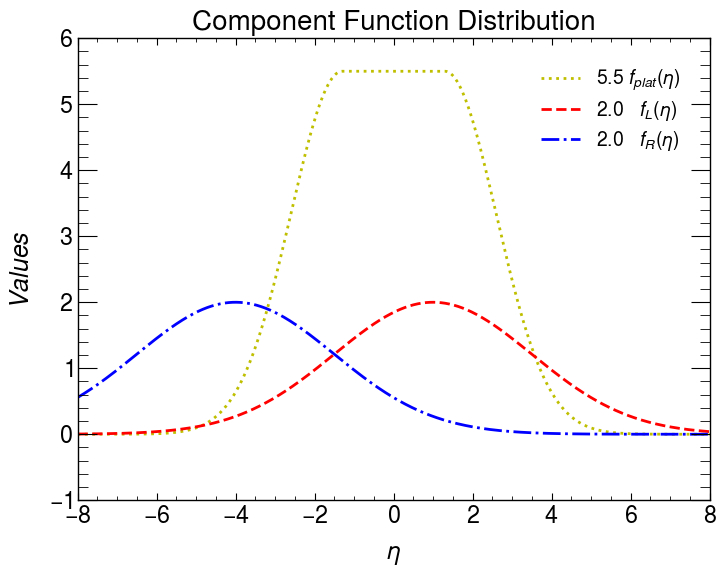

In [6]:
plot_component_function_distribution(y=8, y_0=4.0, sigma=2.5, L_factor=2.0, R_factor=2.0, P_factor=5.5, 
                  eta_flat=1.3, eta_gw=1.3,y_loss=3)

### EntropyAndDSdEtaCalculator类：用来计算三条纵向熵沉积的系数。当我们给定参数，就能实例化纵向的系数分布

In [7]:
class EntropyAndDSdEtaCalculator:
    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3, y_loss=0.5, 
                 P_factor=1, L_factor=1, R_factor=1, alpha=2.0, beta=0.5):
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor
        self.R_factor = R_factor
        self.P_factor = P_factor
        self.alpha = alpha
        self.beta = beta
        self.eta_flat = eta_flat
        self.eta_gw = eta_gw
        self.y_loss = y_loss

        self.coef_L, self.coef_R, self.coef_LR = self.calculate_coefficients()

    def gaussian(self, x=0, center=0, width=1):
        """
        Define a Gaussian distribution function.

        Parameters:
        x: Independent variable (single value or array)
        center: Center of the Gaussian
        width: Standard deviation of the Gaussian

        Returns:
        Gaussian value(s) at x
        """
        return np.exp(-((x - center) ** 2) / (2 * width ** 2))

    def plateau_function(self, eta):
        """
        Define a function with a plateau distribution.

        Parameters:
        eta: Independent variable array

        Returns:
        Plateau distribution values
        """
        # 初始化函数值，全为1
        heta = np.ones_like(eta)
        
        # 找到进入衰减区域的位置
        fall_off = np.abs(eta) > self.eta_flat
        
        # 对进入衰减区域的eta值计算其衰减部分
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat) ** 2 / (2.0 * self.eta_gw ** 2))
        
        return heta

    def calculate_coefficients(self):
        """
        Calculate and return the longitudinal distribution coefficients for L, R, and LR.
        """
        etas = np.linspace(-self.eta, self.eta, self.slices)
        coef_l = self.L_factor * self.gaussian(x=etas, center=self.y_0 - self.y_loss, width=self.sigma)
        coef_r = self.R_factor * self.gaussian(x=etas, center=-self.y_0, width=self.sigma)
        coef_lr = self.P_factor * self.plateau_function(etas)
        return coef_l, coef_r, coef_lr

    def calc_3D_entropy_part(self, entropy_2d, coef_list):
        """
        Calculate entropy 3D for a specific part
        Multiply a 2D matrix with a 1D coefficient list to produce a 3D matrix.
        """
        entropy_3d = np.zeros((len(coef_list), *entropy_2d.shape))
        for i, coef in enumerate(coef_list):
            entropy_3d[i] = entropy_2d * coef
        
        return entropy_3d

    def calc_entropy3D(self, entropy_200x200_L, entropy_200x200_R):
        """
        Calculate the sum of three 3D entropy distribution.
        """
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R

        entropy_L = self.calc_3D_entropy_part(entropy_200x200_L ** self.alpha, self.coef_L)
        entropy_R = self.calc_3D_entropy_part(entropy_200x200_R ** self.alpha, self.coef_R)
        entropy_LR = self.calc_3D_entropy_part(entropy2d_combined ** self.beta, self.coef_LR)

        return entropy_L + entropy_R + entropy_LR

    def calc_dSdEta_part(self, entropy_2d, coef_list):
        """
        Calculate dS/deta for a specific part.
        """
        dtau0 = 0.6
        dx = 0.1
        dy = 0.1
        deta = 0.115
        dtau = dtau0 * dx * dy * deta

        dSdEta = np.zeros(len(coef_list))
        for i, coef in enumerate(coef_list):
            dSdEta[i] = np.sum(entropy_2d) * dtau * coef
        return dSdEta

    def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R):
        """
        Calculate the sum of three dS/deta distribution.
        """
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R

        dSdEta_L = self.calc_dSdEta_part(entropy_200x200_L ** self.alpha, self.coef_L)
        dSdEta_R = self.calc_dSdEta_part(entropy_200x200_R ** self.alpha, self.coef_R)
        dSdEta_LR = self.calc_dSdEta_part(entropy2d_combined ** self.beta, self.coef_LR)

        return dSdEta_L + dSdEta_R + dSdEta_LR


### 计算单事件的 dSdEta distribution 值，按照给定的赝快度范围积分排序

In [8]:
def calculate_event_dSdEta(event, input_dir, calculator):
    """计算单事件的 dSdEta distribution 值 
    calculator:实例化的对象，内部方法可以计算熵分布
    """
    
    projectile_file = os.path.join(input_dir, f'projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'target_entropy_event_{event}.dat')
    
    if os.path.exists(projectile_file) and os.path.exists(target_file):
        # 读取数据
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)
        
        # 计算 dSdEta
        dSdEta = calculator.calc_dSdEta(sum_gaussian_L, sum_gaussian_R)
        return dSdEta
    else:
        print(f"Warning: Files for event {event} not found.")
        return None

def calculate_integral_dS(dsdeta, etas, method="trapezoid"):
    """
    计算 |etas| 范围 [3.0, 5.4] 内的积分
    """
    mask1 = (etas >= -5.4) & (etas <= -3.0)
    mask2 = (etas >= 3.0) & (etas <= 5.4)
    if method == "trapezoid":
        integral_dS = trapezoid(dsdeta[mask1], etas[mask1]) + trapezoid(dsdeta[mask2], etas[mask2])
    elif method == "simpson":
        integral_dS = simpson(dsdeta[mask1], x=etas[mask1]) + simpson(dsdeta[mask2], x=etas[mask2])
    else:
        raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
    return integral_dS




### 计算 event_range 内的所有事件,按照熵排序，划分中心度
### 挑选每个中心度中的 IC_events 个事件

In [9]:
def calc_event_indices_random(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                            eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300], IC_events=10,
                            L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                            cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                            HWF_or_DWF='HWF', num_workers=4):
    """
    逐事件并行计算 dSdEta distribution 和相应 eta 区间的 dSdEta 对 eta 积分结果，并返回指定中心度区间内随机挑选的事件序号。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向 gaussian distribution 能量沉积的参数
    :param eta_flat, eta_gw: 参数影响 plateau 平坦区域和高斯宽度
    :param y_loss: 损失参数，d核核子碰撞后可能会有纵向停滞
    :param L_factor, R_factor, P_factor, alpha=1, beta=0.5: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF两种核结构
    :param num_workers: 并行线程数量
    :param cents: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :return: 字典，包含每个中心度区间内的事件序号。
    """
    # 实例化计算器
    calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径，每个 trento 初态事件的 entropy2d 的位置
    disk_2T = 'west16'
    input_dir = (f'/media/mengzhu/{disk_2T}/d_Au_work2/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta、事件序号和积分值
    
    total_events = event_range[1] - event_range[0]
    processed_events = 0
    
    # 创建进度条
    from tqdm import tqdm
    progress_bar = tqdm(total=total_events, desc="Processing events", unit="event")

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral_dS(dsdeta=dSdEta_result, method="trapezoid")
                    
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_all.append([dSdEta_result, event, ds_total])
                
                # 更新进度条
                processed_events += 1
                progress_bar.update(1)
#                 progress_bar.set_postfix({"Completed": f"{processed_events}/{total_events}"})
                
            except Exception as e:
                print(f"Error processing event {event}: {e}")
                processed_events += 1
                progress_bar.update(1)
    
    progress_bar.close()

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)

    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_array[:, 2])[::-1]
    dSdEta_event_array = dSdEta_event_array[sorted_indices]
    
    # 提取每个中心度区间的事件序号
    total_events = len(dSdEta_event_array)
    centrality_event_indices = {}    

    for start, end in cents:
        print(f"{start}-{end} is computing!")
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        event_indices = dSdEta_event_array[start_idx:end_idx, 1]  # 提取事件序号
        
        # 使用numpy.random.choice函数随机取出数据: 第一个参数是数组，第二个szie参数是选取的数量
        if ((event_range[1]-event_range[0]) >= IC_events*len(cents)):
            event_indices_random_samples = np.random.choice(event_indices, size=IC_events, replace=False)
        else:
            print(f"划分中心度的文件数量 {event_range[1]-event_range[0]} 必须大于等于{IC_events}*{len(cents)}")
            break
        
        # 将随机挑选出来的 IC_events 个初态事件保存下来
        centrality_event_indices[f'{start}_{end}'] = event_indices_random_samples.tolist()

    return centrality_event_indices

In [10]:
centrality_event_indices_random_samples= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 20],IC_events = 4,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.4,
                    cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                    HWF_or_DWF='DWF', num_workers=16
)

Processing events: 100%|█████████████████████| 20/20 [00:00<00:00, 33.63event/s]

0-20 is computing!
20-40 is computing!
40-60 is computing!
60-80 is computing!
80-100 is computing!


In [11]:
centrality_event_indices_random_samples['0_20']

[9, 3, 10, 8]

### 按照随机挑选出来的事件，来计算三维熵密度文件

In [12]:
def calc_save_entropy3D_random(eta=6.9, slices=121, event_range=[0, 100], IC_events=10,
                               y_0=3.78, sigma=0.6, eta_flat=1.5, eta_gw=1.3, y_loss=0.5, 
                               P_factor=1, L_factor=1.0, R_factor=1.0, alpha=0.5, beta=2.0,  
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)], 
                               HWF_or_DWF='HWF',save_entropy3d=False, num_workers=4):
    """
    保存不同中心度的 entropy3D 文件，从 event_0 开始编号。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param event_range: 事件范围1000*5
    :IC_events: 每个中心度挑选的事件数
    :param y_0, sigma, eta_flat, eta_gw, y_loss, P_factor, L_factor, R_factor, beta: 理论参数
    :param save_entropy3d: 是否保存文件
    :param HWF_or_DWF: 指定 HWF 或 DWF
    :param cnets: 中心度划分
    :param num_workers: 并行线程数量
    """
    # 按中心度区间保存 entropy3D 文件
    if save_entropy3d:
        # 实例化计算器
        calculator = EntropyAndDSdEtaCalculator(
                        eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw, 
                        y_0=y_0, sigma=sigma, y_loss=y_loss, 
                        P_factor=P_factor, L_factor=L_factor, R_factor=R_factor, 
                        alpha=alpha, beta=beta)
        
        # 计算中心度区间的事件序号，并随机挑选
        print("centrality_event_indices is computing!")
        centrality_event_indices = calc_event_indices_random(
                        eta=eta, slices=slices, y_0=y_0, sigma=sigma, 
                        eta_flat=eta_flat, eta_gw=eta_gw, y_loss=y_loss, 
                        L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                        alpha=alpha, beta=beta, cents=cents, HWF_or_DWF=HWF_or_DWF, 
                        num_workers=num_workers, event_range=event_range,IC_events=IC_events)
        print("centrality_event_indices has computed!")
        
        # 准备输出entropy3d路径参数
        disk_2T = 'west16'
        base_output_dir = (f'/media/mengzhu/{disk_2T}/d_Au_work2/d_Au_{HWF_or_DWF}/'
                           f'entropy3d/entropy3d_ebe/plat_{str(eta_flat).replace(".", "p")}_gw_{str(eta_gw).replace(".", "p")}/')
        # 遍历中心度计算
        for centrality, event_indices in tqdm(centrality_event_indices.items()):
            
            # 创建中心度子目录
            centrality_dir = os.path.join(base_output_dir, f'entropy_cent_{centrality}')
            os.makedirs(centrality_dir, exist_ok=True)
            
            # 构造输出文件名
            filename = (f"entropy3D_y0_{str(y_0).replace('.', 'p')}_sigma_{str(sigma).replace('.', 'p')}_"
                        f"L_factor_{str(L_factor).replace('.', 'p')}_R_factor_{str(R_factor).replace('.', 'p')}_"
                        f"P_factor_{str(P_factor).replace('.', 'p')}_alpha_{str(alpha).replace('.', 'p')}_"
                        f"beta_{str(beta).replace('.', 'p')}_y_loss_{str(y_loss).replace('.', 'p')}.h5")
            output_path = os.path.join(centrality_dir, filename)
            
            # 检查文件是否已经存在，避免覆盖
            if os.path.exists(output_path):
                print(f"File {output_path} already exists, skipping...")
                break  # 跳过当前事件的保存
            
            # 打印信息确认所计算的内容
            event_indices_len = len(event_indices)
            print(f"Centrality range {centrality} is computing! \n"
                  f"Included events with lens {event_indices_len}: \n {event_indices} \n")
            
            # 新建并打开 HDF5 文件
            with h5py.File(output_path, 'w') as f:  # 使用写模式 'w'
                for i, event in tqdm(enumerate(event_indices)):
                    # 输入entropy2d路径
                    input_dir = (f'/media/mengzhu/west16/d_Au_work2/d_Au_{HWF_or_DWF}/entropy2d/')
                    input_filename_L = f"projectile_entropy_event_{event}.dat"
                    input_filename_R = f"target_entropy_event_{event}.dat"
                    input_path_L = os.path.join(input_dir, input_filename_L)
                    input_path_R = os.path.join(input_dir, input_filename_R)

                    # 读取输入文件
                    gaussian_L = np.loadtxt(input_path_L)
                    gaussian_R = np.loadtxt(input_path_R)

                    # 计算 entropy3D
                    entropy3D = calculator.calc_entropy3D(gaussian_L, gaussian_R)

                    # 保存到文件，从 event_0 开始编号
                    dataset_name = f'event_{i}'  # 从 0 开始编号
                    f.create_dataset(dataset_name, data=entropy3D)
                    print(f"event_{event} renamed {dataset_name} added to {centrality_dir}.")
            print(f"entropy3D for {centrality} saved at {centrality_dir}\n")

    else:
        print("plese keeping 'save_entroppy3d=True'")


In [22]:
calc_save_entropy3D_random(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 50000],IC_events=1000,
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.40,
                           cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                           HWF_or_DWF='DWF', num_workers=12,save_entropy3d=True)

centrality_event_indices is computing!


Processing events: 100%|█| 50000/50000 [22:06<00:00, 37.69event/s, Completed=500


0-20 is computing!
20-40 is computing!
40-60 is computing!
60-80 is computing!
80-100 is computing!
centrality_event_indices has computed!


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Centrality range 0_20 is computing! 
Included events with lens 1000: 
 [6641, 48792, 45132, 18331, 32719, 41465, 12820, 17569, 20526, 8538, 33798, 35676, 3528, 16985, 28565, 13858, 6348, 17031, 6165, 12214, 34972, 8281, 12591, 35621, 6907, 17853, 3037, 49033, 13776, 25069, 19637, 13735, 52, 27067, 33427, 21216, 21380, 39490, 48072, 2198, 13727, 30841, 27443, 5379, 18914, 42988, 23844, 6026, 27992, 16514, 17718, 49618, 31862, 17789, 19580, 20475, 22543, 10210, 7985, 15813, 36552, 3386, 14244, 17944, 42534, 30325, 47840, 32260, 34174, 18409, 35423, 29809, 9573, 8988, 41535, 20732, 23886, 23057, 12370, 26079, 46697, 17329, 3188, 14721, 20634, 26137, 16334, 4055, 48486, 21445, 34735, 46864, 31325, 20437, 4521, 18192, 37572, 19881, 24076, 15165, 20601, 16648, 19679, 414, 41624, 16494, 43044, 49382, 12434, 8561, 47420, 48385, 10664, 48879, 28460, 19536, 16572, 29246, 14399, 39913, 18521, 30349, 25772, 13616, 15694, 38516, 49318, 3887, 9033, 3882, 34648, 5284, 43494, 17084, 31985, 33815, 4212


0it [00:00, ?it/s]
1it [00:00,  9.55it/s]

event_6641 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48792 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



3it [00:00, 14.57it/s]

event_45132 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18331 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



5it [00:00,  4.59it/s]
7it [00:01,  6.50it/s]

event_32719 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41465 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12820 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



9it [00:01,  6.60it/s]

event_17569 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20526 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



10it [00:01,  6.43it/s]
12it [00:01,  8.03it/s]

event_8538 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33798 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35676 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



14it [00:01,  8.71it/s]

event_3528 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16985 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



16it [00:02,  9.32it/s]

event_28565 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13858 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6348 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



18it [00:02,  9.11it/s]
20it [00:02,  9.71it/s]

event_17031 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6165 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12214 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



22it [00:02,  9.24it/s]

event_34972 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8281 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



23it [00:02,  9.00it/s]
25it [00:02,  9.98it/s]

event_12591 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35621 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6907 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



27it [00:03,  8.72it/s]

event_17853 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3037 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



29it [00:03,  9.22it/s]

event_49033 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13776 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



31it [00:03,  9.87it/s]

event_25069 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19637 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13735 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



33it [00:03, 10.14it/s]
35it [00:04, 10.27it/s]

event_52 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27067 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33427 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



37it [00:04, 10.22it/s]
39it [00:04, 11.95it/s]

event_21216 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21380 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39490 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48072 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



41it [00:04, 10.67it/s]

event_2198 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13727 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



43it [00:05,  6.14it/s]

event_30841 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27443 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5379 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



45it [00:05,  7.04it/s]

event_18914 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42988 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



47it [00:05,  7.13it/s]
48it [00:05,  7.48it/s]

event_23844 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6026 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



49it [00:05,  7.54it/s]
50it [00:05,  7.90it/s]

event_27992 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16514 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



51it [00:06,  7.92it/s]

event_17718 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49618 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



53it [00:06,  8.42it/s]
54it [00:06,  7.68it/s]

event_31862 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17789 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



55it [00:06,  7.56it/s]
56it [00:06,  7.10it/s]

event_19580 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20475 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



57it [00:06,  7.38it/s]
59it [00:07,  9.06it/s]

event_22543 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10210 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7985 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



60it [00:07,  9.18it/s]
61it [00:07,  7.67it/s]

event_15813 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36552 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



62it [00:07,  7.68it/s]
63it [00:07,  7.82it/s]

event_3386 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14244 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



64it [00:07,  7.95it/s]

event_17944 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42534 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



66it [00:08,  7.01it/s]
68it [00:08,  8.65it/s]

event_30325 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47840 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32260 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



69it [00:08,  6.82it/s]

event_34174 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18409 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



71it [00:08,  6.70it/s]
73it [00:08,  7.82it/s]

event_35423 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29809 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9573 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



74it [00:09,  8.01it/s]
76it [00:09,  9.43it/s]

event_8988 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41535 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20732 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



78it [00:09,  9.78it/s]

event_23886 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23057 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



80it [00:09,  7.12it/s]

event_12370 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26079 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



82it [00:10,  8.41it/s]

event_46697 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17329 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



84it [00:10,  7.97it/s]

event_3188 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14721 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20634 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



86it [00:10,  8.14it/s]
88it [00:10,  9.30it/s]

event_26137 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16334 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4055 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48486 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



90it [00:10, 10.71it/s]
92it [00:10, 12.27it/s]

event_21445 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34735 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46864 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



94it [00:11, 12.19it/s]

event_31325 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20437 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4521 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



96it [00:11, 12.86it/s]
98it [00:11, 13.42it/s]

event_18192 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37572 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19881 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24076 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



100it [00:11, 14.05it/s]
102it [00:11, 13.15it/s]

event_15165 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20601 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16648 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



104it [00:11, 10.98it/s]

event_19679 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_414 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



106it [00:12, 11.90it/s]
108it [00:12, 13.47it/s]

event_41624 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16494 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43044 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49382 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12434 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



110it [00:18,  1.01s/it]
112it [00:18,  1.38it/s]

event_8561 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47420 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48385 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



114it [00:25,  1.58s/it]

event_10664 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48879 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



115it [00:32,  2.52s/it]
116it [00:32,  2.04s/it]

event_28460 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19536 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



117it [00:32,  1.61s/it]
118it [00:33,  1.25s/it]

event_16572 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29246 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



120it [00:33,  1.30it/s]
121it [00:33,  1.60it/s]

event_14399 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39913 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18521 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



122it [00:36,  1.31s/it]

event_30349 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



123it [00:40,  2.05s/it]
125it [00:41,  1.22s/it]

event_25772 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13616 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15694 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



127it [00:41,  1.29it/s]

event_38516 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49318 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3887 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



129it [00:41,  1.87it/s]
131it [00:41,  2.59it/s]

event_9033 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3882 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34648 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



133it [00:41,  3.56it/s]

event_5284 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43494 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17084 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



135it [00:41,  4.44it/s]

event_31985 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33815 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



137it [00:42,  5.17it/s]
139it [00:42,  6.10it/s]

event_4212 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42759 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41447 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



141it [00:42,  6.53it/s]

event_37254 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23052 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



142it [00:42,  6.74it/s]
144it [00:42,  8.16it/s]

event_10870 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34546 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48748 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



146it [00:43,  9.36it/s]

event_23469 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31092 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28235 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



148it [00:43, 10.44it/s]
150it [00:43, 11.73it/s]

event_26372 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29545 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47297 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34020 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



152it [00:43, 12.37it/s]
154it [00:43, 12.93it/s]

event_232 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47958 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11323 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39837 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



156it [00:43, 13.24it/s]
158it [00:43, 13.43it/s]

event_29968 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8979 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21617 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



160it [00:43, 13.79it/s]
162it [00:44, 14.83it/s]

event_37374 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31505 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45373 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41990 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



164it [00:44, 14.10it/s]

event_14608 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12245 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18512 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



166it [00:44, 13.83it/s]
168it [00:44, 13.65it/s]

event_5237 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17049 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14588 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



170it [00:44, 13.56it/s]
172it [00:44, 14.37it/s]

event_22190 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29211 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11229 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40450 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



174it [00:44, 14.31it/s]
176it [00:45, 14.70it/s]

event_22290 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22542 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6214 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16438 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



178it [00:45, 14.88it/s]

event_43248 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38062 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39131 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



180it [00:45, 14.58it/s]
182it [00:45, 14.68it/s]

event_367 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1010 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27663 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29352 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



184it [00:45, 14.63it/s]
186it [00:45, 14.58it/s]

event_21664 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18022 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17968 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47005 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



188it [00:45, 15.11it/s]
190it [00:46, 15.35it/s]

event_5256 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35529 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47951 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



192it [00:46, 14.87it/s]
194it [00:46, 15.01it/s]

event_36947 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33349 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33557 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14046 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



196it [00:46, 15.19it/s]

event_47462 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29842 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16253 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



198it [00:46, 15.15it/s]
200it [00:46, 15.57it/s]

event_25471 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34644 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44884 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3612 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



202it [00:46, 14.84it/s]
204it [00:46, 15.10it/s]

event_25434 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39108 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11358 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41281 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



206it [00:47, 15.16it/s]
208it [00:47, 15.08it/s]

event_16647 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22661 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29607 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



210it [00:47, 14.69it/s]

event_24658 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14393 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49886 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



212it [00:47, 13.97it/s]
214it [00:47, 14.13it/s]

event_7733 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32347 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6704 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47798 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



216it [00:47, 14.48it/s]
218it [00:47, 14.83it/s]

event_26007 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33551 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27666 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41429 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



220it [00:48, 14.90it/s]

event_33373 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35406 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



222it [00:48, 11.01it/s]
224it [00:48, 12.00it/s]

event_25542 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40773 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12241 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36100 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



226it [00:48, 12.66it/s]
228it [00:48, 12.96it/s]

event_33383 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42283 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17507 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21758 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



230it [00:49,  4.99it/s]

event_19424 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47415 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



232it [00:50,  4.35it/s]

event_33929 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



233it [00:50,  3.33it/s]

event_34996 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28254 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



235it [00:59,  1.62s/it]

event_11602 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



236it [01:05,  2.42s/it]

event_36379 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



237it [01:10,  2.96s/it]
238it [01:10,  2.30s/it]

event_8680 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23997 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



239it [01:15,  2.99s/it]

event_34563 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



240it [01:15,  2.27s/it]
242it [01:15,  1.33s/it]

event_12383 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47123 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_898 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



244it [01:15,  1.18it/s]

event_48181 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1663 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12977 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



246it [01:16,  1.71it/s]
248it [01:16,  2.44it/s]

event_380 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19806 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42779 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18369 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



250it [01:16,  3.33it/s]
252it [01:16,  4.42it/s]

event_14248 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45180 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22057 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39545 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



254it [01:16,  5.65it/s]

event_14965 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



256it [01:16,  5.71it/s]

event_2965 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29998 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



258it [01:17,  6.65it/s]

event_4737 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37935 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18355 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



260it [01:17,  8.02it/s]
262it [01:17,  8.96it/s]

event_41926 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23223 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15318 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



264it [01:17, 10.11it/s]
266it [01:17, 11.45it/s]

event_32682 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30136 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23631 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45790 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



268it [01:17, 12.31it/s]

event_47337 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14295 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15251 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



270it [01:17, 12.66it/s]
272it [01:18, 13.26it/s]

event_27191 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47870 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19522 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30993 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



274it [01:18, 13.84it/s]
276it [01:18, 13.84it/s]

event_27397 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38352 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1887 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



278it [01:18, 14.48it/s]


event_39831 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49087 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24570 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14015 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.


280it [01:18, 14.18it/s]
282it [01:18, 14.23it/s]

event_15057 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19577 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30885 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



284it [01:18, 14.20it/s]
286it [01:19, 14.45it/s]

event_10880 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46600 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11348 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42817 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



288it [01:19, 14.08it/s]
290it [01:19, 14.37it/s]

event_37783 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15888 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3056 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34621 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



292it [01:19, 14.46it/s]
294it [01:19, 14.67it/s]

event_6319 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46882 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30465 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23779 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



296it [01:19, 15.09it/s]
298it [01:19, 14.84it/s]

event_13725 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24282 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3039 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41444 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



300it [01:20, 14.82it/s]
302it [01:20, 14.76it/s]

event_13863 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34255 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14696 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



304it [01:20, 14.94it/s]

event_22753 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7571 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28065 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



306it [01:20, 14.63it/s]
308it [01:20, 14.60it/s]

event_25652 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7399 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33053 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



310it [01:20, 15.20it/s]


event_9174 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43568 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6786 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_647 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.


312it [01:20, 14.64it/s]
314it [01:21, 10.88it/s]

event_39981 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25538 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



316it [01:21, 10.93it/s]

event_7456 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39954 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20565 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



318it [01:21, 11.55it/s]
320it [01:21, 12.27it/s]

event_4593 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35341 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45720 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



322it [01:21, 12.49it/s]

event_1049 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34814 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



324it [01:21, 11.28it/s]

event_26824 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20156 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9981 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



326it [01:22, 12.16it/s]
328it [01:22, 12.73it/s]

event_35013 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33634 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22592 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



330it [01:22, 13.09it/s]
332it [01:22, 13.85it/s]

event_1138 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8706 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42682 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41583 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



334it [01:22, 11.49it/s]

event_11384 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1578 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22725 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



336it [01:22, 12.15it/s]
338it [01:23, 12.84it/s]

event_13789 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36497 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23173 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



340it [01:23, 13.30it/s]

event_17851 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19285 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31469 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



342it [01:23, 13.62it/s]

event_42805 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



344it [01:23,  6.81it/s]

event_28737 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46398 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41256 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



346it [01:24,  5.32it/s]

event_4370 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



347it [01:25,  4.04it/s]

event_24687 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17915 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



349it [01:25,  3.21it/s]
350it [01:26,  3.63it/s]

event_31710 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40451 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



351it [01:26,  4.05it/s]

event_37963 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



352it [01:31,  1.45s/it]

event_28069 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



353it [01:41,  3.63s/it]

event_3985 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



354it [01:48,  4.46s/it]

event_25404 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



355it [01:48,  3.33s/it]

event_33673 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



356it [01:50,  2.89s/it]
358it [01:50,  1.64s/it]

event_20292 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24242 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41760 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



360it [01:50,  1.03s/it]

event_44653 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12300 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4936 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



362it [01:50,  1.45it/s]
364it [01:51,  2.07it/s]

event_33332 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46489 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28839 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



366it [01:51,  2.88it/s]

event_27380 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47532 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



368it [01:51,  3.67it/s]
370it [01:51,  4.81it/s]

event_14402 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8230 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2757 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45636 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



372it [01:51,  6.03it/s]

event_16188 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23384 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19491 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



374it [01:51,  7.25it/s]
376it [01:52,  8.65it/s]

event_41441 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40834 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36159 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44316 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



378it [01:52,  9.79it/s]
380it [01:52, 10.84it/s]

event_33398 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29267 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29519 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



382it [01:52, 11.37it/s]

event_1566 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27478 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27816 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



384it [01:52, 12.50it/s]
386it [01:52, 12.80it/s]

event_44557 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9587 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42787 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



388it [01:52, 12.70it/s]

event_19219 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30245 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29262 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



390it [01:53, 13.19it/s]
392it [01:53, 13.66it/s]

event_30224 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6244 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24187 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



394it [01:53, 13.85it/s]
396it [01:53, 14.35it/s]

event_14983 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28801 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31111 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49234 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



398it [01:53, 14.09it/s]
400it [01:53, 14.07it/s]

event_9131 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43594 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11795 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16355 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



402it [01:53, 14.21it/s]

event_37217 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29894 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11528 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



404it [01:54, 14.48it/s]
406it [01:54, 14.95it/s]

event_23100 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27427 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30768 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42079 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



408it [01:54, 14.90it/s]
410it [01:54, 14.90it/s]

event_18550 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25520 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7614 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34259 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



412it [01:54, 15.48it/s]
414it [01:54, 15.05it/s]

event_43763 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48895 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17961 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



416it [01:54, 15.26it/s]
418it [01:54, 15.39it/s]

event_30241 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34532 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31853 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47835 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



420it [01:55, 14.86it/s]

event_10214 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15929 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19826 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



422it [01:55, 14.82it/s]
424it [01:55, 13.85it/s]

event_26001 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38580 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20012 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



426it [01:55, 13.86it/s]

event_23206 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49486 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47584 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



428it [01:55, 14.14it/s]
430it [01:55, 12.95it/s]

event_31737 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12800 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40924 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



432it [01:55, 12.93it/s]

event_24800 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6737 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1681 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



434it [01:56, 13.38it/s]
436it [01:56, 14.12it/s]

event_42024 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42468 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48735 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



438it [01:56, 13.89it/s]

event_24108 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49730 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



440it [01:56, 11.61it/s]

event_41771 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14476 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35909 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



442it [01:56, 12.33it/s]
444it [01:56, 13.09it/s]

event_11228 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47663 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34502 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18834 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



446it [01:57, 11.70it/s]
448it [01:57, 11.75it/s]

event_43956 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42935 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8690 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



450it [01:57, 11.92it/s]

event_21831 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33809 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10787 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



452it [01:57, 12.53it/s]
454it [01:57, 13.25it/s]

event_40175 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25523 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47144 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



456it [01:57, 10.69it/s]

event_18312 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23259 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36334 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



458it [01:58, 10.29it/s]
460it [01:58, 11.41it/s]

event_15501 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11192 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49130 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



462it [01:59,  4.67it/s]

event_19929 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39996 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20570 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



464it [01:59,  4.25it/s]

event_29016 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



465it [02:00,  3.60it/s]

event_31459 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40034 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



467it [02:00,  4.13it/s]

event_7415 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



468it [02:01,  4.05it/s]

event_23136 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



469it [02:10,  2.16s/it]

event_21669 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



470it [02:17,  3.37s/it]

event_38687 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



471it [02:24,  4.23s/it]
472it [02:24,  3.14s/it]

event_34653 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33816 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40825 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



474it [02:24,  1.82s/it]
476it [02:24,  1.15s/it]

event_25049 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16196 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49727 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



478it [02:24,  1.29it/s]

event_35525 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11479 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15347 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



480it [02:24,  1.85it/s]
482it [02:25,  2.58it/s]

event_2995 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44114 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45715 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



484it [02:25,  3.50it/s]

event_17268 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46732 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42460 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



486it [02:25,  4.51it/s]
488it [02:25,  5.80it/s]

event_18699 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26579 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48341 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



490it [02:25,  7.11it/s]
492it [02:25,  8.53it/s]

event_13379 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41290 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30477 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37175 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



494it [02:25,  9.74it/s]

event_23345 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38156 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27563 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



496it [02:25, 10.85it/s]
498it [02:26, 11.76it/s]

event_31073 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43740 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21118 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



500it [02:26, 12.24it/s]

event_33411 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4152 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47554 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



502it [02:26, 12.63it/s]
504it [02:26, 13.08it/s]

event_11469 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18371 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20267 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



506it [02:26, 12.98it/s]

event_16676 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22525 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13286 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



508it [02:26, 13.38it/s]
510it [02:26, 13.90it/s]

event_7066 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14133 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14509 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



512it [02:27, 13.51it/s]
514it [02:27, 13.88it/s]

event_929 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25551 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2816 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42989 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



516it [02:27, 14.14it/s]

event_24530 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10501 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7536 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



518it [02:27, 14.35it/s]
520it [02:27, 14.55it/s]

event_37931 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9962 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42511 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49438 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



522it [02:27, 13.61it/s]
524it [02:27, 13.97it/s]

event_18838 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6293 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39724 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



526it [02:28, 13.46it/s]

event_34684 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6909 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9362 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



528it [02:28, 13.26it/s]

event_41323 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30089 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



530it [02:28, 11.22it/s]
532it [02:28, 11.55it/s]

event_42173 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49810 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20216 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



534it [02:28, 11.94it/s]

event_24516 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1271 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21411 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



536it [02:29, 11.72it/s]
538it [02:29, 12.57it/s]

event_5858 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38203 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39347 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



540it [02:29, 13.18it/s]

event_16041 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20320 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4472 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



542it [02:29, 13.18it/s]
544it [02:29, 13.70it/s]

event_33386 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16449 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13181 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23858 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



546it [02:29, 14.15it/s]

event_32400 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27915 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



548it [02:30, 10.32it/s]
550it [02:30, 11.11it/s]

event_10807 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20168 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31413 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



552it [02:30, 11.11it/s]

event_10909 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7035 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41676 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



554it [02:30, 11.53it/s]
556it [02:30, 12.35it/s]

event_29865 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23467 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39152 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



558it [02:30, 12.76it/s]

event_17171 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5492 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42048 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



560it [02:30, 12.76it/s]
562it [02:31, 13.36it/s]

event_4945 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27804 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11674 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



564it [02:31, 13.65it/s]

event_40007 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5659 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38623 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



566it [02:31, 13.90it/s]
568it [02:31, 13.74it/s]

event_11392 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6488 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5791 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



570it [02:31, 13.67it/s]

event_32434 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9783 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39267 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



572it [02:31, 11.57it/s]

event_13694 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41027 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



574it [02:32,  6.42it/s]
576it [02:32,  7.56it/s]

event_13275 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42473 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23187 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42593 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



578it [02:33,  4.36it/s]

event_39102 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14612 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



580it [02:34,  4.09it/s]

event_27913 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21312 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



582it [02:35,  2.75it/s]

event_19552 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



583it [02:42,  1.60s/it]

event_24606 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



584it [02:47,  2.14s/it]

event_1709 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



585it [02:52,  2.78s/it]

event_30059 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



586it [02:57,  3.51s/it]

event_7373 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



587it [02:58,  2.74s/it]
589it [02:58,  1.61s/it]

event_27710 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10184 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46385 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



591it [02:58,  1.03s/it]

event_2968 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30512 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5432 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



593it [02:58,  1.44it/s]
595it [02:58,  2.06it/s]

event_24138 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33817 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13984 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



597it [02:59,  2.85it/s]

event_19426 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15172 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45590 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



599it [02:59,  3.77it/s]
601it [02:59,  4.94it/s]

event_1762 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37271 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33878 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29671 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



603it [02:59,  6.20it/s]
605it [02:59,  7.55it/s]

event_1687 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14725 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31249 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



607it [02:59,  8.78it/s]

event_38989 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21234 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41951 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



609it [02:59,  9.38it/s]
611it [03:00, 10.55it/s]

event_36815 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42788 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3514 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44612 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



613it [03:00, 11.56it/s]
615it [03:00, 12.28it/s]

event_41328 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19192 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28667 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



617it [03:00, 12.48it/s]

event_6480 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19141 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4117 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



619it [03:00,  9.76it/s]
621it [03:01,  9.98it/s]

event_3110 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42623 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25457 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



623it [03:01, 10.91it/s]

event_34499 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27048 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32546 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



625it [03:01, 11.24it/s]
627it [03:01, 11.63it/s]

event_40024 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32435 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15964 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



629it [03:01, 12.32it/s]

event_18741 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2252 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



631it [03:01,  9.68it/s]

event_45205 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20999 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



633it [03:02,  9.70it/s]

event_21903 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14692 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



635it [03:02,  9.24it/s]

event_886 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36174 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5967 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



637it [03:02,  9.79it/s]
639it [03:02, 10.68it/s]

event_16956 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46695 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40983 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



641it [03:02, 11.37it/s]

event_12426 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14438 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30392 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



643it [03:03, 11.93it/s]
645it [03:03, 11.35it/s]

event_25177 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22627 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39911 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



647it [03:03, 12.18it/s]

event_37981 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12621 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45785 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



649it [03:03, 12.24it/s]

event_44623 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22359 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



651it [03:03, 11.34it/s]
653it [03:03, 11.61it/s]

event_12571 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45362 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32066 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



655it [03:04, 12.14it/s]

event_23051 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43540 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36474 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



657it [03:04, 11.51it/s]
659it [03:04, 12.16it/s]

event_13504 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37139 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12898 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



661it [03:04,  8.20it/s]

event_28495 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31139 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34042 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



663it [03:04,  9.03it/s]
665it [03:05,  9.88it/s]

event_1850 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7313 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21428 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



667it [03:05, 10.71it/s]

event_26190 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12453 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18918 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



669it [03:05, 11.63it/s]
671it [03:05, 11.91it/s]

event_39399 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1672 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13282 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



673it [03:05, 11.44it/s]

event_20199 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9635 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



675it [03:05, 11.54it/s]

event_35720 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11124 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40750 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



677it [03:06,  9.67it/s]

event_6905 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31071 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



679it [03:06,  9.17it/s]
681it [03:06, 10.27it/s]

event_13604 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41814 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19028 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



683it [03:06, 11.22it/s]

event_28775 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27822 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24199 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



685it [03:06, 11.95it/s]
687it [03:07, 12.52it/s]

event_32404 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29442 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14741 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28528 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



689it [03:07,  7.54it/s]
691it [03:07,  8.61it/s]

event_32367 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17287 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48566 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23495 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



693it [03:08,  5.72it/s]

event_24498 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22137 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



695it [03:08,  4.83it/s]

event_15548 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45120 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



697it [03:09,  4.28it/s]

event_37924 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



698it [03:10,  2.79it/s]

event_8098 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



699it [03:18,  1.87s/it]

event_12817 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



700it [03:27,  3.41s/it]

event_21257 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



701it [03:31,  3.54s/it]
702it [03:31,  2.67s/it]

event_29826 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42382 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



703it [03:31,  2.00s/it]

event_16465 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



704it [03:33,  2.13s/it]
706it [03:33,  1.23s/it]

event_40699 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45911 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27690 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



708it [03:34,  1.28it/s]

event_20922 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16446 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9049 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



710it [03:34,  1.89it/s]
712it [03:34,  2.64it/s]

event_26038 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43144 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4335 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



714it [03:34,  3.49it/s]
716it [03:34,  4.61it/s]

event_40883 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15447 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6448 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41708 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



718it [03:34,  5.87it/s]

event_30308 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28473 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15191 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



720it [03:35,  7.17it/s]
722it [03:35,  8.41it/s]

event_20023 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_352 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37338 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35382 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



724it [03:35,  7.00it/s]
726it [03:35,  8.04it/s]

event_37097 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30883 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19844 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



728it [03:35,  9.16it/s]

event_42897 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27496 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23800 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



730it [03:36,  9.87it/s]
732it [03:36, 11.05it/s]

event_16053 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15219 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17109 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43396 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



734it [03:36, 11.90it/s]
736it [03:36, 12.41it/s]

event_21618 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27701 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41871 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



738it [03:36, 11.38it/s]

event_4118 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3578 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



740it [03:36,  9.09it/s]

event_9254 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26454 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6531 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



742it [03:37,  8.08it/s]
743it [03:37,  8.35it/s]

event_8874 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38279 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22596 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



745it [03:37,  9.56it/s]
747it [03:37, 10.71it/s]

event_20034 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31185 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19322 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



749it [03:37, 11.45it/s]

event_18410 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24918 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25103 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



751it [03:37, 12.12it/s]
753it [03:38, 12.46it/s]

event_17823 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22062 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15943 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



755it [03:38, 12.86it/s]

event_11747 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16135 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16024 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



757it [03:38, 13.27it/s]
759it [03:38, 13.67it/s]

event_4756 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25715 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35474 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



761it [03:38, 13.62it/s]

event_38948 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3291 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19183 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



763it [03:38, 13.52it/s]
765it [03:39, 13.39it/s]

event_33192 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_156 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29480 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



767it [03:39, 13.64it/s]

event_23772 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47334 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48017 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



769it [03:39, 13.75it/s]
771it [03:39, 13.82it/s]

event_24261 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8256 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40634 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



773it [03:39, 14.33it/s]

event_35833 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48111 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24950 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



775it [03:39, 14.15it/s]
777it [03:39, 14.21it/s]

event_16891 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40982 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14158 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



779it [03:39, 14.26it/s]

event_8052 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_883 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1072 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



781it [03:40, 14.30it/s]
783it [03:40, 14.31it/s]

event_32299 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15030 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27603 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



785it [03:40, 14.31it/s]

event_20417 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47066 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10187 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



787it [03:40, 14.22it/s]
789it [03:40, 14.46it/s]

event_25814 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12312 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28124 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39742 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



791it [03:40, 14.62it/s]
793it [03:40, 14.81it/s]

event_32635 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23316 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43758 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



795it [03:41, 14.72it/s]

event_41339 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32062 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49037 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



797it [03:41, 14.36it/s]
799it [03:41, 14.27it/s]

event_23632 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46349 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35959 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



801it [03:41, 14.43it/s]

event_31347 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4795 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29711 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



803it [03:41, 14.63it/s]
805it [03:41, 15.01it/s]

event_30036 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25807 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28991 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23072 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



807it [03:41, 14.80it/s]

event_42075 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37848 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



809it [03:42,  6.52it/s]

event_32897 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



811it [03:43,  5.45it/s]

event_1780 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48003 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



812it [03:43,  4.08it/s]

event_45163 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6804 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



814it [03:44,  3.73it/s]

event_40596 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42948 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



816it [03:44,  3.66it/s]

event_41028 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



817it [03:50,  1.27s/it]

event_15981 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



818it [03:55,  2.14s/it]

event_20777 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



819it [04:02,  3.30s/it]

event_36473 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



820it [04:08,  3.86s/it]
822it [04:08,  2.29s/it]

event_41518 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18622 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31072 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



824it [04:08,  1.47s/it]

event_46071 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36253 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18625 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



826it [04:09,  1.01it/s]
828it [04:09,  1.47it/s]

event_8036 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42638 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19807 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



830it [04:09,  2.06it/s]

event_12518 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23905 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18135 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



832it [04:09,  2.80it/s]
834it [04:09,  3.71it/s]

event_49378 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31358 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49423 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



836it [04:09,  4.82it/s]

event_220 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43243 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42862 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



838it [04:09,  5.98it/s]
840it [04:10,  6.90it/s]

event_1492 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27521 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2522 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



842it [04:10,  7.67it/s]

event_36347 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27983 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34382 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



844it [04:10,  9.05it/s]
846it [04:10, 10.04it/s]

event_5069 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48307 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4085 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



848it [04:10, 11.08it/s]


event_8581 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33639 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18975 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37251 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.


850it [04:10, 12.04it/s]

event_25593 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



852it [04:11,  4.61it/s]

event_38594 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33989 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



854it [04:18,  1.16s/it]
856it [04:18,  1.19it/s]

event_20459 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35624 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19495 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



858it [04:18,  1.64it/s]

event_23571 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23624 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36516 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



860it [04:19,  2.22it/s]
862it [04:19,  2.98it/s]

event_31664 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41224 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18222 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39444 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



864it [04:19,  3.92it/s]
866it [04:19,  5.03it/s]

event_16874 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25489 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27493 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



868it [04:19,  6.23it/s]
870it [04:19,  7.57it/s]

event_1612 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19198 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9210 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9367 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



872it [04:19,  8.86it/s]

event_29861 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26210 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



874it [04:24,  1.32it/s]

event_49134 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37266 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37718 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



876it [04:24,  1.77it/s]
878it [04:24,  2.37it/s]

event_41373 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19793 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10942 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



880it [04:24,  3.13it/s]

event_14677 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5953 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33285 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



882it [04:25,  4.09it/s]
884it [04:25,  5.19it/s]

event_25831 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44375 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42664 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



886it [04:25,  6.39it/s]

event_33765 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37688 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24474 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



888it [04:25,  7.53it/s]
890it [04:25,  8.71it/s]

event_46056 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48289 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39859 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



892it [04:25,  9.77it/s]

event_38703 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49413 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49753 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



894it [04:25, 10.79it/s]
896it [04:26, 11.52it/s]

event_30928 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47048 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41675 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



898it [04:26, 11.98it/s]

event_43022 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38249 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41784 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



900it [04:26, 12.30it/s]
902it [04:26, 12.25it/s]

event_13285 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4405 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38743 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



904it [04:26, 12.80it/s]

event_34015 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37110 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45568 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



906it [04:26, 12.94it/s]
908it [04:27, 12.96it/s]

event_7541 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31151 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48506 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



910it [04:27, 12.38it/s]

event_30620 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21053 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5682 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



912it [04:27, 12.05it/s]
914it [04:27, 12.05it/s]

event_2214 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16271 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5567 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



916it [04:27, 12.68it/s]

event_13590 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44780 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22951 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



918it [04:27, 12.87it/s]
920it [04:27, 13.39it/s]

event_46401 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18034 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26506 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14908 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



922it [04:28, 13.91it/s]
924it [04:28, 13.99it/s]

event_40220 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32133 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25356 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



926it [04:28, 14.24it/s]

event_18434 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6097 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24237 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



928it [04:28, 14.38it/s]
930it [04:28, 13.99it/s]

event_32727 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24597 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31931 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



932it [04:28, 14.10it/s]

event_36786 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27322 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22620 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



934it [04:28, 14.16it/s]

event_34923 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



936it [04:29, 10.49it/s]

event_40293 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16787 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35884 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



938it [04:29, 11.29it/s]
940it [04:29, 11.76it/s]

event_18424 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2969 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28508 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



942it [04:29, 12.24it/s]

event_47746 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3384 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47645 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



944it [04:29, 12.30it/s]
946it [04:30, 12.73it/s]

event_609 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43771 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43438 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



948it [04:30, 12.34it/s]

event_5129 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20691 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16010 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



950it [04:30, 13.01it/s]
952it [04:30, 12.63it/s]

event_41343 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45918 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49374 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



954it [04:30, 13.05it/s]

event_48097 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33620 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47890 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



956it [04:30, 13.08it/s]
958it [04:30, 13.54it/s]

event_8351 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15715 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10791 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



960it [04:31, 13.70it/s]

event_46768 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18806 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



962it [04:31,  9.57it/s]

event_15788 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11414 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



964it [04:31, 10.66it/s]

event_14338 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40955 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3517 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



966it [04:31, 10.99it/s]
968it [04:31, 11.01it/s]

event_21763 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3430 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49794 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



970it [04:32, 11.74it/s]

event_36939 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18157 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39167 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



972it [04:32, 11.63it/s]
974it [04:32, 11.66it/s]

event_18903 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11091 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28472 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



976it [04:32, 12.29it/s]

event_49952 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_619 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1551 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



978it [04:33,  6.85it/s]

event_36986 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



979it [04:33,  5.04it/s]

event_475 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



980it [04:34,  3.88it/s]

event_927 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23952 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



982it [04:34,  3.68it/s]

event_29605 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40771 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



984it [04:36,  2.36it/s]

event_43416 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



985it [04:43,  1.86s/it]

event_32441 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



986it [04:46,  2.05s/it]

event_14656 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



987it [04:47,  1.69s/it]

event_26277 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



988it [04:50,  2.24s/it]

event_10647 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



989it [04:58,  3.58s/it]

event_21787 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



990it [04:59,  2.89s/it]
992it [04:59,  1.65s/it]

event_21465 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3928 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7140 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



994it [04:59,  1.05s/it]

event_28074 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23066 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27481 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



996it [04:59,  1.42it/s]
998it [04:59,  2.03it/s]

event_27870 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48349 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48974 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.



1000it [05:00,  3.33it/s]


event_5358 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23908 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20.


 20%|████████▊                                   | 1/5 [05:00<20:01, 300.43s/it]

entropy3D for 0_20 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_0_20

Centrality range 20_40 is computing! 
Included events with lens 1000: 
 [16805, 34635, 43898, 33263, 48857, 3218, 28825, 40857, 963, 2400, 6515, 11688, 6224, 5378, 2450, 136, 2891, 31257, 37869, 41117, 10545, 40810, 43992, 39370, 35359, 10684, 41494, 25539, 6267, 31726, 12351, 18083, 19100, 21197, 28664, 19178, 11672, 19645, 16251, 47936, 30540, 471, 23273, 23488, 26846, 47303, 5396, 40083, 14561, 43904, 13074, 35471, 20356, 20870, 13027, 25537, 17502, 35218, 44317, 4973, 34624, 8177, 17758, 3880, 42830, 29210, 25464, 4058, 15208, 40790, 40228, 19877, 29269, 23373, 460, 30291, 1111, 40010, 413, 22205, 12372, 4095, 49993, 7518, 7359, 1895, 16397, 26662, 7061, 46378, 44015, 26637, 28441, 19557, 17244, 31171, 45286, 28352, 33986, 13417, 2527, 11972, 27273, 1147, 15740, 571, 2558, 38489, 42408, 19237, 40968, 19496, 24719, 37431, 917, 33658, 18060, 41630, 8066, 32


0it [00:00, ?it/s]

event_16805 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



2it [00:00,  7.39it/s]
3it [00:00,  7.79it/s]

event_34635 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43898 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



5it [00:00,  9.46it/s]

event_33263 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48857 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3218 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



7it [00:00, 10.96it/s]
9it [00:00, 11.49it/s]

event_28825 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40857 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_963 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



11it [00:01, 12.13it/s]

event_2400 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6515 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



13it [00:01,  9.70it/s]

event_11688 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6224 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



15it [00:01,  8.83it/s]

event_5378 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2450 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



17it [00:01,  9.06it/s]

event_136 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2891 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31257 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



19it [00:01, 10.24it/s]
21it [00:02, 11.46it/s]

event_37869 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41117 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10545 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40810 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



23it [00:02, 12.13it/s]
25it [00:02, 12.91it/s]

event_43992 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39370 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35359 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10684 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



27it [00:02, 13.63it/s]
29it [00:02, 14.11it/s]

event_41494 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25539 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6267 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



31it [00:02, 13.08it/s]

event_31726 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12351 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18083 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



33it [00:02, 13.27it/s]
35it [00:03, 13.85it/s]

event_19100 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21197 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28664 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



37it [00:03, 14.00it/s]

event_19178 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11672 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19645 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



39it [00:03, 14.09it/s]
41it [00:03, 14.24it/s]

event_16251 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47936 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30540 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



43it [00:03, 14.18it/s]
45it [00:03, 14.55it/s]

event_471 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23273 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23488 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26846 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



47it [00:03, 14.26it/s]

event_47303 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5396 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40083 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



49it [00:04, 14.29it/s]
51it [00:04, 14.36it/s]

event_14561 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43904 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13074 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



53it [00:04, 14.56it/s]

event_35471 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20356 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20870 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



55it [00:04, 14.50it/s]
57it [00:04, 14.42it/s]

event_13027 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25537 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17502 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



59it [00:04, 14.60it/s]
61it [00:04, 14.93it/s]

event_35218 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44317 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4973 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34624 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



63it [00:04, 14.76it/s]

event_8177 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17758 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3880 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



65it [00:05, 14.10it/s]

event_42830 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29210 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



67it [00:05, 10.03it/s]
69it [00:05, 10.63it/s]

event_25464 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4058 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15208 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



71it [00:05, 11.68it/s]

event_40790 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40228 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19877 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



73it [00:05, 11.84it/s]
75it [00:06, 11.80it/s]

event_29269 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23373 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_460 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



77it [00:06, 12.23it/s]

event_30291 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1111 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40010 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



79it [00:06, 12.29it/s]
81it [00:06, 12.49it/s]

event_413 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22205 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12372 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



83it [00:06, 12.55it/s]

event_4095 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49993 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7518 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



85it [00:06, 11.35it/s]
87it [00:07, 11.21it/s]

event_7359 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1895 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16397 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



89it [00:07, 12.02it/s]

event_26662 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7061 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46378 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



91it [00:07, 12.22it/s]

event_44015 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



93it [00:08,  6.71it/s]

event_26637 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28441 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



95it [00:08,  7.88it/s]

event_19557 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17244 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



97it [00:08,  5.69it/s]

event_31171 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45286 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



98it [00:09,  4.45it/s]

event_28352 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33986 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



100it [00:10,  3.28it/s]

event_13417 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



101it [00:18,  1.88s/it]

event_2527 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



102it [00:27,  3.50s/it]

event_11972 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



103it [00:31,  3.57s/it]

event_27273 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



104it [00:31,  2.72s/it]

event_1147 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



105it [00:33,  2.52s/it]
107it [00:34,  1.47s/it]

event_15740 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_571 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2558 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



109it [00:34,  1.07it/s]

event_38489 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42408 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19237 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



111it [00:34,  1.58it/s]
113it [00:34,  2.25it/s]

event_40968 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19496 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24719 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



115it [00:34,  3.07it/s]

event_37431 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_917 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33658 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



117it [00:34,  4.09it/s]
119it [00:34,  5.26it/s]

event_18060 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41630 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8066 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



121it [00:35,  6.59it/s]
123it [00:35,  7.94it/s]

event_32758 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38579 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10029 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5820 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



125it [00:35,  9.24it/s]

event_35049 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6168 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2529 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



127it [00:35, 10.25it/s]
129it [00:35, 11.20it/s]

event_10350 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9110 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18013 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



131it [00:35, 12.23it/s]

event_9170 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39830 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2353 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



133it [00:35, 12.43it/s]
135it [00:36, 12.92it/s]

event_26541 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32467 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14680 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



137it [00:36, 10.67it/s]

event_29650 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1904 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



139it [00:36, 10.34it/s]

event_41607 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4172 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3348 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



141it [00:36, 11.12it/s]
143it [00:36, 11.74it/s]

event_20977 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20957 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44306 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



145it [00:36, 12.31it/s]

event_49305 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23614 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1047 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



147it [00:37, 12.82it/s]
149it [00:37, 13.49it/s]

event_5026 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7586 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8579 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



151it [00:37, 13.43it/s]

event_382 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_995 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11331 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



153it [00:37, 13.24it/s]
155it [00:37, 13.31it/s]

event_40349 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8041 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_888 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



157it [00:37, 12.12it/s]

event_16232 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16998 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



159it [00:38, 10.01it/s]

event_41639 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24313 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20330 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



161it [00:38, 11.03it/s]
163it [00:38, 11.80it/s]

event_8629 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43445 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28514 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



165it [00:38, 12.46it/s]

event_24861 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38231 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16378 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



167it [00:38, 12.88it/s]
169it [00:38, 13.37it/s]

event_31217 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40588 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35267 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



171it [00:38, 13.48it/s]

event_32195 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20398 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39702 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



173it [00:39, 13.77it/s]
175it [00:39, 14.05it/s]

event_32733 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34306 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8990 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



177it [00:39, 14.04it/s]

event_17709 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28639 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12211 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



179it [00:39, 13.93it/s]
181it [00:39, 13.88it/s]

event_37257 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28494 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14921 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



183it [00:39, 13.97it/s]

event_35240 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43146 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37317 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



185it [00:39, 13.71it/s]
187it [00:40, 13.58it/s]

event_46947 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46795 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3447 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



189it [00:40, 13.87it/s]

event_36799 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9731 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6423 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



191it [00:40, 13.89it/s]
193it [00:40, 14.29it/s]

event_25722 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4459 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7802 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_943 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



195it [00:40, 14.36it/s]
197it [00:40, 14.36it/s]

event_31563 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39044 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1329 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



199it [00:40, 14.51it/s]
201it [00:41, 14.74it/s]

event_7604 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31287 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38113 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13300 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



203it [00:41, 14.98it/s]

event_5489 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34872 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2358 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



205it [00:41, 14.85it/s]
207it [00:41, 14.76it/s]

event_39192 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38791 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12390 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39953 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



209it [00:42,  7.51it/s]

event_21989 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18726 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



211it [00:42,  5.26it/s]

event_34003 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37746 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



213it [00:43,  4.14it/s]

event_24112 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9437 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



215it [00:44,  3.86it/s]

event_38294 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45141 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



217it [00:53,  1.57s/it]

event_38610 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



218it [01:04,  3.23s/it]

event_47432 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



219it [01:05,  2.79s/it]

event_37758 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



220it [01:07,  2.65s/it]
222it [01:07,  1.65s/it]

event_32080 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5025 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9584 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



224it [01:07,  1.08s/it]

event_16252 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21572 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2759 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



226it [01:07,  1.34it/s]
228it [01:08,  1.91it/s]

event_17127 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42371 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41955 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



230it [01:08,  2.51it/s]
232it [01:08,  3.40it/s]

event_48032 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30069 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9739 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17715 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



234it [01:08,  4.47it/s]

event_14107 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8482 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19098 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



236it [01:08,  5.66it/s]
238it [01:08,  6.94it/s]

event_18074 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13506 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25379 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



240it [01:09,  8.12it/s]

event_9992 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3049 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



242it [01:09,  7.40it/s]

event_35807 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_527 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22445 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



244it [01:09,  8.62it/s]
246it [01:09,  9.96it/s]

event_28320 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39687 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44492 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17128 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



248it [01:09, 10.91it/s]
250it [01:09, 10.88it/s]

event_48709 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33135 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2484 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



252it [01:10, 11.62it/s]

event_12996 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48992 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48673 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



254it [01:10, 12.34it/s]

event_5503 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



256it [01:10,  9.96it/s]

event_15042 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5525 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



258it [01:10,  8.45it/s]

event_47439 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20960 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



259it [01:11,  7.44it/s]
261it [01:11,  8.70it/s]

event_43299 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49899 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11167 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



263it [01:11,  9.90it/s]

event_23896 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43482 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45560 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



265it [01:11, 10.71it/s]
267it [01:11, 11.89it/s]

event_28383 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25685 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20883 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13524 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



269it [01:11, 12.74it/s]
271it [01:11, 12.73it/s]

event_32190 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21740 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25541 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



273it [01:12, 12.60it/s]

event_48453 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22487 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35438 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



275it [01:12, 13.29it/s]
277it [01:12, 13.53it/s]

event_14410 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24979 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43703 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



279it [01:12, 13.33it/s]

event_13043 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26044 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23737 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



281it [01:12, 13.67it/s]
283it [01:12, 13.89it/s]

event_7112 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20669 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2086 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



285it [01:12, 13.72it/s]

event_48407 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38692 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26378 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



287it [01:13, 13.74it/s]
289it [01:13, 13.77it/s]

event_47686 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43346 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9971 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



291it [01:13, 13.93it/s]

event_7124 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45455 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31572 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



293it [01:13, 13.75it/s]
295it [01:13, 14.29it/s]

event_38863 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37207 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41067 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32076 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



297it [01:13, 13.84it/s]
299it [01:13, 14.12it/s]

event_2388 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35860 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42857 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



301it [01:14, 14.43it/s]
303it [01:14, 14.44it/s]

event_22529 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9224 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35567 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1203 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



305it [01:14, 14.29it/s]

event_22194 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34222 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9953 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



307it [01:14, 14.37it/s]
309it [01:14, 14.51it/s]

event_42579 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16421 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49756 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



311it [01:14, 14.56it/s]

event_17811 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26584 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3627 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



313it [01:14, 14.37it/s]
315it [01:15, 14.14it/s]

event_17473 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27472 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45349 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



317it [01:15, 14.34it/s]
319it [01:15, 14.81it/s]

event_4806 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37303 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36451 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43832 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



321it [01:15, 14.77it/s]

event_35813 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30917 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10576 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



323it [01:15, 14.56it/s]

event_2385 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13304 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



325it [01:16,  7.38it/s]

event_49558 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



327it [01:16,  5.15it/s]

event_44981 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2539 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



328it [01:17,  3.88it/s]
330it [01:17,  5.20it/s]

event_30335 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47388 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32335 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



331it [01:19,  2.14it/s]

event_15924 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



332it [01:26,  2.04s/it]

event_46567 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



333it [01:34,  3.37s/it]

event_21260 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



334it [01:36,  2.95s/it]

event_9409 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



335it [01:39,  2.95s/it]

event_32743 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



336it [01:41,  2.87s/it]
338it [01:41,  1.64s/it]

event_35763 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23171 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8031 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



340it [01:42,  1.04s/it]

event_24154 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5544 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26276 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



342it [01:42,  1.44it/s]
344it [01:42,  2.07it/s]

event_9596 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37845 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_254 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



346it [01:42,  2.86it/s]

event_12631 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14008 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3479 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



348it [01:42,  3.82it/s]
350it [01:42,  4.99it/s]

event_20135 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4658 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24853 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42102 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



352it [01:42,  6.23it/s]

event_2445 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9269 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



354it [01:43,  6.52it/s]

event_17940 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48530 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



356it [01:43,  6.40it/s]

event_47370 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33884 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



358it [01:43,  6.43it/s]
360it [01:44,  7.59it/s]

event_23554 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9138 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13800 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



362it [01:44,  8.77it/s]

event_13042 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45805 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8391 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



364it [01:44,  8.96it/s]
366it [01:44,  9.51it/s]

event_7861 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10594 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49299 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



368it [01:44, 10.26it/s]

event_19783 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13851 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18754 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



370it [01:44, 11.10it/s]
372it [01:45, 11.80it/s]

event_10085 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39814 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14793 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



374it [01:45, 12.10it/s]

event_33397 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1584 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11643 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



376it [01:45, 12.44it/s]
378it [01:45, 12.89it/s]

event_23984 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8316 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36241 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



380it [01:45, 13.33it/s]

event_885 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22239 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_75 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



382it [01:45, 13.38it/s]
384it [01:45, 13.60it/s]

event_13162 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43617 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47629 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



386it [01:46, 14.03it/s]

event_17654 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39529 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_90 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



388it [01:46, 13.97it/s]
390it [01:46, 14.14it/s]

event_3667 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46900 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33887 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



392it [01:46, 14.22it/s]

event_27033 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4622 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9884 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



394it [01:46, 14.25it/s]
396it [01:46, 14.16it/s]

event_40361 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46163 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16808 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



398it [01:46, 14.44it/s]

event_19925 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16768 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12851 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



400it [01:47, 14.47it/s]
402it [01:47, 14.46it/s]

event_6397 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32465 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11246 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



404it [01:47, 14.25it/s]

event_33732 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40720 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19716 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



406it [01:47, 14.31it/s]
408it [01:47, 14.12it/s]

event_48834 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2702 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13255 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



410it [01:47, 14.32it/s]

event_17251 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47236 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41786 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



412it [01:47, 14.10it/s]
414it [01:47, 14.17it/s]

event_31394 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14352 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28931 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



416it [01:48, 14.30it/s]

event_29360 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1491 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2834 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



418it [01:48, 14.54it/s]
420it [01:48, 14.26it/s]

event_38613 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47143 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4080 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



422it [01:48, 14.28it/s]

event_7387 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29698 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24394 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



424it [01:48, 14.50it/s]
426it [01:48, 14.58it/s]

event_19745 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27821 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22466 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



428it [01:48, 14.55it/s]

event_11086 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35152 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20812 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



430it [01:49, 14.36it/s]
432it [01:49, 13.64it/s]

event_28736 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_257 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35942 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



434it [01:49, 13.19it/s]

event_15279 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37142 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32113 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



436it [01:49, 13.30it/s]
438it [01:49, 12.83it/s]

event_18024 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10531 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18820 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



440it [01:49, 13.09it/s]

event_41585 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2157 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



442it [01:50,  6.95it/s]

event_49210 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11425 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14633 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



444it [01:51,  3.79it/s]

event_16665 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47854 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



446it [01:58,  1.22s/it]

event_23690 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



447it [02:03,  1.90s/it]

event_6468 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



448it [02:08,  2.51s/it]

event_805 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



449it [02:13,  3.15s/it]

event_21349 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



450it [02:15,  2.82s/it]
452it [02:15,  1.70s/it]

event_35121 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39294 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8876 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



454it [02:15,  1.10s/it]

event_36544 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9922 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28695 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



456it [02:16,  1.34it/s]
458it [02:16,  1.90it/s]

event_27303 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46549 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_774 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



460it [02:16,  2.63it/s]

event_11207 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9352 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30603 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



462it [02:16,  3.55it/s]
464it [02:16,  4.63it/s]

event_19695 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5540 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27027 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



466it [02:17,  4.84it/s]

event_40355 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39810 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



468it [02:17,  5.81it/s]

event_26000 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40033 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25106 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



470it [02:17,  6.99it/s]
472it [02:17,  8.30it/s]

event_22329 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31297 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44300 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



474it [02:17,  9.42it/s]

event_43159 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4177 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19786 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



476it [02:17, 10.46it/s]
478it [02:17, 11.24it/s]

event_13742 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17316 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44358 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



480it [02:18, 11.67it/s]

event_33363 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48006 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49122 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



482it [02:18, 12.19it/s]
484it [02:18, 12.15it/s]

event_27651 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46102 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46124 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



486it [02:18, 12.07it/s]

event_8572 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45713 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16554 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



488it [02:18, 12.40it/s]
490it [02:18, 12.68it/s]

event_24573 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21503 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35761 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



492it [02:19, 12.99it/s]

event_1946 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9893 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1674 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



494it [02:19, 13.21it/s]
496it [02:19, 13.58it/s]

event_26089 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41611 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30493 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



498it [02:19, 13.85it/s]

event_22252 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16439 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41658 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



500it [02:19, 13.83it/s]
502it [02:19, 13.42it/s]

event_39037 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_967 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46832 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



504it [02:19, 13.59it/s]

event_40085 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14924 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46360 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



506it [02:20, 14.13it/s]
508it [02:20, 14.31it/s]

event_34100 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19473 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11848 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14977 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



510it [02:20, 14.49it/s]
512it [02:20, 14.64it/s]

event_12247 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46717 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41196 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



514it [02:20, 14.80it/s]
516it [02:20, 14.92it/s]

event_33091 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20438 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35140 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39458 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



518it [02:20, 15.01it/s]

event_13640 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17115 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45822 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



520it [02:20, 14.92it/s]
522it [02:21, 14.66it/s]

event_35662 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1237 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38117 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



524it [02:21, 14.99it/s]
526it [02:21, 14.89it/s]

event_44243 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24197 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27687 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24444 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



528it [02:21, 14.98it/s]

event_19159 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24009 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28039 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



530it [02:21, 14.63it/s]
532it [02:21, 14.03it/s]

event_49806 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45015 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8964 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



534it [02:22, 12.28it/s]

event_17965 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43853 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1670 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



536it [02:22, 12.62it/s]
538it [02:22, 12.96it/s]

event_48053 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25885 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28534 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



540it [02:22, 13.27it/s]

event_8697 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49186 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49960 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



542it [02:22, 13.73it/s]

event_49312 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_155 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



544it [02:22, 11.82it/s]
546it [02:22, 12.13it/s]

event_47116 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32351 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45242 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



548it [02:23, 12.39it/s]

event_10716 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14336 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35109 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



550it [02:23, 12.74it/s]
552it [02:23, 13.20it/s]

event_17550 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13335 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18877 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37870 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



554it [02:24,  6.26it/s]

event_30716 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11558 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



556it [02:24,  4.82it/s]

event_34662 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



557it [02:25,  4.71it/s]

event_33955 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



558it [02:25,  3.24it/s]

event_15893 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48442 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



560it [02:26,  3.04it/s]

event_7812 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



561it [02:30,  1.00s/it]

event_9026 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



562it [02:37,  2.56s/it]

event_41 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



563it [02:40,  2.69s/it]

event_41501 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



564it [02:45,  3.08s/it]

event_14195 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



565it [02:49,  3.53s/it]
567it [02:50,  2.02s/it]

event_3759 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45051 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19520 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



569it [02:50,  1.28s/it]

event_2199 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20006 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4596 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



571it [02:50,  1.17it/s]
573it [02:50,  1.69it/s]

event_29425 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14139 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40163 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



575it [02:50,  2.36it/s]

event_24321 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5417 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9496 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



577it [02:50,  3.21it/s]
579it [02:50,  4.22it/s]

event_15411 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15290 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28057 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



581it [02:51,  5.43it/s]

event_12387 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40974 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37466 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



583it [02:51,  6.61it/s]
585it [02:51,  7.86it/s]

event_1024 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3066 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39146 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



587it [02:51,  9.08it/s]

event_31078 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6440 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48861 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



589it [02:51,  9.95it/s]
591it [02:51, 10.90it/s]

event_6898 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16069 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36629 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



593it [02:51, 11.83it/s]

event_16802 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35705 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48618 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



595it [02:52, 12.47it/s]
597it [02:52, 13.01it/s]

event_3261 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39652 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40319 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



599it [02:52, 13.36it/s]

event_37497 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47671 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2064 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



601it [02:52, 13.68it/s]
603it [02:52, 13.89it/s]

event_43755 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14519 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33280 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



605it [02:52, 14.07it/s]

event_11333 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14655 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40930 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



607it [02:52, 13.96it/s]
609it [02:53, 14.02it/s]

event_16971 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47262 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16159 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



611it [02:53, 14.09it/s]

event_16112 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12495 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40536 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



613it [02:53, 14.24it/s]
615it [02:53, 14.46it/s]

event_14936 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10720 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21326 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



617it [02:53, 13.40it/s]

event_7659 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29111 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28758 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



619it [02:53, 13.65it/s]
621it [02:53, 13.65it/s]

event_13884 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23060 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14520 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



623it [02:54, 13.89it/s]

event_30234 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2311 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_383 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



625it [02:54, 14.23it/s]
627it [02:54, 14.53it/s]

event_25955 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26883 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25893 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



629it [02:54, 12.38it/s]

event_43268 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20769 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1593 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



631it [02:54, 12.73it/s]
633it [02:54, 13.07it/s]

event_18072 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33912 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23538 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



635it [02:54, 13.62it/s]
637it [02:55, 14.07it/s]

event_4966 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33626 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19654 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8934 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



639it [02:55, 13.72it/s]

event_31810 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26024 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15369 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



641it [02:55, 13.82it/s]
643it [02:55, 13.65it/s]

event_26535 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24087 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5201 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



645it [02:55, 14.18it/s]


event_27970 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24368 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33260 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47026 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.


647it [02:55, 14.41it/s]
649it [02:55, 14.62it/s]

event_36584 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5272 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44386 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



651it [02:56, 14.25it/s]
653it [02:56, 13.88it/s]

event_48615 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12425 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31716 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



655it [02:56,  8.95it/s]

event_44545 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33682 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



657it [02:56,  9.55it/s]

event_21272 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46492 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15340 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



659it [02:56, 10.52it/s]
661it [02:57, 11.27it/s]

event_47745 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7408 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24958 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



663it [02:57, 11.89it/s]

event_13064 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38837 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5448 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



665it [02:57, 12.27it/s]
667it [02:57, 12.74it/s]

event_48825 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15983 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21011 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



669it [02:58,  6.60it/s]

event_45171 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46616 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21982 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



671it [02:58,  5.16it/s]

event_23240 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48882 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



673it [02:59,  4.48it/s]

event_7104 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10775 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



675it [02:59,  4.11it/s]
677it [03:00,  5.25it/s]

event_42202 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41100 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19876 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



678it [03:00,  4.73it/s]

event_47631 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



679it [03:00,  4.18it/s]

event_7210 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



680it [03:04,  1.11s/it]

event_34330 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



681it [03:09,  1.88s/it]

event_41743 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



682it [03:09,  1.58s/it]

event_48031 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



683it [03:11,  1.49s/it]

event_862 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



684it [03:11,  1.14s/it]

event_36443 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



685it [03:17,  2.64s/it]

event_13705 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



686it [03:24,  3.73s/it]

event_42073 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



687it [03:25,  3.10s/it]
688it [03:25,  2.22s/it]

event_43753 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15190 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



690it [03:26,  1.25s/it]

event_23557 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25385 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28973 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



692it [03:26,  1.27it/s]
694it [03:26,  1.90it/s]

event_12181 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41766 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41694 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



696it [03:26,  2.70it/s]

event_16543 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9456 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39004 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



698it [03:26,  3.33it/s]

event_39216 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4610 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



700it [03:27,  4.18it/s]
702it [03:27,  5.28it/s]

event_22959 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24602 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21305 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



704it [03:27,  6.57it/s]

event_28156 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35008 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42395 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



706it [03:27,  7.75it/s]
708it [03:27,  8.89it/s]

event_49939 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37331 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23204 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



710it [03:27, 10.10it/s]

event_32223 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27367 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11768 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



712it [03:27, 10.85it/s]
714it [03:28, 11.80it/s]

event_3713 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34501 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12401 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



716it [03:28, 12.53it/s]
718it [03:28, 13.29it/s]

event_18411 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4624 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9935 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7402 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



720it [03:28, 13.60it/s]

event_3886 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20144 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34609 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



722it [03:28, 13.87it/s]

event_19306 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21161 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



724it [03:28,  8.72it/s]
726it [03:29,  9.30it/s]

event_10457 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48055 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5809 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



728it [03:29, 10.37it/s]


event_8888 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5138 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16045 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1396 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.


730it [03:29, 11.44it/s]
732it [03:29, 12.04it/s]

event_41020 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27990 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40108 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



734it [03:29, 12.68it/s]
736it [03:29, 13.26it/s]

event_9310 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35326 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44915 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



738it [03:30, 13.43it/s]

event_48975 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33582 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33048 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



740it [03:30, 13.90it/s]
742it [03:30, 14.06it/s]

event_14445 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41874 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4964 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



744it [03:30, 13.91it/s]

event_13626 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5143 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11031 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



746it [03:30, 14.06it/s]
748it [03:30, 14.13it/s]

event_12809 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27808 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46310 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



750it [03:30, 13.51it/s]

event_8062 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26153 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15972 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



752it [03:31, 13.35it/s]
754it [03:31, 13.22it/s]

event_363 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42874 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46274 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



756it [03:31, 13.52it/s]

event_36401 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26018 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3917 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



758it [03:31, 13.71it/s]
760it [03:31, 13.98it/s]

event_13658 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12686 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37719 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



762it [03:31, 14.03it/s]

event_4987 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15389 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35138 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



764it [03:32,  9.32it/s]
766it [03:32,  9.65it/s]

event_46068 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21231 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37804 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



768it [03:32,  9.66it/s]

event_17178 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48897 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



770it [03:32,  9.70it/s]

event_22227 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49476 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



772it [03:33,  7.52it/s]

event_47443 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47247 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20982 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



774it [03:33,  7.98it/s]

event_17441 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38596 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



776it [03:33,  7.76it/s]
778it [03:33,  8.79it/s]

event_1389 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32508 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3298 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



780it [03:33,  9.59it/s]

event_13171 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35920 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19342 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



782it [03:34, 10.24it/s]
784it [03:34, 11.30it/s]

event_42315 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8304 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9484 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



786it [03:34, 11.90it/s]

event_32230 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43371 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22730 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



788it [03:34, 11.99it/s]
790it [03:34, 12.10it/s]

event_4279 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46397 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35504 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



792it [03:34, 12.22it/s]

event_44389 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45396 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



794it [03:35,  5.16it/s]

event_9417 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8589 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



795it [03:44,  1.66s/it]

event_10247 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



796it [03:54,  3.33s/it]

event_30553 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



797it [03:58,  3.61s/it]
798it [03:58,  2.77s/it]

event_11230 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29017 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



799it [03:59,  2.13s/it]
800it [03:59,  1.61s/it]

event_47296 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25616 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



802it [03:59,  1.06it/s]

event_20884 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28548 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47084 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



804it [03:59,  1.62it/s]
806it [03:59,  2.36it/s]

event_46633 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27259 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22699 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



808it [04:00,  3.24it/s]

event_20469 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41424 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23333 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



810it [04:00,  4.33it/s]
812it [04:00,  5.58it/s]

event_42148 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41850 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13142 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



814it [04:00,  6.89it/s]

event_30108 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49059 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2365 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



816it [04:00,  8.23it/s]
818it [04:00,  9.20it/s]

event_32555 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18433 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43927 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



820it [04:00, 10.37it/s]

event_19396 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3871 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26303 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



822it [04:01, 10.84it/s]
824it [04:01, 11.76it/s]

event_33146 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14767 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7810 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



826it [04:01, 12.31it/s]

event_33792 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24937 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42751 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



828it [04:01, 12.77it/s]
830it [04:01, 12.95it/s]

event_24027 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41588 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8863 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



832it [04:01, 13.42it/s]
834it [04:01, 13.84it/s]

event_18260 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17363 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9114 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22946 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



836it [04:02, 14.16it/s]

event_4364 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15991 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49283 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



838it [04:02, 13.97it/s]
840it [04:02, 13.98it/s]

event_20377 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5012 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30488 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



842it [04:02, 14.16it/s]
844it [04:02, 14.46it/s]

event_16301 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41775 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9712 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29331 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



846it [04:02, 14.36it/s]

event_7096 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17577 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3832 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



848it [04:02, 14.65it/s]
850it [04:03, 14.69it/s]

event_45018 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41898 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49340 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



852it [04:03, 14.52it/s]

event_25653 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24208 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27556 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



854it [04:03, 14.42it/s]
856it [04:03, 13.81it/s]

event_24464 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41824 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45189 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



858it [04:03, 10.13it/s]

event_9999 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4003 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8820 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



860it [04:03, 10.80it/s]
862it [04:04, 11.70it/s]

event_44894 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6187 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24358 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



864it [04:04, 12.38it/s]

event_633 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17438 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10461 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



866it [04:04, 12.98it/s]
868it [04:04, 13.23it/s]

event_10246 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25671 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14457 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.


event_48021 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44476 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.


870it [04:04, 10.34it/s]
872it [04:05, 10.02it/s]

event_31278 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19048 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23446 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



874it [04:05,  9.77it/s]

event_35593 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28644 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



876it [04:05,  8.83it/s]
877it [04:05,  8.57it/s]

event_18197 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47596 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



879it [04:05,  9.88it/s]

event_17290 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25053 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37326 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



881it [04:05, 10.67it/s]
883it [04:06, 11.43it/s]

event_1724 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8430 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24438 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



885it [04:06, 12.33it/s]

event_40986 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19182 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37918 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



887it [04:06, 12.37it/s]
889it [04:06, 12.46it/s]

event_22153 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41431 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9244 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



891it [04:06, 12.96it/s]

event_13316 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13145 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9342 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



893it [04:06, 13.33it/s]
895it [04:06, 13.69it/s]

event_29362 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45081 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26335 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



897it [04:07, 13.38it/s]

event_7326 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24441 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9816 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



899it [04:07, 13.00it/s]
901it [04:07, 12.96it/s]

event_38760 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43173 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42277 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46408 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



903it [04:08,  6.99it/s]

event_22390 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_643 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



905it [04:08,  5.14it/s]

event_31972 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7879 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



907it [04:09,  4.43it/s]

event_49895 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37668 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



909it [04:09,  4.16it/s]

event_6799 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



910it [04:10,  2.67it/s]

event_26887 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



911it [04:14,  1.09s/it]

event_22918 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



912it [04:18,  1.77s/it]

event_48108 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



913it [04:24,  2.72s/it]

event_7332 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



914it [04:30,  3.66s/it]

event_19418 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



915it [04:31,  2.75s/it]

event_34960 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



916it [04:34,  2.81s/it]
918it [04:34,  1.60s/it]

event_38128 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37456 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34416 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



920it [04:34,  1.01s/it]

event_44741 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44544 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



921it [04:34,  1.20it/s]
923it [04:34,  1.84it/s]

event_31866 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33484 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36064 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



925it [04:34,  2.66it/s]

event_15265 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20857 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44152 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



927it [04:35,  3.61it/s]
929it [04:35,  4.79it/s]

event_25746 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14618 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36487 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



931it [04:35,  6.01it/s]

event_42643 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16847 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2731 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



933it [04:35,  7.13it/s]
935it [04:35,  8.43it/s]

event_33018 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_676 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25725 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7639 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



937it [04:36,  7.21it/s]
939it [04:36,  8.21it/s]

event_26585 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31438 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36963 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



941it [04:36,  8.86it/s]

event_34921 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46812 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2315 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



943it [04:36,  9.33it/s]
945it [04:36, 10.51it/s]

event_35409 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43132 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23944 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



947it [04:36, 11.20it/s]

event_7200 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1836 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12628 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



949it [04:37, 11.86it/s]
951it [04:37, 11.53it/s]

event_35268 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43918 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45871 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



953it [04:37,  8.76it/s]

event_34795 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4046 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



955it [04:37,  8.50it/s]

event_21566 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33578 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4706 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



957it [04:37,  9.60it/s]
959it [04:38, 10.64it/s]

event_15278 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20450 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_889 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



961it [04:38, 11.30it/s]

event_42528 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14033 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43835 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



963it [04:38, 11.76it/s]
965it [04:38, 12.26it/s]

event_47110 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27722 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_560 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



967it [04:38, 12.57it/s]

event_309 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16359 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22734 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



969it [04:38, 12.80it/s]
971it [04:39, 12.84it/s]

event_25605 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48284 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22163 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



973it [04:39, 12.81it/s]

event_47496 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19363 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34163 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



975it [04:39, 13.26it/s]
977it [04:39, 13.65it/s]

event_22594 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34983 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9924 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



979it [04:39, 13.86it/s]

event_30650 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34882 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19985 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



981it [04:39, 14.09it/s]
983it [04:39, 13.60it/s]

event_47290 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48461 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41271 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



985it [04:40, 13.67it/s]

event_7199 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33291 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7464 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



987it [04:40, 13.57it/s]
989it [04:40, 13.39it/s]

event_34375 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1103 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14664 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



991it [04:40, 13.88it/s]

event_27075 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27489 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30618 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



993it [04:40, 13.95it/s]
995it [04:40, 13.92it/s]

event_4849 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1259 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32301 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



997it [04:40, 13.82it/s]

event_41900 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44755 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4127 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



1000it [04:41,  3.56it/s][A

event_201 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32324 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40.



 40%|█████████████████▌                          | 2/5 [09:41<14:27, 289.22s/it]

entropy3D for 20_40 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_20_40

Centrality range 40_60 is computing! 
Included events with lens 1000: 
 [8373, 46644, 7922, 6257, 29602, 21051, 6287, 4298, 2183, 33073, 43256, 18680, 2693, 13558, 1314, 7898, 4962, 31004, 2983, 21755, 45201, 42433, 35076, 15046, 49313, 18753, 41423, 8602, 42379, 14365, 7334, 10225, 9907, 6023, 45128, 49251, 13998, 29359, 3505, 17548, 21613, 4786, 24059, 10495, 4488, 13037, 22023, 39424, 38307, 18446, 12806, 42577, 3893, 2185, 46058, 40667, 33679, 13154, 19109, 26546, 14429, 3611, 13173, 12776, 7635, 625, 45131, 45489, 18745, 40562, 1281, 42100, 1130, 41052, 17218, 31598, 36881, 46698, 24247, 36197, 6801, 21657, 45815, 36702, 4720, 2967, 8906, 47522, 6629, 34445, 27122, 31327, 298, 13281, 6631, 21874, 33606, 33083, 28212, 20670, 48068, 38220, 3169, 38816, 16157, 40726, 30563, 2312, 31398, 28243, 12909, 25067, 45398, 24269, 43720, 13750, 2348, 315, 36664, 24


0it [00:00, ?it/s]
2it [00:00, 14.45it/s]

event_8373 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46644 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7922 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



4it [00:00, 14.03it/s]

event_6257 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29602 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



6it [00:00, 12.64it/s]

event_21051 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



8it [00:00, 13.34it/s]

event_6287 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4298 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2183 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



10it [00:00, 13.57it/s]

event_33073 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43256 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



12it [00:00, 14.18it/s]

event_18680 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2693 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



14it [00:01, 14.04it/s]

event_13558 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



16it [00:01, 14.28it/s]

event_1314 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7898 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4962 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



18it [00:01, 14.27it/s]

event_31004 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2983 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



20it [00:01, 14.29it/s]

event_21755 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45201 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



22it [00:02,  6.88it/s]

event_42433 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35076 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



24it [00:02,  5.19it/s]

event_15046 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49313 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



26it [00:03,  3.81it/s]

event_18753 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



27it [00:11,  1.70s/it]

event_41423 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



28it [00:18,  2.67s/it]

event_8602 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



29it [00:21,  2.71s/it]
30it [00:21,  2.10s/it]

event_42379 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14365 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



31it [00:21,  1.63s/it]

event_7334 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



32it [00:26,  2.41s/it]

event_10225 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



33it [00:27,  2.10s/it]
35it [00:27,  1.20s/it]

event_9907 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6023 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45128 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



37it [00:27,  1.30it/s]

event_49251 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13998 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29359 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



39it [00:27,  1.91it/s]
41it [00:28,  2.71it/s]

event_3505 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17548 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21613 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4786 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



43it [00:28,  3.69it/s]
45it [00:28,  4.89it/s]

event_24059 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10495 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4488 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



47it [00:28,  5.73it/s]

event_13037 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22023 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39424 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



49it [00:28,  6.84it/s]

event_38307 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18446 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



51it [00:28,  7.08it/s]

event_12806 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



53it [00:29,  6.73it/s]

event_42577 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3893 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



54it [00:29,  6.60it/s]
56it [00:29,  7.74it/s]

event_2185 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46058 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40667 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



58it [00:29,  8.97it/s]

event_33679 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13154 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19109 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



60it [00:29, 10.20it/s]
62it [00:30, 11.04it/s]

event_26546 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14429 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3611 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



64it [00:30, 11.45it/s]

event_13173 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12776 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7635 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



66it [00:30, 12.05it/s]
68it [00:30, 12.29it/s]

event_625 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45131 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45489 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



70it [00:30, 12.63it/s]

event_18745 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40562 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1281 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



72it [00:30, 12.67it/s]
74it [00:30, 12.99it/s]

event_42100 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1130 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41052 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



76it [00:31, 13.34it/s]

event_17218 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31598 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36881 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



78it [00:31, 13.54it/s]
80it [00:31, 14.03it/s]

event_46698 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24247 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36197 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



82it [00:31, 14.09it/s]

event_6801 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21657 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45815 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



84it [00:31, 13.95it/s]
86it [00:31, 13.44it/s]

event_36702 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4720 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2967 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



88it [00:31, 13.80it/s]

event_8906 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47522 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6629 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



90it [00:32, 13.87it/s]
92it [00:32, 14.06it/s]

event_34445 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27122 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31327 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



94it [00:32, 14.06it/s]
96it [00:32, 14.53it/s]

event_298 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13281 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6631 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21874 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



98it [00:32, 14.39it/s]

event_33606 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33083 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28212 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



100it [00:32, 14.56it/s]
102it [00:32, 13.81it/s]

event_20670 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48068 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38220 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



104it [00:33, 13.96it/s]

event_3169 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38816 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16157 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



106it [00:33, 14.13it/s]
108it [00:33, 13.88it/s]

event_40726 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30563 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2312 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



110it [00:33, 14.03it/s]

event_31398 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28243 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12909 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



112it [00:33, 14.33it/s]
114it [00:33, 14.25it/s]

event_25067 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45398 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24269 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



116it [00:33, 14.30it/s]

event_43720 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13750 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2348 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



118it [00:34, 13.11it/s]
120it [00:34, 13.40it/s]

event_315 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36664 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24185 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



122it [00:34, 13.64it/s]

event_36696 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7276 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23585 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



124it [00:34, 13.38it/s]
126it [00:34, 13.84it/s]

event_33514 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20910 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5235 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3117 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



128it [00:34, 14.01it/s]
130it [00:34, 14.21it/s]

event_24294 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10209 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46621 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



132it [00:35, 12.37it/s]

event_10746 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7269 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26521 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



134it [00:35,  6.99it/s]

event_14679 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29369 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



136it [00:36,  5.22it/s]

event_3828 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



137it [00:36,  3.90it/s]
139it [00:37,  5.10it/s]

event_602 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8333 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18143 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



140it [00:37,  3.69it/s]

event_47067 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



141it [00:41,  1.03s/it]

event_19738 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



142it [00:46,  2.02s/it]

event_34851 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



143it [00:48,  2.07s/it]

event_31852 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



144it [00:52,  2.42s/it]
145it [00:52,  1.79s/it]

event_24702 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46109 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



146it [00:54,  1.79s/it]

event_1055 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



147it [00:56,  2.03s/it]

event_32450 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



148it [01:03,  3.36s/it]
150it [01:03,  1.87s/it]

event_28359 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17782 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6784 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



152it [01:03,  1.17s/it]

event_5898 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5868 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



153it [01:03,  1.06it/s]
155it [01:04,  1.63it/s]

event_46950 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34649 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21218 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



157it [01:04,  2.38it/s]

event_28446 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30432 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48323 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



159it [01:04,  3.32it/s]
161it [01:04,  4.36it/s]

event_3510 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27955 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19173 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



163it [01:04,  5.47it/s]

event_31580 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40782 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32015 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



165it [01:04,  6.85it/s]
167it [01:04,  8.28it/s]

event_31672 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32617 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48389 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39417 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



169it [01:05,  9.26it/s]
171it [01:05, 10.41it/s]

event_49000 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24166 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34150 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25756 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



173it [01:05, 11.23it/s]
175it [01:05, 12.10it/s]

event_325 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37131 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31540 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



177it [01:05, 12.81it/s]

event_22309 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5430 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7310 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



179it [01:05, 13.20it/s]
181it [01:05, 13.40it/s]

event_43086 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6256 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5562 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



183it [01:06, 13.52it/s]

event_41021 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10222 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3173 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



185it [01:06, 13.84it/s]
187it [01:06, 14.18it/s]

event_23426 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49311 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46407 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18292 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



189it [01:06, 14.35it/s]
191it [01:06, 14.34it/s]

event_28150 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_761 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4186 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



193it [01:06, 14.26it/s]

event_46414 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6600 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43593 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



195it [01:06, 14.49it/s]
197it [01:07, 14.71it/s]

event_13404 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19242 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4446 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



199it [01:07, 14.59it/s]

event_48947 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49389 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40307 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



201it [01:07, 14.45it/s]
203it [01:07, 14.31it/s]

event_22695 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42399 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49854 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



205it [01:07, 14.43it/s]

event_7495 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4590 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12011 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



207it [01:07, 14.43it/s]
209it [01:07, 13.09it/s]

event_44443 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38136 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43958 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



211it [01:08, 13.27it/s]

event_39280 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13682 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39465 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



213it [01:08, 13.78it/s]
215it [01:08, 13.59it/s]

event_44999 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28297 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48810 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



217it [01:08, 14.24it/s]
219it [01:08, 14.50it/s]

event_46159 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45583 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20495 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27935 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24759 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



221it [01:08,  9.30it/s]
223it [01:09,  9.53it/s]

event_20366 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34802 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39319 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



225it [01:09, 10.45it/s]

event_9746 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42902 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7370 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



227it [01:09, 11.00it/s]
229it [01:09, 11.79it/s]

event_7993 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32569 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27231 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



231it [01:09, 12.02it/s]

event_31058 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_854 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6370 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



233it [01:09, 12.77it/s]

event_29876 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27625 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



235it [01:10, 11.31it/s]
237it [01:10, 12.33it/s]

event_1534 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17219 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22350 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31066 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



239it [01:10, 12.45it/s]
241it [01:10, 12.98it/s]

event_25287 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30991 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15031 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



243it [01:10, 13.18it/s]

event_6879 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18252 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8879 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



245it [01:10, 13.15it/s]
247it [01:11, 13.06it/s]

event_37537 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13754 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33351 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



249it [01:11, 13.42it/s]

event_37750 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24880 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15139 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



251it [01:11, 12.43it/s]
253it [01:11, 12.29it/s]

event_31184 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10521 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45934 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



255it [01:12,  6.63it/s]

event_17470 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27856 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



256it [01:12,  4.74it/s]

event_7964 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



257it [01:13,  3.58it/s]
259it [01:13,  4.89it/s]

event_36626 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36642 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5736 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4293 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



261it [01:20,  1.28s/it]

event_3082 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



262it [01:20,  1.21s/it]

event_30825 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



263it [01:24,  1.65s/it]

event_14784 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



264it [01:29,  2.52s/it]

event_10208 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



265it [01:36,  3.69s/it]

event_1423 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



266it [01:38,  3.20s/it]
268it [01:38,  1.85s/it]

event_26013 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21760 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3989 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



270it [01:38,  1.17s/it]

event_39264 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18356 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25954 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



272it [01:39,  1.21it/s]
273it [01:39,  1.46it/s]

event_3451 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34400 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



275it [01:39,  2.17it/s]

event_19240 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15641 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43015 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



277it [01:39,  3.06it/s]
279it [01:39,  4.15it/s]

event_23185 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13516 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23530 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



281it [01:39,  5.31it/s]
283it [01:39,  6.66it/s]

event_33089 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6464 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13449 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24789 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



285it [01:40,  7.99it/s]

event_4747 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11101 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16413 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



287it [01:40,  9.19it/s]
289it [01:40, 10.32it/s]

event_41176 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_154 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11146 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



291it [01:40, 11.37it/s]

event_13127 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21911 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46879 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



293it [01:40, 12.11it/s]
295it [01:40, 12.54it/s]

event_42776 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45879 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29919 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



297it [01:40, 13.13it/s]

event_2430 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45136 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1983 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



299it [01:41, 13.26it/s]
301it [01:41, 13.54it/s]

event_19228 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48549 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48113 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



303it [01:41, 13.95it/s]
305it [01:41, 14.16it/s]

event_20725 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18954 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25580 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24317 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



307it [01:41, 14.42it/s]

event_37308 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39233 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1027 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



309it [01:41, 14.22it/s]
311it [01:41, 14.27it/s]

event_15916 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18686 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6772 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



313it [01:42, 13.46it/s]

event_5446 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5643 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19615 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



315it [01:42, 12.69it/s]
317it [01:42, 12.75it/s]

event_26264 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38854 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4489 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



319it [01:42, 12.06it/s]

event_8628 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25244 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14289 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



321it [01:42, 12.59it/s]

event_37532 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18657 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



323it [01:42, 11.28it/s]
325it [01:43, 11.86it/s]

event_10773 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14691 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29189 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40564 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



327it [01:43,  9.03it/s]
329it [01:43,  9.68it/s]

event_44596 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35935 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9112 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



331it [01:43, 10.26it/s]

event_22216 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18708 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13455 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



333it [01:43, 10.78it/s]
335it [01:44, 11.54it/s]

event_47053 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41154 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15794 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



337it [01:44, 10.66it/s]

event_45165 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3325 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



339it [01:44,  9.18it/s]

event_26006 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31515 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



340it [01:44,  8.98it/s]

event_11498 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25454 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



342it [01:45,  8.07it/s]
343it [01:45,  7.88it/s]

event_4200 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12786 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



345it [01:45,  8.55it/s]

event_27131 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2349 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24703 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



347it [01:45,  9.79it/s]
349it [01:45, 10.84it/s]

event_6347 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29287 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8100 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



351it [01:45, 11.54it/s]

event_23137 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34676 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14430 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



353it [01:45, 12.25it/s]
355it [01:46, 12.02it/s]

event_25079 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27211 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3864 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



357it [01:46, 10.49it/s]

event_30236 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12099 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3632 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



359it [01:46, 11.09it/s]
361it [01:46, 11.87it/s]

event_778 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30579 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37051 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



363it [01:46, 12.10it/s]

event_34082 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47452 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37125 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



365it [01:46, 12.66it/s]
367it [01:47, 12.72it/s]

event_36779 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29648 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48300 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



369it [01:47, 12.67it/s]

event_32849 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45456 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31131 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



371it [01:47, 12.76it/s]

event_43433 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



373it [01:48,  6.88it/s]

event_30063 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3676 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38555 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



375it [01:48,  4.04it/s]
376it [01:49,  4.39it/s]

event_44420 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7333 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47317 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



378it [01:50,  3.21it/s]

event_18030 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



379it [01:51,  1.74it/s]

event_9465 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



380it [02:01,  2.63s/it]

event_44864 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



381it [02:11,  4.24s/it]

event_22152 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



382it [02:12,  3.53s/it]
383it [02:12,  2.64s/it]

event_5559 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27383 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



384it [02:14,  2.42s/it]
386it [02:14,  1.39s/it]

event_28170 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18321 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31227 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



388it [02:15,  1.13it/s]

event_45022 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34590 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28295 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



390it [02:15,  1.68it/s]
392it [02:15,  2.36it/s]

event_49736 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23055 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11439 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



394it [02:15,  3.25it/s]

event_30494 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19252 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12537 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



396it [02:15,  4.33it/s]
398it [02:15,  5.56it/s]

event_10688 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13212 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34266 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



400it [02:15,  6.86it/s]

event_14766 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24728 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8957 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



402it [02:16,  8.18it/s]
404it [02:16,  9.50it/s]

event_41077 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34531 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43157 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



406it [02:16, 10.66it/s]


event_44223 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19689 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18860 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44804 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.


408it [02:16, 11.65it/s]
410it [02:16, 12.56it/s]

event_23412 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20479 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44012 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



412it [02:16, 12.94it/s]
414it [02:16, 13.25it/s]

event_14313 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16520 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_880 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



416it [02:16, 13.48it/s]

event_10650 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33546 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18993 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



418it [02:17, 13.64it/s]
420it [02:17, 13.65it/s]

event_42291 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15143 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44672 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



422it [02:17, 14.00it/s]

event_44457 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7088 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21374 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



424it [02:17, 14.14it/s]
426it [02:17, 14.49it/s]

event_11645 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22878 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43616 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7897 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



428it [02:17, 14.57it/s]
430it [02:17, 14.39it/s]

event_17841 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27036 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44560 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



432it [02:18,  9.16it/s]

event_39547 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32687 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32099 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



434it [02:18, 10.10it/s]
436it [02:18, 10.94it/s]

event_17902 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26856 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1165 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



438it [02:18, 11.88it/s]
440it [02:18, 12.73it/s]

event_13847 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9457 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12985 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14599 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



442it [02:19, 12.64it/s]

event_32107 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13528 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



444it [02:19, 10.33it/s]

event_24980 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23147 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



446it [02:19,  9.53it/s]

event_23945 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48122 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



448it [02:19,  8.76it/s]

event_36609 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43245 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



449it [02:19,  8.53it/s]
451it [02:20,  9.43it/s]

event_49479 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20201 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3497 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



453it [02:20, 10.44it/s]

event_26761 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17177 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_958 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



455it [02:20, 11.21it/s]
457it [02:20, 11.92it/s]

event_20372 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5085 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42821 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



459it [02:20, 12.50it/s]

event_33475 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41962 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45013 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



461it [02:20, 12.25it/s]
463it [02:21, 12.59it/s]

event_23343 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24843 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4151 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



465it [02:21, 12.93it/s]

event_16974 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5770 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39054 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



467it [02:21, 12.56it/s]
469it [02:21, 11.98it/s]

event_48584 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3312 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7322 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



471it [02:21, 12.39it/s]

event_42810 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28049 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49803 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



473it [02:21, 12.71it/s]
475it [02:21, 13.21it/s]

event_41933 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22282 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31757 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



477it [02:22, 13.15it/s]

event_38189 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3092 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43844 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



479it [02:22, 13.30it/s]
481it [02:22, 13.21it/s]

event_19425 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3146 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17586 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



483it [02:22, 13.52it/s]

event_42616 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34029 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_54 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



485it [02:22, 13.40it/s]
487it [02:22, 13.12it/s]

event_28622 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34804 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42486 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



489it [02:23, 13.69it/s]

event_33612 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26016 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



491it [02:23,  7.38it/s]

event_16389 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33667 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



493it [02:24,  5.46it/s]

event_3351 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23751 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



494it [02:24,  4.29it/s]

event_4637 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



495it [02:24,  4.38it/s]

event_1649 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



496it [02:29,  1.26s/it]

event_11975 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



497it [02:39,  3.33s/it]

event_14958 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



498it [02:44,  3.86s/it]

event_48009 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



499it [02:49,  4.00s/it]

event_10408 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



500it [02:49,  2.95s/it]

event_501 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49871 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



502it [02:49,  1.70s/it]
504it [02:49,  1.08s/it]

event_27728 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6960 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18760 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



506it [02:50,  1.39it/s]

event_12089 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16984 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4061 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



508it [02:50,  2.00it/s]
510it [02:50,  2.77it/s]

event_11778 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8631 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26423 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



512it [02:50,  3.71it/s]

event_8969 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46765 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2040 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



514it [02:50,  4.45it/s]

event_44749 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29131 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



516it [02:51,  4.97it/s]
517it [02:51,  5.27it/s]

event_22195 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23848 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



518it [02:51,  5.75it/s]
520it [02:51,  7.30it/s]

event_47135 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32159 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12773 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



522it [02:51,  8.61it/s]

event_19607 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3232 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1947 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



524it [02:51,  9.85it/s]
526it [02:51, 10.56it/s]

event_11984 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39408 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47918 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



528it [02:52, 11.35it/s]

event_38865 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36587 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42818 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



530it [02:52, 11.89it/s]
532it [02:52, 12.49it/s]

event_12792 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8668 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15822 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



534it [02:52, 13.10it/s]

event_27694 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6724 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46850 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



536it [02:52, 13.22it/s]
538it [02:52, 13.46it/s]

event_13837 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5094 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



540it [02:52, 13.74it/s]

event_32075 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30362 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45753 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



542it [02:53, 13.49it/s]
544it [02:53, 13.32it/s]

event_27279 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44630 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2936 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



546it [02:53, 13.72it/s]

event_42687 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41348 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46614 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



548it [02:53, 12.64it/s]
550it [02:53, 12.79it/s]

event_45194 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17752 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17199 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



552it [02:53, 13.46it/s]
554it [02:53, 13.98it/s]

event_28920 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26273 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38142 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37846 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



556it [02:54, 14.11it/s]

event_13671 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48033 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27181 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



558it [02:54, 14.31it/s]
560it [02:54, 14.29it/s]

event_24539 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41916 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10491 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



562it [02:54, 14.40it/s]

event_31306 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13327 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_984 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



564it [02:54, 13.53it/s]
566it [02:54, 13.50it/s]

event_47548 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4652 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22020 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



568it [02:54, 13.21it/s]

event_15511 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3649 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49468 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



570it [02:55, 13.04it/s]
572it [02:55, 13.18it/s]

event_44466 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37383 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19153 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



574it [02:55, 13.70it/s]
576it [02:55, 14.10it/s]

event_31955 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10654 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42796 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33933 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



578it [02:55, 14.25it/s]

event_13093 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38578 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39858 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



580it [02:55, 12.65it/s]
582it [02:56, 12.08it/s]

event_2189 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17393 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46207 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



584it [02:56, 12.50it/s]

event_17252 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30866 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12872 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



586it [02:56, 13.03it/s]
588it [02:56, 13.62it/s]

event_15183 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29296 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27945 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



590it [02:56, 10.29it/s]

event_46025 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39035 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



592it [02:56, 10.98it/s]

event_47202 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45368 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48491 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



594it [02:57, 11.79it/s]
596it [02:57, 12.42it/s]

event_14238 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19417 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12157 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



598it [02:57, 12.75it/s]

event_14454 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37375 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29540 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



600it [02:57, 13.23it/s]
602it [02:57, 12.11it/s]

event_28499 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49297 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4312 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20192 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



604it [02:58,  6.44it/s]
606it [02:58,  7.51it/s]

event_13821 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9119 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38133 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.


event_33462 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41103 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.


608it [02:59,  4.65it/s]
609it [03:06,  1.51s/it]

event_34894 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



610it [03:14,  2.82s/it]

event_3671 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



611it [03:21,  3.66s/it]

event_48378 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



612it [03:24,  3.40s/it]
614it [03:24,  2.05s/it]

event_2853 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48967 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_728 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



616it [03:24,  1.32s/it]

event_21534 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19966 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8090 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



618it [03:24,  1.12it/s]

event_21364 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11526 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



620it [03:24,  1.57it/s]
622it [03:24,  2.18it/s]

event_20845 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16587 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43282 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



623it [03:25,  2.56it/s]
625it [03:25,  3.54it/s]

event_48483 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43349 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35908 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



627it [03:25,  4.70it/s]

event_35803 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40822 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1260 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



629it [03:25,  5.82it/s]
631it [03:25,  7.23it/s]

event_18141 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14799 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23087 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



633it [03:25,  8.52it/s]

event_34746 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_431 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11095 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



635it [03:25,  9.78it/s]
637it [03:26, 10.82it/s]

event_23442 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14712 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43863 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



639it [03:26, 11.24it/s]

event_10981 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1753 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21914 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



641it [03:26, 11.62it/s]
643it [03:26, 12.31it/s]

event_16198 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30453 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20254 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



645it [03:26, 12.62it/s]

event_39463 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4820 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22574 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



647it [03:26, 13.35it/s]
649it [03:26, 14.00it/s]

event_16030 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13972 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38930 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6366 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



651it [03:27,  9.74it/s]
653it [03:27, 10.39it/s]

event_47095 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33106 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29345 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



655it [03:27, 11.37it/s]

event_32357 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27356 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26281 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



657it [03:27, 12.21it/s]
659it [03:27, 12.80it/s]

event_17825 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19864 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3741 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



661it [03:28, 13.15it/s]

event_10167 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39994 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14503 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



663it [03:28, 13.38it/s]
665it [03:28, 13.65it/s]

event_9609 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34979 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45584 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



667it [03:28, 13.76it/s]

event_29686 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49445 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42952 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



669it [03:28, 13.85it/s]
671it [03:28, 13.50it/s]

event_24361 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7521 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44106 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



673it [03:28, 12.08it/s]

event_43625 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22837 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12140 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



675it [03:29, 12.65it/s]
677it [03:29, 12.84it/s]

event_29880 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18538 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42560 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



679it [03:29, 13.13it/s]

event_40898 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24776 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9896 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



681it [03:29, 13.32it/s]
683it [03:29, 12.66it/s]

event_3091 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35939 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1514 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



685it [03:29, 13.14it/s]

event_35391 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33605 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



687it [03:30,  8.70it/s]

event_46524 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41198 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



689it [03:30,  8.71it/s]

event_8260 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20265 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



691it [03:30,  9.33it/s]

event_2036 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8808 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6243 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



693it [03:30,  9.01it/s]
695it [03:31, 10.09it/s]

event_3598 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35245 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1098 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



697it [03:31,  9.86it/s]

event_7473 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34949 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



699it [03:31, 10.61it/s]

event_2178 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8565 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21265 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



701it [03:31, 11.03it/s]
703it [03:31, 11.28it/s]

event_26387 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24133 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23046 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



705it [03:31, 11.71it/s]

event_44455 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8786 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23687 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



707it [03:32, 12.64it/s]

event_44205 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11828 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



709it [03:32, 11.59it/s]
711it [03:32, 12.09it/s]

event_47797 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14414 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29010 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



713it [03:32, 12.21it/s]

event_40869 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36072 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1432 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



715it [03:32, 12.33it/s]

event_18148 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27991 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



717it [03:32, 11.35it/s]

event_36870 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42835 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



719it [03:34,  4.04it/s]
721it [03:34,  5.11it/s]

event_31708 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4669 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12930 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21852 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



723it [03:34,  4.24it/s]

event_13177 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



724it [03:35,  2.94it/s]

event_9375 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



725it [03:36,  2.19it/s]

event_18865 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



726it [03:41,  1.38s/it]

event_6264 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



727it [03:43,  1.58s/it]

event_13526 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



728it [03:47,  2.20s/it]

event_5320 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



729it [03:55,  3.62s/it]

event_15423 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



730it [03:59,  3.90s/it]
732it [03:59,  2.21s/it]

event_26753 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40072 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36503 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



733it [04:00,  1.73s/it]
735it [04:00,  1.06s/it]

event_25096 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14126 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10385 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



737it [04:00,  1.43it/s]

event_2593 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35276 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22462 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



739it [04:00,  2.08it/s]
741it [04:00,  2.90it/s]

event_10386 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13272 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10338 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29275 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



743it [04:00,  3.91it/s]
745it [04:00,  4.98it/s]

event_23367 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43184 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38693 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



747it [04:01,  6.18it/s]

event_28542 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43162 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22846 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



749it [04:01,  7.42it/s]
751it [04:01,  8.80it/s]

event_43562 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27909 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20687 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



753it [04:01,  9.83it/s]

event_46209 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25024 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47621 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



755it [04:01, 10.64it/s]
757it [04:01, 11.59it/s]

event_36646 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26542 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6314 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



759it [04:01, 12.38it/s]

event_9520 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46423 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



761it [04:02, 10.94it/s]

event_32515 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39340 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3799 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



763it [04:02, 11.58it/s]
765it [04:02, 12.26it/s]

event_31954 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48733 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_64 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



767it [04:02, 12.78it/s]

event_12515 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17572 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42464 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



769it [04:02, 13.28it/s]
771it [04:02, 13.45it/s]

event_8846 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36308 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24981 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



773it [04:02, 13.90it/s]

event_29050 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25453 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35836 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



775it [04:03, 13.58it/s]
777it [04:03, 13.72it/s]

event_7424 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14883 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13289 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7584 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



779it [04:03,  9.50it/s]

event_49827 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25329 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



781it [04:03,  9.51it/s]

event_47506 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1339 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



783it [04:04,  9.62it/s]
785it [04:04, 10.37it/s]

event_6613 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35682 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18548 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



787it [04:04, 10.37it/s]

event_22310 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37405 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



789it [04:04, 10.30it/s]

event_36905 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10189 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



791it [04:04,  9.29it/s]

event_24072 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35827 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12107 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



793it [04:04, 10.22it/s]

event_22504 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30258 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



795it [04:05,  9.59it/s]

event_29532 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14392 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



797it [04:05,  9.62it/s]
799it [04:05, 10.53it/s]

event_20690 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7826 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37842 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



801it [04:05, 11.49it/s]

event_26877 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10934 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29673 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



803it [04:05, 12.31it/s]
805it [04:06, 12.02it/s]

event_22819 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45310 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41654 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



807it [04:06, 12.44it/s]

event_16133 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37019 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36304 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



809it [04:06,  9.86it/s]
811it [04:06, 10.46it/s]

event_10895 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8012 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25517 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



813it [04:06, 11.36it/s]

event_35687 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37458 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45234 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



815it [04:06, 11.65it/s]
817it [04:07, 12.25it/s]

event_49408 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25366 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13583 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



819it [04:07, 12.46it/s]

event_19683 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7077 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3709 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



821it [04:07, 12.51it/s]
823it [04:07, 12.76it/s]

event_23433 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43214 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



825it [04:07, 12.87it/s]

event_28669 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38479 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35750 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



827it [04:07, 13.01it/s]

event_6226 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19963 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



829it [04:08, 11.87it/s]
831it [04:08, 12.46it/s]

event_49971 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35802 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36671 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



833it [04:08, 13.12it/s]
835it [04:08, 13.69it/s]

event_39407 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24184 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16684 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24333 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



837it [04:09,  7.40it/s]

event_1483 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33913 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3733 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



839it [04:10,  3.71it/s]
841it [04:10,  4.71it/s]

event_40380 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23845 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42228 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



842it [04:11,  2.57it/s]

event_18713 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



843it [04:19,  1.88s/it]

event_44061 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



844it [04:26,  3.02s/it]

event_8533 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



845it [04:29,  3.04s/it]

event_1747 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



846it [04:29,  2.36s/it]

event_3761 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



847it [04:34,  3.11s/it]

event_36987 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47556 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



849it [04:35,  1.82s/it]

event_13056 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10798 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



851it [04:35,  1.18s/it]
852it [04:35,  1.05it/s]

event_32916 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41665 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20165 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



854it [04:35,  1.62it/s]
856it [04:35,  2.33it/s]

event_12627 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46836 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34798 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



858it [04:36,  3.21it/s]

event_23743 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4343 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5551 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



860it [04:36,  4.24it/s]
862it [04:36,  5.39it/s]

event_47988 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34216 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2216 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



864it [04:36,  6.63it/s]

event_46845 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3411 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37734 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



866it [04:36,  7.86it/s]
868it [04:36,  9.03it/s]

event_15589 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7459 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39012 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



870it [04:37, 10.22it/s]

event_21606 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26999 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14819 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



872it [04:37, 11.14it/s]
874it [04:37, 11.65it/s]

event_43161 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34642 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40129 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



876it [04:37, 12.36it/s]

event_14746 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31264 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30165 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



878it [04:37, 13.08it/s]
880it [04:37, 13.62it/s]

event_29020 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37052 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30844 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



882it [04:37, 13.96it/s]

event_46575 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10760 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17347 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



884it [04:37, 14.16it/s]
886it [04:38, 14.26it/s]

event_32153 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46571 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1519 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



888it [04:38, 14.13it/s]

event_42425 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36927 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22912 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



890it [04:38, 14.35it/s]
892it [04:38, 14.68it/s]

event_18207 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42114 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38536 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21080 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



894it [04:38, 14.14it/s]
896it [04:38, 13.80it/s]

event_40187 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1070 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38943 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



898it [04:38, 14.23it/s]

event_19381 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20275 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7940 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



900it [04:39, 14.11it/s]
902it [04:39, 13.93it/s]

event_32774 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34613 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47994 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



904it [04:39, 14.08it/s]

event_27602 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26287 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8449 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



906it [04:39, 14.04it/s]
908it [04:39, 13.69it/s]

event_46139 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11745 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43056 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



910it [04:39, 13.25it/s]

event_46885 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27733 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41971 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



912it [04:40, 13.37it/s]
914it [04:40, 13.65it/s]

event_39646 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19217 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45320 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



916it [04:40, 12.16it/s]

event_45344 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7720 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



918it [04:40, 12.10it/s]

event_39355 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22987 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7263 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



920it [04:40, 12.58it/s]
922it [04:40, 12.94it/s]

event_21570 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45317 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3204 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



924it [04:40, 12.90it/s]

event_29967 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21144 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17526 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



926it [04:41, 11.14it/s]
928it [04:41, 11.53it/s]

event_17892 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35215 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35015 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



930it [04:41, 11.67it/s]

event_43776 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6461 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43010 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



932it [04:41, 12.39it/s]
934it [04:41, 12.75it/s]

event_15836 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49543 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17322 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



936it [04:41, 12.20it/s]

event_39198 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23286 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_252 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



938it [04:42, 12.59it/s]

event_10912 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26691 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



940it [04:42, 11.14it/s]
942it [04:42, 11.70it/s]

event_35060 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5893 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31026 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



944it [04:42, 11.93it/s]

event_30044 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_295 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21002 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



946it [04:42, 11.53it/s]
948it [04:43, 11.21it/s]

event_47397 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2377 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24808 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



950it [04:43, 10.05it/s]

event_37346 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11076 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



952it [04:43,  8.39it/s]

event_10267 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49298 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



953it [04:44,  5.53it/s]

event_18936 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



954it [04:44,  3.88it/s]
956it [04:44,  5.24it/s]

event_49097 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32052 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12726 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



957it [04:45,  3.70it/s]

event_18973 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



958it [04:47,  1.58it/s]

event_27838 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



959it [04:56,  2.73s/it]

event_3912 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



960it [04:59,  2.89s/it]

event_5676 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



961it [05:07,  4.24s/it]

event_46309 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



962it [05:09,  3.70s/it]
964it [05:10,  2.10s/it]

event_32484 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27480 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45967 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



966it [05:10,  1.31s/it]

event_38144 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10306 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1412 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



968it [05:10,  1.12it/s]
970it [05:10,  1.63it/s]

event_22929 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45095 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24270 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26804 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



972it [05:10,  2.28it/s]
974it [05:10,  3.04it/s]

event_43711 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46192 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28632 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



976it [05:11,  4.05it/s]

event_21297 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24433 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19631 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



978it [05:11,  5.20it/s]
980it [05:11,  6.45it/s]

event_834 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29548 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28152 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



982it [05:11,  7.82it/s]

event_6304 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17535 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34009 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



984it [05:11,  9.03it/s]
986it [05:11, 10.19it/s]

event_5068 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33310 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43167 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



988it [05:11, 11.14it/s]

event_41280 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4019 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37716 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



990it [05:12, 12.08it/s]
992it [05:12, 12.79it/s]

event_32305 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33362 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14805 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



994it [05:12, 13.36it/s]

event_8434 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38044 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14363 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



996it [05:12, 12.86it/s]
998it [05:12, 13.32it/s]

event_28002 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11789 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22005 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.



1000it [05:12,  3.20it/s]


event_5409 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4261 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60.


 60%|██████████████████████████▍                 | 3/5 [14:54<10:00, 300.12s/it]

entropy3D for 40_60 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_40_60

Centrality range 60_80 is computing! 
Included events with lens 1000: 
 [3751, 33874, 8684, 12461, 30974, 21451, 10198, 36140, 46239, 38828, 10434, 23597, 12265, 23313, 11065, 4673, 19506, 35044, 33941, 22545, 45414, 47987, 19378, 42437, 6002, 16422, 7859, 9282, 29328, 32264, 24682, 27568, 16606, 34201, 16345, 23938, 15645, 12888, 21015, 14567, 32592, 10882, 24191, 18495, 33024, 25313, 36583, 6743, 49923, 25644, 40012, 14544, 15153, 41413, 2628, 21579, 14497, 17840, 24542, 21066, 30963, 32698, 25223, 12177, 22015, 45503, 44706, 44759, 25868, 9248, 29581, 22491, 43597, 31603, 17761, 13828, 5178, 23933, 9788, 4834, 11599, 5214, 46783, 44062, 21706, 34799, 21960, 45855, 16235, 24917, 11127, 34011, 33769, 486, 18658, 22630, 28845, 44122, 535, 13192, 23229, 5723, 3986, 40970, 31360, 38265, 28689, 6445, 20278, 24281, 45933, 22679, 49648, 26608, 44371, 6749, 16171


0it [00:00, ?it/s]
2it [00:00, 12.73it/s]

event_3751 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33874 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8684 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



4it [00:00, 11.16it/s]

event_12461 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30974 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



6it [00:00, 11.67it/s]

event_21451 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



8it [00:00, 12.73it/s]

event_10198 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36140 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46239 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



10it [00:00, 13.07it/s]

event_38828 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10434 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



12it [00:01, 11.35it/s]
14it [00:01, 12.03it/s]

event_23597 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12265 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23313 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



16it [00:01, 11.26it/s]

event_11065 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4673 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19506 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



18it [00:01, 11.96it/s]
20it [00:01, 12.73it/s]

event_35044 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33941 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22545 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



22it [00:01, 10.39it/s]

event_45414 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47987 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19378 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



24it [00:02, 11.11it/s]
26it [00:02, 11.89it/s]

event_42437 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6002 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16422 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



28it [00:02, 11.50it/s]

event_7859 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9282 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29328 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



30it [00:02, 10.92it/s]
32it [00:02, 11.58it/s]

event_32264 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24682 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27568 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



34it [00:02, 12.32it/s]

event_16606 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34201 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16345 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



36it [00:03, 12.64it/s]
38it [00:03, 13.13it/s]

event_23938 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15645 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12888 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



40it [00:03,  9.54it/s]

event_21015 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14567 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



42it [00:03,  8.43it/s]

event_32592 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10882 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24191 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



44it [00:04,  9.03it/s]
46it [00:04, 10.05it/s]

event_18495 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33024 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25313 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



48it [00:04, 10.88it/s]

event_36583 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6743 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49923 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



50it [00:04, 11.65it/s]
52it [00:04, 11.86it/s]

event_25644 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40012 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14544 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



54it [00:04, 11.75it/s]

event_15153 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41413 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2628 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



56it [00:04, 11.91it/s]
58it [00:05, 12.49it/s]

event_21579 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14497 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17840 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



60it [00:05, 11.61it/s]

event_24542 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21066 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30963 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



62it [00:05, 12.15it/s]
64it [00:05, 12.39it/s]

event_32698 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25223 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12177 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



66it [00:05, 12.14it/s]

event_22015 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45503 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44706 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



68it [00:06,  6.41it/s]

event_44759 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



69it [00:06,  4.41it/s]
70it [00:07,  4.84it/s]

event_25868 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9248 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



71it [00:20,  3.25s/it]

event_29581 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



72it [00:22,  2.73s/it]

event_22491 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



73it [00:22,  2.13s/it]

event_43597 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



74it [00:26,  2.73s/it]

event_31603 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



75it [00:33,  3.82s/it]

event_17761 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



76it [00:35,  3.44s/it]
78it [00:36,  1.93s/it]

event_13828 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5178 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23933 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



79it [00:36,  1.49s/it]
81it [00:36,  1.10it/s]

event_9788 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4834 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11599 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



83it [00:36,  1.66it/s]

event_5214 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46783 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44062 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



85it [00:36,  2.18it/s]
86it [00:37,  2.50it/s]

event_21706 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34799 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



88it [00:37,  3.53it/s]

event_21960 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45855 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16235 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



90it [00:37,  4.64it/s]
92it [00:37,  6.02it/s]

event_24917 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11127 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34011 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33769 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



94it [00:37,  7.32it/s]
96it [00:37,  8.44it/s]

event_486 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18658 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22630 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



98it [00:37,  9.45it/s]

event_28845 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44122 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_535 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



100it [00:38, 10.60it/s]
102it [00:38, 11.64it/s]

event_13192 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23229 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5723 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



104it [00:38, 12.29it/s]


event_3986 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40970 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31360 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38265 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.


106it [00:38, 13.07it/s]
108it [00:38, 13.61it/s]

event_28689 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6445 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20278 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



110it [00:38, 13.80it/s]
112it [00:38, 13.61it/s]

event_24281 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45933 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22679 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



114it [00:39, 13.20it/s]

event_49648 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26608 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44371 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



116it [00:39, 13.32it/s]
118it [00:39, 13.85it/s]

event_6749 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16171 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18130 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



120it [00:39, 13.45it/s]

event_26730 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31153 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38074 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



122it [00:39, 13.32it/s]
124it [00:39, 12.80it/s]

event_36228 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29811 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33716 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



126it [00:39, 12.46it/s]

event_32702 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10261 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44007 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



128it [00:40, 12.16it/s]
130it [00:40, 12.27it/s]

event_24920 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28791 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24965 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



132it [00:40, 12.38it/s]

event_44800 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13582 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



134it [00:40,  9.68it/s]

event_40142 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33804 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35102 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



136it [00:40, 10.39it/s]
138it [00:41, 11.23it/s]

event_19136 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41622 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43133 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



140it [00:41, 11.81it/s]

event_24192 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47362 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1067 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



142it [00:41, 11.16it/s]

event_42884 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38937 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



144it [00:41, 10.29it/s]

event_3237 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21707 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



146it [00:41,  8.87it/s]

event_44514 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1873 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



148it [00:42,  8.65it/s]
149it [00:42,  8.50it/s]

event_34041 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5497 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



151it [00:42,  9.34it/s]

event_42747 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6605 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48919 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



153it [00:42, 10.27it/s]
155it [00:42, 10.82it/s]

event_23324 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25699 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2584 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



157it [00:42, 11.35it/s]

event_17180 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16848 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25333 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



159it [00:43, 12.09it/s]
161it [00:43, 12.59it/s]

event_16071 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23956 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7527 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



163it [00:43, 12.24it/s]

event_41349 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2447 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40845 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



165it [00:43, 12.65it/s]
167it [00:43, 13.04it/s]

event_17704 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29552 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17580 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



169it [00:43, 13.22it/s]

event_29825 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7913 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38293 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



171it [00:44, 13.34it/s]
173it [00:44, 12.73it/s]

event_14446 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12423 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45485 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



175it [00:44, 13.04it/s]

event_49503 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14027 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49758 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



177it [00:44, 12.83it/s]
179it [00:44, 12.92it/s]

event_2665 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39961 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45416 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



181it [00:44, 13.14it/s]

event_26149 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47112 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47705 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



183it [00:45,  4.90it/s]

event_2105 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26519 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



185it [00:46,  4.35it/s]

event_37793 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43795 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



187it [00:49,  1.64it/s]

event_34013 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



188it [00:51,  1.09it/s]

event_33644 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



189it [00:56,  1.62s/it]

event_15562 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



190it [01:02,  2.78s/it]

event_36539 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



191it [01:13,  4.56s/it]

event_15908 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



192it [01:14,  3.74s/it]
193it [01:14,  2.77s/it]

event_15273 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36092 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33661 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



195it [01:14,  1.60s/it]
197it [01:14,  1.02s/it]

event_9010 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33250 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7433 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



199it [01:15,  1.46it/s]

event_48408 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37128 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13342 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



201it [01:15,  2.09it/s]
203it [01:15,  2.86it/s]

event_15078 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_730 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2925 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



205it [01:15,  3.80it/s]

event_26646 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6875 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25130 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



207it [01:15,  4.85it/s]

event_44910 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5906 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



209it [01:15,  5.66it/s]

event_15497 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33254 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



211it [01:16,  5.90it/s]
213it [01:16,  6.93it/s]

event_34349 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47892 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34299 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



215it [01:16,  8.15it/s]

event_22637 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14141 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26650 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



217it [01:16,  9.30it/s]
219it [01:16,  9.96it/s]

event_26949 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48699 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11089 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



221it [01:16, 10.89it/s]

event_16673 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43140 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25910 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



223it [01:17, 11.44it/s]
225it [01:17, 11.67it/s]

event_18952 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45262 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48156 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



227it [01:17, 11.94it/s]

event_2147 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37797 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39150 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



229it [01:17, 12.31it/s]
231it [01:17, 12.96it/s]

event_25275 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29238 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25666 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



233it [01:17, 13.05it/s]

event_49528 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36730 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16993 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



235it [01:18, 12.62it/s]
237it [01:18, 12.72it/s]

event_26900 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3640 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4070 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



239it [01:18, 13.31it/s]
241it [01:18, 13.87it/s]

event_16700 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10437 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47761 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47564 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



243it [01:18, 14.05it/s]

event_35787 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31701 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7944 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



245it [01:18, 14.29it/s]
247it [01:18, 14.48it/s]

event_34647 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14559 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14763 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13469 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



249it [01:18, 14.62it/s]
251it [01:19, 14.33it/s]

event_49922 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15749 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37263 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



253it [01:19, 14.38it/s]

event_44668 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2459 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17720 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



255it [01:19, 13.91it/s]
257it [01:19, 13.51it/s]

event_3551 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43496 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48917 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



259it [01:19, 12.99it/s]

event_23385 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24662 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21464 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



261it [01:19, 13.48it/s]
263it [01:20, 13.84it/s]

event_17551 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38648 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30117 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



265it [01:20, 14.26it/s]

event_30131 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9163 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36254 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



267it [01:20, 13.99it/s]
269it [01:20, 14.39it/s]

event_4635 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26597 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26237 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28956 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



271it [01:20, 14.51it/s]
273it [01:20, 14.68it/s]

event_14638 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6705 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11506 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5591 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



275it [01:20, 14.68it/s]
277it [01:21, 13.04it/s]

event_22583 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13488 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21565 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



279it [01:21, 12.87it/s]

event_15777 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_605 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34461 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



281it [01:21, 12.44it/s]

event_16141 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35869 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



283it [01:21, 11.07it/s]
285it [01:21, 11.50it/s]

event_11739 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1341 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37422 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



287it [01:21, 11.96it/s]

event_15403 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5280 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32966 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



289it [01:22, 12.66it/s]
291it [01:22, 13.35it/s]

event_21170 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27203 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41778 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49693 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



293it [01:22, 13.02it/s]
295it [01:22, 13.29it/s]

event_49224 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_498 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21003 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47369 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



297it [01:23,  6.19it/s]
299it [01:23,  7.33it/s]

event_10227 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36545 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7189 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8417 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



301it [01:24,  3.24it/s]
302it [01:24,  3.54it/s]

event_30886 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30438 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



303it [01:27,  1.34it/s]

event_10907 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



304it [01:28,  1.35it/s]

event_33197 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



305it [01:29,  1.30it/s]

event_9736 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



306it [01:38,  3.11s/it]

event_43384 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



307it [01:44,  3.68s/it]

event_3999 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



308it [01:51,  4.81s/it]

event_28505 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



309it [01:52,  3.71s/it]
311it [01:53,  2.09s/it]

event_47089 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47119 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32401 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



313it [01:53,  1.30s/it]

event_31805 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23035 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33464 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



315it [01:53,  1.16it/s]
317it [01:53,  1.68it/s]

event_16560 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37450 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43524 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



319it [01:53,  2.34it/s]

event_38392 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21766 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41927 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



321it [01:53,  3.18it/s]
323it [01:53,  4.17it/s]

event_48959 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22655 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15260 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



325it [01:54,  5.34it/s]

event_17845 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34892 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4205 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



327it [01:54,  6.52it/s]
329it [01:54,  7.67it/s]

event_8890 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46303 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38914 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



331it [01:54,  8.89it/s]

event_34615 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2557 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15831 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



333it [01:54,  9.99it/s]
335it [01:54, 10.94it/s]

event_20767 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5814 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43006 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



337it [01:54, 11.78it/s]

event_4934 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23634 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12447 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



339it [01:55, 12.40it/s]
341it [01:55, 12.82it/s]

event_1713 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33312 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19571 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



343it [01:55, 13.23it/s]

event_24227 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44945 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9494 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



345it [01:55, 13.71it/s]
347it [01:55, 13.89it/s]

event_37476 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40389 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14137 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



349it [01:55, 14.22it/s]

event_26053 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27124 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21808 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



351it [01:55, 14.21it/s]
353it [01:56, 14.09it/s]

event_43160 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13814 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38822 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



355it [01:56, 13.97it/s]

event_2323 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13766 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27978 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



357it [01:56, 14.10it/s]

event_2195 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16605 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



359it [01:56, 12.32it/s]
361it [01:56, 12.10it/s]

event_9147 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38029 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4583 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



363it [01:56, 12.94it/s]

event_21390 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29074 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6888 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



365it [01:57, 12.75it/s]
367it [01:57, 13.08it/s]

event_39501 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33727 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7828 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



369it [01:57, 13.76it/s]

event_30583 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10331 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29684 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



371it [01:57,  8.71it/s]

event_6289 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49813 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



373it [01:58,  7.67it/s]

event_14738 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36519 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



375it [01:58,  7.58it/s]
377it [01:58,  8.69it/s]

event_33111 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11791 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23215 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



379it [01:58,  9.76it/s]

event_13017 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11075 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22255 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



381it [01:58,  9.76it/s]
383it [01:59, 10.57it/s]

event_28930 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29364 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3357 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



385it [01:59, 11.15it/s]

event_33323 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22068 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



387it [01:59, 10.87it/s]

event_21110 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17954 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33977 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



389it [01:59, 11.87it/s]
391it [01:59, 12.19it/s]

event_23622 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5852 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21898 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



393it [01:59, 12.88it/s]

event_21435 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12168 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35123 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



395it [01:59, 12.59it/s]
397it [02:00, 12.74it/s]

event_17144 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49349 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19598 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



399it [02:00, 13.26it/s]

event_29891 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17854 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10429 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



401it [02:00, 13.56it/s]
403it [02:00, 12.42it/s]

event_10963 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10602 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_370 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



405it [02:00, 12.45it/s]

event_47279 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24781 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21067 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



407it [02:00, 12.33it/s]

event_46766 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46809 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



409it [02:01, 11.28it/s]
411it [02:01, 11.69it/s]

event_19149 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10490 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39841 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



413it [02:01, 11.07it/s]

event_27590 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48599 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



415it [02:02,  6.30it/s]

event_7718 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41120 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2975 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



417it [02:02,  6.00it/s]

event_46174 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26974 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



419it [02:03,  3.80it/s]

event_14862 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



420it [02:04,  2.61it/s]

event_46486 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



421it [02:08,  1.13s/it]

event_6322 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



422it [02:16,  2.61s/it]

event_4912 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



423it [02:28,  4.96s/it]

event_37281 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



424it [02:30,  4.26s/it]

event_27352 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10832 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



426it [02:31,  2.54s/it]

event_26431 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32900 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



428it [02:31,  1.63s/it]
430it [02:31,  1.09s/it]

event_17395 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14461 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30564 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



432it [02:31,  1.33it/s]

event_30642 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35874 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27230 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



434it [02:31,  1.89it/s]
436it [02:32,  2.60it/s]

event_13827 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38185 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39217 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



438it [02:32,  3.50it/s]
440it [02:32,  4.59it/s]

event_28571 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24106 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28568 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16424 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



442it [02:32,  5.84it/s]
444it [02:32,  7.18it/s]

event_33292 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5966 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32864 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29120 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



446it [02:32,  8.48it/s]

event_38674 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34508 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46959 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



448it [02:32,  9.52it/s]
450it [02:32, 10.57it/s]

event_20550 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30626 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35158 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



452it [02:33, 11.55it/s]
454it [02:33, 12.54it/s]

event_31953 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8552 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31083 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27910 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



456it [02:33, 12.89it/s]

event_37874 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48980 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17831 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



458it [02:33, 13.26it/s]


event_34230 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7572 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27906 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.


460it [02:33, 12.07it/s]
462it [02:33, 12.37it/s]

event_35820 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46750 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16530 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



464it [02:34, 13.09it/s]
466it [02:34, 13.28it/s]

event_23101 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48612 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37663 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



468it [02:34, 13.32it/s]

event_2374 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16117 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8537 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



470it [02:34, 13.75it/s]
472it [02:34, 13.65it/s]

event_24217 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22432 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38608 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



474it [02:34, 13.74it/s]

event_9755 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33776 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39549 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



476it [02:34, 14.14it/s]
478it [02:35, 13.59it/s]

event_20778 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_405 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28442 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



480it [02:35, 13.66it/s]

event_26742 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23545 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



482it [02:35, 11.45it/s]

event_7445 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42512 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21207 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



484it [02:35, 12.22it/s]
486it [02:35, 12.22it/s]

event_38852 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8325 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38741 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



488it [02:35, 12.99it/s]

event_35186 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17869 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48287 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



490it [02:36, 13.05it/s]

event_40025 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



492it [02:36,  9.74it/s]

event_45863 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3549 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7052 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



494it [02:36, 10.76it/s]
496it [02:36, 11.81it/s]

event_19174 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22052 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24459 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



498it [02:36, 12.36it/s]

event_2748 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15823 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8364 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



500it [02:36, 13.06it/s]

event_5295 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37707 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



502it [02:37, 11.27it/s]

event_36008 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28823 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



504it [02:37,  9.55it/s]
506it [02:37, 10.10it/s]

event_17669 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37786 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32989 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



508it [02:37,  9.86it/s]

event_10034 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24392 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



510it [02:37, 10.54it/s]

event_8254 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26468 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44454 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



512it [02:38, 11.29it/s]
514it [02:38, 12.14it/s]

event_11315 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7759 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23675 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



516it [02:38, 12.54it/s]

event_42106 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26331 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44754 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



518it [02:38, 12.77it/s]
520it [02:38, 12.97it/s]

event_41547 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29526 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16113 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



522it [02:38, 12.71it/s]

event_35279 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42298 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9311 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



524it [02:38, 13.11it/s]
526it [02:39, 13.39it/s]

event_40589 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25844 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30909 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



528it [02:39, 13.38it/s]

event_44541 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42684 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27902 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



530it [02:39,  6.56it/s]

event_49041 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



532it [02:40,  4.80it/s]

event_7069 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14479 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



533it [02:41,  3.61it/s]
535it [02:41,  4.76it/s]

event_5594 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32157 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21964 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



536it [02:44,  1.29it/s]

event_35360 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



537it [02:50,  1.97s/it]

event_19722 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



538it [02:58,  3.42s/it]

event_36247 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



539it [03:01,  3.33s/it]

event_30643 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



540it [03:03,  2.75s/it]

event_36564 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



541it [03:03,  2.05s/it]
542it [03:03,  1.52s/it]

event_40433 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35457 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



543it [03:03,  1.13s/it]

event_42275 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



544it [03:04,  1.10it/s]

event_32138 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



545it [03:11,  2.77s/it]
547it [03:11,  1.54s/it]

event_31518 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45129 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27538 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



549it [03:11,  1.04it/s]

event_6178 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32459 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21334 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



551it [03:11,  1.55it/s]
553it [03:11,  2.21it/s]

event_17057 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45021 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23931 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



555it [03:12,  3.05it/s]

event_17801 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44633 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33365 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



557it [03:12,  4.08it/s]
559it [03:12,  5.25it/s]

event_35608 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1212 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43821 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



561it [03:12,  5.93it/s]

event_49435 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12675 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



563it [03:12,  6.16it/s]

event_17987 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41474 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



565it [03:13,  6.48it/s]

event_43450 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39752 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



566it [03:13,  6.59it/s]
568it [03:13,  7.93it/s]

event_15022 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10101 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5073 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



570it [03:13,  9.11it/s]

event_47618 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12695 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38075 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



572it [03:13, 10.29it/s]
574it [03:13, 11.16it/s]

event_35612 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41684 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35106 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



576it [03:14, 11.69it/s]

event_24190 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21794 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39271 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



578it [03:14, 12.11it/s]
580it [03:14, 12.56it/s]

event_43732 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34243 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35277 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



582it [03:14, 13.10it/s]

event_10355 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13432 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39707 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



584it [03:14, 13.33it/s]
586it [03:14, 13.68it/s]

event_24158 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39099 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28936 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



588it [03:14, 13.94it/s]

event_40903 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43135 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48999 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



590it [03:15, 13.84it/s]
592it [03:15, 13.90it/s]

event_44276 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3402 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5063 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



594it [03:15, 13.99it/s]

event_34698 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27611 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31809 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



596it [03:15, 13.98it/s]
598it [03:15, 14.24it/s]

event_2446 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37983 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24605 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36182 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



600it [03:15, 14.40it/s]
602it [03:15, 14.25it/s]

event_5622 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4515 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46926 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



604it [03:15, 14.20it/s]

event_35543 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34758 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47411 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



606it [03:16, 13.71it/s]
608it [03:16, 13.82it/s]

event_23341 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6375 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6118 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



610it [03:16, 14.12it/s]
612it [03:16, 14.43it/s]

event_23364 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3840 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16239 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32703 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



614it [03:16, 14.49it/s]

event_9207 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24966 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37624 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



616it [03:16, 14.02it/s]
618it [03:16, 14.10it/s]

event_44639 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36267 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35287 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



620it [03:17, 14.09it/s]
622it [03:17, 14.43it/s]

event_34928 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5270 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30816 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21109 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



624it [03:17, 14.48it/s]

event_23983 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27156 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18491 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



626it [03:17, 14.38it/s]
628it [03:17, 14.49it/s]

event_43039 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15001 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_850 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



630it [03:17, 14.04it/s]

event_34153 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17910 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48342 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



632it [03:17, 13.98it/s]
634it [03:18, 14.05it/s]

event_49053 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45925 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46740 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



636it [03:18, 14.09it/s]

event_48247 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1484 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11885 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



638it [03:18, 14.20it/s]
640it [03:18, 14.38it/s]

event_12922 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21587 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33677 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



642it [03:18, 14.68it/s]
644it [03:18, 14.67it/s]

event_19561 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9137 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11626 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43294 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



646it [03:18, 14.58it/s]

event_38267 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44733 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24430 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



648it [03:19, 14.33it/s]

event_36698 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40167 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



650it [03:19,  6.94it/s]

event_47841 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9968 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



652it [03:19,  7.47it/s]

event_38855 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31964 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



654it [03:21,  3.91it/s]

event_42208 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17565 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



656it [03:21,  3.51it/s]

event_18461 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15094 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



658it [03:29,  1.34s/it]

event_19663 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



659it [03:29,  1.14s/it]

event_24421 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



660it [03:39,  2.93s/it]

event_48372 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



661it [03:44,  3.41s/it]

event_434 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



662it [03:48,  3.61s/it]

event_3995 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



663it [03:49,  2.93s/it]
665it [03:49,  1.72s/it]

event_38506 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42875 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26127 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



667it [03:50,  1.10s/it]

event_28104 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23049 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37120 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



669it [03:50,  1.35it/s]
671it [03:50,  1.93it/s]

event_2903 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43659 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23763 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



673it [03:50,  2.67it/s]

event_17503 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15402 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33421 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



675it [03:50,  3.55it/s]
677it [03:50,  4.64it/s]

event_8522 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7938 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11252 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



679it [03:51,  5.79it/s]
681it [03:51,  7.11it/s]

event_11759 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26290 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39543 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32397 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



683it [03:51,  8.44it/s]
685it [03:51,  9.76it/s]

event_217 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18159 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19210 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17230 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



687it [03:51, 10.71it/s]

event_2833 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10019 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_936 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



689it [03:51, 10.82it/s]
691it [03:51, 11.43it/s]

event_46631 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5517 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16868 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



693it [03:52, 12.25it/s]

event_41341 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18715 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45256 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



695it [03:52, 12.36it/s]
697it [03:52, 13.05it/s]

event_17458 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14887 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18648 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



699it [03:52, 12.42it/s]

event_1503 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34366 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36933 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



701it [03:52, 12.25it/s]
703it [03:52, 12.40it/s]

event_45449 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14031 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17950 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



705it [03:52, 12.95it/s]

event_19282 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30217 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43073 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



707it [03:53, 13.40it/s]
709it [03:53, 13.57it/s]

event_7072 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2134 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36123 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



711it [03:53,  9.83it/s]

event_47973 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45679 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



713it [03:53,  9.65it/s]

event_12612 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42372 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40991 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



715it [03:53, 10.68it/s]
717it [03:54, 11.58it/s]

event_39030 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31512 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12833 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42062 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



719it [03:54, 12.60it/s]
721it [03:54, 13.06it/s]

event_39415 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35335 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11186 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



723it [03:54, 13.21it/s]

event_2497 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23668 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22154 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



725it [03:54, 13.74it/s]
727it [03:54, 14.00it/s]

event_11861 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9003 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25159 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



729it [03:54, 14.33it/s]

event_12783 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27458 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49651 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



731it [03:55, 13.67it/s]
733it [03:55, 13.98it/s]

event_4386 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19919 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17476 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



735it [03:55, 14.30it/s]

event_41122 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24947 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16819 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



737it [03:55, 14.15it/s]
739it [03:55, 14.10it/s]

event_4239 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28470 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48594 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



741it [03:55, 14.15it/s]
743it [03:55, 14.63it/s]

event_45632 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12603 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24599 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44080 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



745it [03:56, 14.02it/s]

event_43941 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3168 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19992 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



747it [03:56, 14.10it/s]
749it [03:56, 14.17it/s]

event_14330 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35257 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_589 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



751it [03:56, 13.97it/s]

event_13179 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3975 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16015 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



753it [03:56, 13.87it/s]
755it [03:56, 13.64it/s]

event_17097 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32306 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46615 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



757it [03:56, 13.79it/s]

event_2705 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20571 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10991 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



759it [03:57, 13.91it/s]
761it [03:57, 14.05it/s]

event_34796 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15449 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33330 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



763it [03:57, 14.16it/s]

event_37789 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24271 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49207 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



765it [03:57, 13.61it/s]

event_8677 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12021 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



767it [03:57,  9.53it/s]

event_846 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13895 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



769it [03:58,  6.58it/s]
771it [03:58,  7.72it/s]

event_38411 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18825 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6042 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9648 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



773it [04:09,  1.69s/it]

event_24042 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



774it [04:14,  2.35s/it]

event_32353 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



775it [04:17,  2.39s/it]

event_35159 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



776it [04:23,  3.28s/it]
777it [04:23,  2.53s/it]

event_38772 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32461 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



778it [04:27,  2.75s/it]
780it [04:27,  1.62s/it]

event_23745 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49252 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2600 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



782it [04:27,  1.04s/it]

event_22362 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49223 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19959 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



784it [04:27,  1.42it/s]
786it [04:27,  2.02it/s]

event_38405 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36364 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41523 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



788it [04:27,  2.79it/s]

event_13584 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38054 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23627 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



790it [04:28,  3.70it/s]

event_6011 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30966 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



792it [04:28,  4.19it/s]
794it [04:28,  5.12it/s]

event_5753 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44806 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34221 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



796it [04:28,  6.31it/s]

event_19001 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38008 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5155 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



798it [04:28,  7.67it/s]
800it [04:28,  8.88it/s]

event_40224 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35726 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45603 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



802it [04:29,  9.75it/s]

event_9316 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35587 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46298 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



804it [04:29, 10.52it/s]

event_22686 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4836 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



806it [04:29, 10.09it/s]

event_21126 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14099 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



808it [04:29,  9.34it/s]

event_39135 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27159 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



810it [04:30,  8.68it/s]
811it [04:30,  8.08it/s]

event_22589 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30669 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



812it [04:30,  8.20it/s]
814it [04:30,  9.31it/s]

event_31674 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44239 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23360 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



816it [04:30, 10.61it/s]

event_31497 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19827 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33883 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



818it [04:30, 11.63it/s]
820it [04:30, 12.10it/s]

event_14957 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11723 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5222 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



822it [04:31, 12.73it/s]

event_15845 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9066 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12600 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



824it [04:31, 12.79it/s]
826it [04:31, 12.78it/s]

event_45408 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27851 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_130 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



828it [04:31, 13.19it/s]

event_34303 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36038 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37948 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



830it [04:31, 13.43it/s]
832it [04:31, 13.57it/s]

event_495 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20428 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25571 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



834it [04:31, 13.69it/s]

event_44887 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32146 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9525 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



836it [04:32, 12.80it/s]
838it [04:32, 12.81it/s]

event_1680 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14617 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15096 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



840it [04:32, 12.59it/s]

event_18681 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39177 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42825 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



842it [04:32, 12.97it/s]
844it [04:32, 12.25it/s]

event_21949 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21034 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46077 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



846it [04:32, 12.52it/s]

event_9187 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47333 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4848 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



848it [04:33, 12.80it/s]
850it [04:33, 13.42it/s]

event_37442 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5306 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12033 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



852it [04:33, 13.86it/s]
854it [04:33, 14.01it/s]

event_49745 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3488 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2510 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45351 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



856it [04:33, 14.10it/s]

event_15145 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13875 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36287 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



858it [04:33, 14.41it/s]
860it [04:33, 14.56it/s]

event_11335 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30932 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9657 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12699 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



862it [04:33, 14.44it/s]
864it [04:34, 14.51it/s]

event_13970 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31683 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12884 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



866it [04:34, 14.33it/s]

event_35917 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32842 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3329 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



868it [04:34, 14.13it/s]
870it [04:34, 14.55it/s]

event_37179 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7739 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27907 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28574 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



872it [04:34, 14.94it/s]
874it [04:34, 15.03it/s]

event_29613 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38280 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49597 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



876it [04:34, 14.73it/s]
878it [04:35, 15.14it/s]

event_35185 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39247 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32294 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27003 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



880it [04:35, 14.89it/s]

event_25899 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37150 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48080 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



882it [04:35, 14.04it/s]

event_16229 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



884it [04:36,  6.82it/s]

event_496 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19448 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19770 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



886it [04:36,  5.20it/s]

event_25859 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



887it [04:37,  3.92it/s]

event_13115 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27163 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



889it [04:40,  1.36it/s]

event_38108 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



890it [04:51,  2.63s/it]

event_24695 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



891it [04:58,  3.62s/it]

event_37155 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



892it [05:00,  3.29s/it]

event_45023 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



893it [05:02,  3.03s/it]

event_18502 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



894it [05:05,  2.89s/it]
896it [05:05,  1.68s/it]

event_27198 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16094 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16674 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



898it [05:05,  1.07s/it]

event_19033 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20317 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5263 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



900it [05:05,  1.38it/s]
902it [05:05,  1.96it/s]

event_16918 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10631 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38571 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



904it [05:06,  2.73it/s]

event_13976 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33865 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40681 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



906it [05:06,  3.65it/s]
908it [05:06,  4.76it/s]

event_33939 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25308 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2996 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



910it [05:06,  5.98it/s]

event_21244 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41433 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9990 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



912it [05:06,  7.23it/s]
914it [05:06,  8.50it/s]

event_36518 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34339 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21010 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



916it [05:06,  9.61it/s]

event_34925 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46726 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45524 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



918it [05:07, 10.55it/s]
920it [05:07, 11.58it/s]

event_11598 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26653 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6285 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



922it [05:07, 12.19it/s]

event_11682 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44471 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26575 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



924it [05:07, 12.88it/s]
926it [05:07, 13.27it/s]

event_24120 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31529 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44203 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



928it [05:07, 13.79it/s]
930it [05:07, 14.06it/s]

event_20215 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28100 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33991 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_285 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



932it [05:08, 14.44it/s]

event_41191 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49808 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41843 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



934it [05:08, 14.34it/s]
936it [05:08, 14.29it/s]

event_45626 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21471 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18332 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



938it [05:08, 13.57it/s]

event_923 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41389 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15611 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



940it [05:08, 13.77it/s]
942it [05:08, 13.04it/s]

event_18237 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33924 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2381 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



944it [05:08, 13.15it/s]

event_5190 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35943 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37261 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



946it [05:09, 13.09it/s]
948it [05:09, 13.50it/s]

event_34204 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21406 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22427 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



950it [05:09, 13.83it/s]

event_17259 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29071 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38896 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



952it [05:09, 13.25it/s]
954it [05:09, 13.15it/s]

event_26074 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45473 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43521 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



956it [05:09, 13.53it/s]

event_8962 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9021 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16441 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



958it [05:09, 13.47it/s]
960it [05:10, 13.59it/s]

event_41115 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48849 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41181 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



962it [05:10, 13.66it/s]

event_13693 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6276 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47288 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



964it [05:10, 12.87it/s]
966it [05:10, 12.90it/s]

event_42492 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23019 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39819 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



968it [05:10, 13.08it/s]

event_39057 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8645 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42869 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



970it [05:10, 12.88it/s]
972it [05:11, 12.86it/s]

event_41572 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3837 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11177 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



974it [05:11, 12.96it/s]

event_18884 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42233 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14619 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



976it [05:11, 11.47it/s]
978it [05:11, 11.37it/s]

event_796 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46886 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37704 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



980it [05:11, 11.99it/s]

event_15220 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18169 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5619 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



982it [05:11, 12.76it/s]
984it [05:12, 13.34it/s]

event_18180 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23018 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45192 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



986it [05:12, 13.80it/s]

event_38673 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36577 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12444 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



988it [05:12,  9.21it/s]

event_4689 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6897 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



990it [05:12,  8.78it/s]
992it [05:12,  9.67it/s]

event_42580 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48131 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14566 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



994it [05:13, 10.28it/s]

event_24401 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13394 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2824 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



996it [05:13, 10.84it/s]
998it [05:13, 11.74it/s]

event_18041 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4342 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6227 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45674 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.



1000it [05:14,  3.18it/s]
 80%|███████████████████████████████████▏        | 4/5 [20:09<05:05, 305.86s/it]

event_2866 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80.
entropy3D for 60_80 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_60_80

Centrality range 80_100 is computing! 
Included events with lens 1000: 
 [16516, 17628, 25952, 13736, 20613, 21918, 35905, 26151, 18507, 4961, 3124, 10325, 27144, 29030, 9581, 44899, 32134, 2313, 24343, 33745, 14562, 37434, 37564, 23749, 24705, 29033, 1364, 24629, 2057, 15604, 5670, 12462, 36014, 4387, 26994, 8021, 27567, 38107, 37721, 22347, 16916, 3621, 9661, 30176, 28490, 35632, 41942, 7010, 20578, 46114, 26324, 17521, 44412, 46290, 31090, 11495, 46039, 49951, 718, 209, 21696, 11631, 32092, 43849, 30476, 16553, 12979, 46777, 39328, 47489, 41185, 30310, 22470, 11269, 10006, 44401, 180, 44554, 35411, 14490, 41994, 37132, 18276, 1042, 36705, 533, 24931, 34481, 45825, 34246, 32585, 44160, 14478, 9250, 12732, 6806, 7637, 


0it [00:00, ?it/s]

event_16516 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



2it [00:00,  3.01it/s]

event_17628 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25952 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



4it [00:05,  1.44s/it]

event_13736 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



5it [00:14,  3.75s/it]

event_20613 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



6it [00:14,  2.71s/it]

event_21918 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



7it [00:14,  1.98s/it]
8it [00:15,  1.45s/it]

event_35905 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26151 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



9it [00:16,  1.52s/it]

event_18507 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



10it [00:19,  1.97s/it]

event_4961 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



11it [00:20,  1.72s/it]

event_3124 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



12it [00:24,  2.29s/it]

event_10325 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



13it [00:27,  2.64s/it]
15it [00:28,  1.46s/it]

event_27144 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29030 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9581 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



17it [00:28,  1.09it/s]

event_44899 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32134 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2313 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



19it [00:28,  1.63it/s]
21it [00:28,  2.31it/s]

event_24343 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33745 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14562 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



23it [00:28,  3.19it/s]

event_37434 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37564 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23749 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



25it [00:28,  4.15it/s]
27it [00:29,  5.11it/s]

event_24705 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29033 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1364 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



29it [00:29,  6.33it/s]

event_24629 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2057 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15604 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



31it [00:29,  7.55it/s]
33it [00:29,  8.98it/s]

event_5670 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12462 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36014 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4387 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



35it [00:29,  7.05it/s]
37it [00:30,  7.83it/s]

event_26994 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8021 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27567 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



39it [00:30,  8.63it/s]

event_38107 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37721 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22347 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



41it [00:30,  9.37it/s]

event_16916 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3621 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



43it [00:30,  9.54it/s]
45it [00:30, 10.66it/s]

event_9661 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30176 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28490 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



47it [00:31, 11.70it/s]

event_35632 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41942 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7010 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



49it [00:31, 12.30it/s]
51it [00:31, 12.58it/s]

event_20578 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46114 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26324 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



53it [00:31, 13.29it/s]

event_17521 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44412 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46290 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



55it [00:31, 13.45it/s]
57it [00:31, 13.57it/s]

event_31090 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11495 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46039 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



59it [00:31, 13.26it/s]

event_49951 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_718 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_209 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



61it [00:32, 13.68it/s]
63it [00:32, 13.96it/s]

event_21696 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11631 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32092 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



65it [00:32, 14.03it/s]

event_43849 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30476 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16553 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



67it [00:32, 13.82it/s]
69it [00:32, 13.24it/s]

event_12979 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46777 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39328 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



71it [00:32, 12.94it/s]
73it [00:32, 13.54it/s]

event_47489 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41185 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30310 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22470 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



75it [00:33, 13.76it/s]

event_11269 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10006 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44401 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



77it [00:33, 13.71it/s]
79it [00:33, 13.67it/s]

event_180 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44554 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35411 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



81it [00:33, 13.85it/s]

event_14490 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41994 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37132 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



83it [00:33, 10.17it/s]
85it [00:33, 10.90it/s]

event_18276 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1042 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36705 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



87it [00:34, 11.50it/s]

event_533 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24931 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34481 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



89it [00:34, 11.84it/s]
91it [00:34, 12.41it/s]

event_45825 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34246 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32585 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



93it [00:34, 12.75it/s]

event_44160 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14478 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9250 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



95it [00:34, 12.79it/s]
97it [00:34, 13.15it/s]

event_12732 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6806 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7637 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



99it [00:34, 13.16it/s]

event_11427 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10681 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8995 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



101it [00:35, 12.51it/s]
103it [00:35, 12.13it/s]

event_18987 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46261 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40969 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



105it [00:35, 12.25it/s]

event_27180 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11189 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



107it [00:36,  7.09it/s]

event_21496 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31315 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35762 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



109it [00:36,  8.02it/s]

event_44599 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38668 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



111it [00:36,  5.75it/s]

event_12717 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24551 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



113it [00:37,  4.93it/s]

event_46468 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19705 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



115it [00:37,  4.59it/s]

event_2789 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



116it [00:38,  3.83it/s]

event_14847 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



117it [00:41,  1.08it/s]

event_3915 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



118it [00:42,  1.29it/s]

event_1376 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



119it [00:42,  1.57it/s]

event_2075 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



120it [00:42,  1.86it/s]

event_31549 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



121it [00:45,  1.21s/it]

event_14232 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



122it [00:55,  3.66s/it]

event_40852 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



123it [01:01,  4.16s/it]

event_21632 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



124it [01:06,  4.40s/it]

event_15341 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



125it [01:06,  3.19s/it]

event_36561 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



126it [01:06,  2.32s/it]

event_43600 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



127it [01:08,  2.29s/it]
129it [01:08,  1.28s/it]

event_28946 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20218 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18635 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



131it [01:09,  1.24it/s]

event_21936 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24225 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9645 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



133it [01:09,  1.84it/s]
135it [01:09,  2.58it/s]

event_42402 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13808 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48988 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



136it [01:09,  3.01it/s]
138it [01:09,  4.20it/s]

event_26865 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4667 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14602 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



140it [01:09,  5.56it/s]

event_37421 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31285 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13206 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



142it [01:09,  6.96it/s]
144it [01:10,  8.51it/s]

event_16364 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9676 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23065 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41257 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



146it [01:10,  9.90it/s]
148it [01:10, 10.90it/s]

event_14228 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25822 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6031 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



150it [01:10, 12.03it/s]

event_12503 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35321 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36412 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



152it [01:10, 11.92it/s]

event_11081 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1345 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



154it [01:10, 10.65it/s]
156it [01:11, 11.42it/s]

event_24289 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9986 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41319 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



158it [01:11, 12.33it/s]
160it [01:11, 12.98it/s]

event_44634 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19399 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26131 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47413 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



162it [01:11, 13.38it/s]

event_43677 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43024 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2988 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



164it [01:11, 12.66it/s]
166it [01:11, 13.40it/s]

event_7068 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12424 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43584 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31836 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



168it [01:11, 13.89it/s]
170it [01:12, 13.52it/s]

event_42021 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44580 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25221 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



172it [01:12, 13.14it/s]

event_10977 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9253 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41767 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



174it [01:12, 13.58it/s]
176it [01:12, 13.99it/s]

event_30837 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24168 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20269 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



178it [01:12, 14.06it/s]

event_34373 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13697 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_696 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



180it [01:12, 13.85it/s]
182it [01:12, 14.06it/s]

event_40736 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13675 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8789 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



184it [01:13, 14.35it/s]

event_31454 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30550 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21868 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



186it [01:13, 14.39it/s]
188it [01:13, 14.04it/s]

event_39770 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45442 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29426 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



190it [01:13, 14.00it/s]

event_17317 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1088 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37897 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



192it [01:13, 13.98it/s]
194it [01:13, 13.61it/s]

event_38666 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47373 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46870 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



196it [01:13, 13.92it/s]

event_49676 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1538 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32777 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



198it [01:14, 14.06it/s]
200it [01:14, 14.44it/s]

event_35654 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12512 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10205 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



202it [01:14, 14.38it/s]

event_18170 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6111 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30589 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



204it [01:14, 14.17it/s]
206it [01:14, 14.12it/s]

event_11927 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15053 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20509 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



208it [01:14, 14.38it/s]

event_14635 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24560 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



210it [01:15, 10.85it/s]

event_2169 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6802 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9846 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



212it [01:15, 10.63it/s]
214it [01:15, 11.33it/s]

event_42899 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20833 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14932 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



216it [01:15, 12.16it/s]

event_12123 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26351 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4505 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



218it [01:15, 12.37it/s]
220it [01:15, 13.05it/s]

event_18218 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33251 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4771 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



222it [01:15, 13.46it/s]

event_48918 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16850 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23210 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



224it [01:16, 13.60it/s]

event_47249 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



226it [01:16,  9.06it/s]

event_37283 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15702 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31883 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



228it [01:16,  9.40it/s]
230it [01:16, 10.21it/s]

event_40250 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47637 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27569 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



232it [01:16, 10.98it/s]

event_33015 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36406 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27224 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



234it [01:17,  5.02it/s]

event_2799 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



235it [01:18,  4.01it/s]

event_13764 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8925 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



237it [01:18,  3.85it/s]
238it [01:19,  4.36it/s]

event_6121 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48985 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



239it [01:19,  3.43it/s]

event_43302 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



240it [01:20,  1.86it/s]

event_8376 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



241it [01:30,  2.91s/it]

event_40406 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



242it [01:35,  3.43s/it]

event_28425 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



243it [01:46,  5.33s/it]

event_16361 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



244it [01:46,  3.99s/it]
246it [01:46,  2.24s/it]

event_37498 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29604 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36415 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



248it [01:46,  1.40s/it]

event_19660 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21895 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26888 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



250it [01:47,  1.07it/s]
252it [01:47,  1.56it/s]

event_33971 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44812 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19576 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



254it [01:47,  2.19it/s]

event_15913 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47974 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18764 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



256it [01:47,  2.99it/s]
258it [01:47,  3.95it/s]

event_32291 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_239 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20249 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



260it [01:47,  5.04it/s]

event_48430 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17318 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2290 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



262it [01:47,  6.25it/s]
264it [01:48,  7.59it/s]

event_7425 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37979 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27589 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



266it [01:48,  8.72it/s]

event_4549 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35627 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28432 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



268it [01:48,  9.89it/s]
270it [01:48, 11.04it/s]

event_7578 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29254 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41728 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



272it [01:48, 11.82it/s]

event_31017 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24353 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46047 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



274it [01:48, 12.35it/s]
276it [01:48, 12.99it/s]

event_32750 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38064 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1544 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



278it [01:49, 13.10it/s]

event_23602 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47856 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45717 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



280it [01:49, 13.48it/s]
282it [01:49, 12.65it/s]

event_6238 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19339 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3308 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



284it [01:49, 13.33it/s]
286it [01:49, 13.77it/s]

event_21131 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38517 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40050 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27219 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



288it [01:49, 14.06it/s]

event_15240 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35478 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13794 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



290it [01:49, 13.95it/s]
292it [01:50, 14.07it/s]

event_1408 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19055 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40066 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



294it [01:50, 14.07it/s]

event_13751 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46379 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25610 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



296it [01:50, 13.94it/s]
298it [01:50, 14.30it/s]

event_24811 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41107 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36153 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



300it [01:50, 14.09it/s]

event_41214 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10520 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24375 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



302it [01:50, 14.20it/s]
304it [01:50, 14.38it/s]

event_24432 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20171 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28849 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



306it [01:51, 14.20it/s]

event_24337 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35381 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8835 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



308it [01:51, 14.02it/s]
310it [01:51, 14.10it/s]

event_16999 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25046 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25763 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



312it [01:51, 14.14it/s]

event_8446 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29913 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45274 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



314it [01:51, 12.83it/s]
316it [01:51, 12.83it/s]

event_27262 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46045 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15640 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



318it [01:52, 12.52it/s]

event_29827 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28482 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43721 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



320it [01:52, 10.84it/s]
322it [01:52, 11.39it/s]

event_14303 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20896 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21114 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



324it [01:52, 11.20it/s]

event_15583 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37637 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12720 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



326it [01:52, 11.59it/s]
328it [01:52, 12.43it/s]

event_13297 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38018 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9501 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



330it [01:53, 12.79it/s]

event_4861 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38048 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1920 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



332it [01:53, 13.27it/s]
334it [01:53, 13.65it/s]

event_38015 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40731 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42278 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



336it [01:53, 13.81it/s]

event_35086 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1852 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9350 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



338it [01:53,  9.79it/s]

event_42134 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23159 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



340it [01:54,  9.79it/s]
342it [01:54, 10.59it/s]

event_44405 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47277 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40661 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



344it [01:54, 11.53it/s]

event_23861 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8313 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25462 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



346it [01:54, 12.25it/s]
348it [01:54, 12.44it/s]

event_20931 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7727 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37177 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



350it [01:55,  6.79it/s]

event_13939 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27686 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35484 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



352it [01:56,  3.85it/s]

event_37381 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19121 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



354it [01:56,  3.74it/s]

event_11513 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29856 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



356it [02:06,  1.59s/it]

event_34051 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



357it [02:10,  2.12s/it]

event_34800 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



358it [02:11,  1.74s/it]

event_23524 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



359it [02:13,  2.00s/it]

event_36020 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



360it [02:16,  2.10s/it]

event_9568 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



361it [02:23,  3.48s/it]

event_3142 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



362it [02:25,  2.87s/it]
364it [02:25,  1.66s/it]

event_45278 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10578 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10285 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49244 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



366it [02:25,  1.11s/it]
368it [02:25,  1.33it/s]

event_48952 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5372 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19264 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



370it [02:25,  1.90it/s]

event_49156 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23024 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9440 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



372it [02:26,  2.63it/s]
374it [02:26,  3.45it/s]

event_11706 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23600 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_311 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



376it [02:26,  4.50it/s]

event_2087 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43033 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31531 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



378it [02:26,  5.71it/s]
380it [02:26,  7.01it/s]

event_47243 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22960 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11605 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



382it [02:26,  8.17it/s]

event_46710 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22291 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41544 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



384it [02:27,  9.52it/s]
386it [02:27, 10.59it/s]

event_24239 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4938 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11200 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



388it [02:27, 11.53it/s]

event_44467 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41350 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20828 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



390it [02:27, 12.39it/s]
392it [02:27, 12.91it/s]

event_44912 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26076 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5245 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



394it [02:27, 13.45it/s]

event_24784 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12887 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15995 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



396it [02:27, 13.65it/s]
398it [02:27, 13.77it/s]

event_13452 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47436 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32246 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



400it [02:28, 12.84it/s]

event_24699 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3390 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36394 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



402it [02:28, 13.42it/s]
404it [02:28, 14.10it/s]

event_35480 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23470 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6323 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_89 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



406it [02:28, 14.21it/s]
408it [02:28, 13.97it/s]

event_34467 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10868 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46552 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



410it [02:28, 13.53it/s]

event_32322 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45801 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48764 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



412it [02:29, 12.58it/s]
414it [02:29, 13.17it/s]

event_15284 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30788 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21551 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



416it [02:29, 13.42it/s]

event_25162 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49102 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39692 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



418it [02:29, 13.12it/s]

event_33299 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26787 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



420it [02:29, 10.61it/s]
422it [02:29, 10.56it/s]

event_37782 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9838 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22203 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



424it [02:30, 10.94it/s]

event_11393 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24732 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22817 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



426it [02:30, 11.40it/s]
428it [02:30, 12.20it/s]

event_30191 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8284 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25803 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



430it [02:30, 12.26it/s]

event_32699 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37887 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23443 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



432it [02:30, 12.99it/s]
434it [02:30, 13.50it/s]

event_20736 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37856 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18659 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



436it [02:31, 13.66it/s]

event_10477 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19630 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30180 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



438it [02:31, 13.64it/s]

event_29600 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20132 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



440it [02:31, 11.71it/s]

event_12596 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33481 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



442it [02:31, 10.18it/s]
444it [02:31, 11.10it/s]

event_11903 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41442 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36277 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



446it [02:31, 11.75it/s]

event_39585 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16211 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43338 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



448it [02:32, 12.63it/s]
450it [02:32, 13.05it/s]

event_28721 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39070 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23279 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



452it [02:32, 13.32it/s]

event_16627 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42628 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7695 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



454it [02:32, 12.59it/s]
456it [02:32, 13.05it/s]

event_31392 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39711 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40372 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



458it [02:32, 12.96it/s]

event_8832 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43321 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39973 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



460it [02:32, 13.62it/s]
462it [02:33, 13.65it/s]

event_41570 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45175 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45652 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



464it [02:33, 13.83it/s]

event_26922 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3806 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3655 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



466it [02:33, 14.05it/s]

event_48542 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35400 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



468it [02:33,  7.41it/s]

event_34140 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39639 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



470it [02:34,  5.44it/s]

event_25639 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24387 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



472it [02:35,  4.64it/s]

event_36421 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



473it [02:39,  1.16it/s]

event_4483 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



474it [02:46,  2.23s/it]

event_2947 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



475it [02:55,  3.77s/it]

event_29183 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



476it [02:56,  3.11s/it]

event_43544 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



477it [02:57,  2.44s/it]
478it [02:57,  1.83s/it]

event_5443 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46253 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



479it [02:57,  1.39s/it]

event_14624 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



480it [03:04,  2.83s/it]
482it [03:04,  1.60s/it]

event_33870 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33493 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36452 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



484it [03:04,  1.01s/it]

event_27486 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1541 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39797 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



486it [03:04,  1.46it/s]
488it [03:04,  2.09it/s]

event_10871 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14504 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22093 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



490it [03:05,  2.90it/s]

event_32486 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18134 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38849 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



492it [03:05,  3.84it/s]
494it [03:05,  4.98it/s]

event_30058 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8236 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19889 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8168 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



496it [03:05,  5.29it/s]

event_13095 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5914 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



498it [03:06,  5.35it/s]
499it [03:06,  5.34it/s]

event_22732 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13045 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



501it [03:06,  6.65it/s]

event_31161 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13149 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29375 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



503it [03:06,  8.04it/s]
505it [03:06,  9.34it/s]

event_35062 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39329 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12641 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



507it [03:06, 10.50it/s]

event_12221 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31376 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37805 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



509it [03:06, 11.35it/s]
511it [03:07, 12.07it/s]

event_29549 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25804 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18501 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



513it [03:07, 10.93it/s]

event_46983 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40011 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40640 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



515it [03:07, 11.41it/s]
517it [03:07, 11.89it/s]

event_45941 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11032 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37814 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



519it [03:07, 12.23it/s]

event_16050 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8339 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4904 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



521it [03:07, 12.57it/s]
523it [03:08, 12.79it/s]

event_48057 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28153 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8455 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



525it [03:08, 13.29it/s]

event_14918 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10229 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7902 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



527it [03:08, 13.07it/s]
529it [03:08, 13.24it/s]

event_670 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36981 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10562 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



531it [03:08, 13.20it/s]

event_2613 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6263 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12818 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



533it [03:08, 12.82it/s]
535it [03:08, 12.94it/s]

event_11509 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49514 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40614 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



537it [03:09, 13.35it/s]

event_12010 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46819 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18684 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



539it [03:09, 13.67it/s]
541it [03:09, 12.53it/s]

event_41858 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16217 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20042 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



543it [03:09, 12.99it/s]

event_9764 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_595 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13092 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



545it [03:09, 13.47it/s]
547it [03:09, 13.81it/s]

event_49181 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49979 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14043 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



549it [03:09, 14.07it/s]

event_14382 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12997 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30004 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



551it [03:10, 14.26it/s]
553it [03:10, 12.84it/s]

event_40107 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_491 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4001 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



555it [03:10, 13.24it/s]

event_35596 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6084 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3873 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



557it [03:10, 13.48it/s]
559it [03:10, 13.75it/s]

event_32631 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45950 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25195 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



561it [03:10, 13.92it/s]

event_48398 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2150 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34178 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



563it [03:10, 14.19it/s]
565it [03:11, 14.49it/s]

event_31488 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18610 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15267 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



567it [03:11, 14.38it/s]

event_3064 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40347 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25278 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



569it [03:11, 14.49it/s]
571it [03:11, 14.35it/s]

event_12625 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26120 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35445 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



573it [03:11, 14.06it/s]

event_49774 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1862 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10587 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



575it [03:11, 14.19it/s]
577it [03:11, 14.36it/s]

event_20639 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30689 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37246 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



579it [03:12, 14.09it/s]

event_12243 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28990 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46479 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



581it [03:12, 14.22it/s]
583it [03:12, 14.56it/s]

event_26500 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8891 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24814 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41096 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



585it [03:13,  6.73it/s]

event_523 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27291 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



587it [03:13,  4.29it/s]
588it [03:14,  4.73it/s]

event_23620 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5836 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



589it [03:16,  1.37it/s]

event_36234 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



590it [03:29,  3.42s/it]

event_1110 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



591it [03:34,  3.80s/it]

event_36395 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



592it [03:40,  4.40s/it]
594it [03:40,  2.57s/it]

event_23169 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2921 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3737 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



596it [03:40,  1.63s/it]

event_20942 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6911 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13627 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



598it [03:41,  1.09s/it]
600it [03:41,  1.34it/s]

event_41204 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48294 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49469 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



602it [03:41,  1.89it/s]

event_12280 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32655 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20209 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



604it [03:41,  2.61it/s]
606it [03:41,  3.49it/s]

event_28853 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16495 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4953 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



608it [03:41,  4.55it/s]

event_37477 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36546 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46110 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



610it [03:41,  5.69it/s]
612it [03:42,  7.02it/s]

event_12449 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4573 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10536 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



614it [03:42,  8.27it/s]

event_49833 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35895 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10174 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



616it [03:42,  9.49it/s]
618it [03:42, 10.66it/s]

event_34843 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44165 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9180 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



620it [03:42, 11.37it/s]

event_27426 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32725 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3768 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



622it [03:42, 11.66it/s]
624it [03:42, 12.52it/s]

event_19384 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8020 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43263 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



626it [03:43, 13.03it/s]
628it [03:43, 13.74it/s]

event_7122 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34601 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9257 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10605 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



630it [03:43, 13.91it/s]

event_30639 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39447 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45592 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



632it [03:43, 13.91it/s]
634it [03:43, 14.21it/s]

event_33158 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23257 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3849 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42645 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



636it [03:43, 14.24it/s]
638it [03:43, 13.76it/s]

event_528 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20109 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4222 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



640it [03:44, 14.03it/s]

event_19968 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45513 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40030 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



642it [03:44, 14.10it/s]
644it [03:44, 13.98it/s]

event_27388 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37404 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1450 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



646it [03:44, 13.86it/s]

event_35797 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29144 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



648it [03:44, 11.38it/s]

event_2158 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23509 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41481 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



650it [03:44, 12.00it/s]
652it [03:45, 11.77it/s]

event_41352 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16730 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4294 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



654it [03:45, 12.62it/s]
656it [03:45, 13.20it/s]

event_14056 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34533 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17833 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14483 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



658it [03:45, 13.57it/s]

event_34279 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26041 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19258 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



660it [03:45, 13.61it/s]
662it [03:45, 13.54it/s]

event_14716 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47969 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25429 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



664it [03:46,  9.46it/s]

event_31641 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13563 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



666it [03:46,  9.00it/s]

event_34783 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38468 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49799 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



668it [03:46, 10.04it/s]
670it [03:46, 10.85it/s]

event_19337 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49348 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9185 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



672it [03:46, 11.82it/s]

event_41980 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31265 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44595 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



674it [03:47, 12.01it/s]
676it [03:47, 12.76it/s]

event_15968 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20869 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2076 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



678it [03:47, 13.42it/s]
680it [03:47, 13.75it/s]

event_25327 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27777 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40225 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19991 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



682it [03:47, 14.02it/s]

event_8297 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17529 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19250 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



684it [03:47, 14.11it/s]
686it [03:47, 14.68it/s]

event_41001 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24053 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25419 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18667 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



688it [03:47, 14.69it/s]
690it [03:48, 14.76it/s]

event_26195 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30925 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5301 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



692it [03:48, 14.53it/s]

event_48183 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3776 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5251 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



694it [03:48, 14.19it/s]
696it [03:48, 14.47it/s]

event_41589 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2920 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37050 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19867 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



698it [03:49,  7.34it/s]

event_48193 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3221 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



700it [03:49,  7.44it/s]

event_16454 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5650 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



702it [03:52,  1.83it/s]

event_25115 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



703it [03:57,  1.45s/it]

event_23875 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



704it [04:01,  1.81s/it]

event_33127 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



705it [04:01,  1.48s/it]

event_49329 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



706it [04:03,  1.54s/it]

event_43422 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



707it [04:07,  2.22s/it]

event_33875 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



708it [04:15,  3.74s/it]

event_27187 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



709it [04:15,  2.79s/it]

event_49508 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



710it [04:16,  2.34s/it]

event_10304 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



711it [04:17,  1.73s/it]

event_43426 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



712it [04:20,  2.36s/it]
713it [04:21,  1.70s/it]

event_36914 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10273 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



715it [04:21,  1.04it/s]

event_11466 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28252 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41776 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



717it [04:21,  1.63it/s]
719it [04:21,  2.38it/s]

event_8744 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4684 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28137 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



721it [04:21,  3.30it/s]

event_2263 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42568 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18482 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



723it [04:21,  4.39it/s]
725it [04:22,  5.58it/s]

event_20101 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29014 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25921 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



727it [04:22,  6.43it/s]

event_15233 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43292 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



729it [04:22,  7.56it/s]

event_38728 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11128 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19802 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



731it [04:22,  7.06it/s]
733it [04:22,  8.14it/s]

event_35290 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48816 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7474 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



735it [04:23,  8.90it/s]

event_33305 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46415 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47356 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



737it [04:23,  9.55it/s]
739it [04:23, 10.54it/s]

event_48302 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41434 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28162 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



741it [04:23, 11.50it/s]

event_28016 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24949 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29386 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



743it [04:23, 12.17it/s]

event_33566 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23205 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



745it [04:26,  1.94it/s]

event_24696 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



746it [04:31,  1.35s/it]
748it [04:32,  1.09it/s]

event_23847 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20627 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35841 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



750it [04:32,  1.51it/s]

event_17383 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11027 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49720 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



752it [04:32,  1.92it/s]
753it [04:32,  2.17it/s]

event_7487 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27062 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



755it [04:33,  3.03it/s]

event_42245 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6755 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27287 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



757it [04:33,  3.97it/s]
759it [04:33,  5.16it/s]

event_40624 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31414 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12159 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



761it [04:33,  6.47it/s]

event_41004 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5473 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22941 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



763it [04:33,  7.78it/s]
765it [04:33,  9.05it/s]

event_21261 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45723 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1210 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



767it [04:34, 10.25it/s]


event_6576 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25494 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22276 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14210 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.


769it [04:34, 11.34it/s]
771it [04:34, 12.09it/s]
773it [04:34, 12.95it/s]

event_3703 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30495 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42705 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11162 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



775it [04:34, 13.28it/s]

event_12128 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18887 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28901 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



777it [04:34, 13.79it/s]
779it [04:34, 13.72it/s]

event_35562 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47081 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41417 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



781it [04:34, 13.67it/s]

event_8583 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39681 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21073 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



783it [04:35, 14.01it/s]
785it [04:35, 14.19it/s]

event_40976 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10194 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33382 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



787it [04:35, 14.18it/s]

event_39541 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6389 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19519 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



789it [04:35, 14.31it/s]
791it [04:35, 14.34it/s]

event_45001 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26963 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12562 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



793it [04:35, 14.16it/s]

event_16333 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20762 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28684 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



795it [04:35, 14.37it/s]
797it [04:36, 14.40it/s]

event_30467 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12064 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14154 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



799it [04:36, 14.67it/s]

event_37699 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43713 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29975 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



801it [04:36, 14.55it/s]
803it [04:36, 14.42it/s]

event_22304 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31618 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6072 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



805it [04:36, 14.22it/s]

event_2217 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4566 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4123 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



807it [04:36, 14.15it/s]
809it [04:36, 14.22it/s]

event_21672 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32885 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28653 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24824 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



811it [04:37,  9.09it/s]
813it [04:37,  9.37it/s]

event_6954 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26690 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6908 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



815it [04:37, 10.05it/s]

event_29766 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34248 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39136 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



817it [04:37, 10.62it/s]
819it [04:37, 11.46it/s]

event_26831 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19621 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6976 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



821it [04:38, 12.33it/s]

event_16170 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39200 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16859 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



823it [04:38, 12.82it/s]
825it [04:38, 13.36it/s]

event_29625 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17274 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7135 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



827it [04:38, 13.59it/s]

event_30259 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24429 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23955 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



829it [04:38, 13.72it/s]

event_39487 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46087 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



831it [04:38, 12.16it/s]
833it [04:39, 12.70it/s]

event_2482 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28350 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32938 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



835it [04:39, 13.07it/s]

event_21467 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42780 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48559 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



837it [04:39, 12.98it/s]
839it [04:39, 12.55it/s]

event_10412 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1468 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2160 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



841it [04:39, 12.17it/s]

event_45444 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26428 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16408 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



843it [04:39, 12.20it/s]
845it [04:39, 12.62it/s]

event_38523 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8992 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27987 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



847it [04:40, 13.21it/s]

event_34750 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34910 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25073 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



849it [04:40, 13.50it/s]
851it [04:40, 13.83it/s]

event_18933 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19256 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40813 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



853it [04:41,  6.95it/s]

event_31437 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26884 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8783 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



855it [04:42,  3.86it/s]

event_40730 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43885 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



857it [04:42,  3.95it/s]

event_35375 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



858it [04:50,  1.65s/it]

event_33519 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



859it [04:57,  2.70s/it]

event_646 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



860it [05:01,  2.91s/it]

event_24795 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



861it [05:01,  2.27s/it]

event_4202 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



862it [05:02,  1.98s/it]

event_6514 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



863it [05:09,  3.41s/it]
864it [05:10,  2.51s/it]

event_16728 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44428 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



865it [05:10,  1.83s/it]
866it [05:10,  1.33s/it]

event_13717 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12684 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46853 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



868it [05:10,  1.30it/s]
870it [05:10,  2.01it/s]

event_46241 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40018 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14972 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



872it [05:10,  2.85it/s]

event_15124 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_638 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33988 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



874it [05:11,  3.75it/s]

event_10312 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42910 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



876it [05:11,  4.66it/s]
877it [05:11,  4.93it/s]

event_16165 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44535 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



878it [05:11,  5.20it/s]
879it [05:11,  5.55it/s]

event_8253 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24494 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



881it [05:11,  6.17it/s]

event_2448 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46405 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



882it [05:12,  6.45it/s]
884it [05:12,  7.77it/s]

event_13013 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6809 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36733 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



886it [05:12,  8.88it/s]

event_35090 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37484 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44357 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



888it [05:12,  9.71it/s]
890it [05:12,  9.87it/s]

event_26220 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46949 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1476 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



892it [05:12, 10.73it/s]

event_45468 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37111 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8646 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



894it [05:13, 11.31it/s]
896it [05:13, 11.99it/s]

event_46801 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15769 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38615 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



898it [05:13, 12.66it/s]
900it [05:13, 13.37it/s]

event_30008 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20266 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15293 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8181 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



902it [05:13, 13.72it/s]


event_4091 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14549 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31429 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20058 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.


904it [05:13, 14.18it/s]
906it [05:13, 14.27it/s]
908it [05:14, 14.68it/s]

event_13845 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40936 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4613 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15488 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



910it [05:14, 14.68it/s]

event_41637 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39903 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21005 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



912it [05:14, 14.67it/s]
914it [05:14, 14.90it/s]

event_11871 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25316 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45059 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30755 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



916it [05:14, 14.84it/s]
918it [05:14, 14.50it/s]

event_23386 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1181 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27251 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



920it [05:14, 14.37it/s]

event_14224 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17041 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25647 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



922it [05:15, 14.33it/s]
924it [05:15, 13.62it/s]

event_9833 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45486 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36120 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



926it [05:15, 13.67it/s]

event_31103 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27604 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7562 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



928it [05:15, 13.85it/s]
930it [05:15, 13.63it/s]

event_44784 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5774 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34169 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



932it [05:15, 13.91it/s]
934it [05:15, 14.26it/s]

event_11068 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30693 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42791 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8574 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



936it [05:16, 13.90it/s]

event_45220 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27730 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33586 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



938it [05:16, 14.05it/s]
940it [05:16, 14.20it/s]

event_6780 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34891 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31517 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



942it [05:16, 14.27it/s]

event_30670 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45555 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4775 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



944it [05:16, 14.25it/s]
946it [05:16, 14.65it/s]

event_6159 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25036 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36407 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16092 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



948it [05:16, 14.10it/s]

event_47498 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37071 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



950it [05:17, 11.53it/s]
952it [05:17, 12.01it/s]

event_35686 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43489 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21955 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



954it [05:17, 11.72it/s]

event_11998 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27953 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15427 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



956it [05:17, 11.94it/s]
958it [05:17, 12.66it/s]

event_18958 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9976 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30469 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8357 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



960it [05:17, 13.11it/s]
962it [05:18, 13.54it/s]

event_46988 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3021 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37402 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



964it [05:18, 13.60it/s]

event_30939 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46158 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



966it [05:18, 10.54it/s]

event_37514 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39984 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



968it [05:18,  9.91it/s]

event_27102 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2543 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44100 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



970it [05:19,  4.76it/s]

event_16602 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29282 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



972it [05:20,  4.20it/s]

event_9961 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23413 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



974it [05:27,  1.31s/it]

event_25144 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



975it [05:34,  2.26s/it]

event_41749 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



976it [05:34,  1.86s/it]

event_13549 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



977it [05:35,  1.54s/it]

event_40851 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



978it [05:37,  1.81s/it]

event_44393 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



979it [05:44,  3.14s/it]
981it [05:45,  1.85s/it]

event_36837 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36317 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32506 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



983it [05:45,  1.19s/it]

event_10638 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23198 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37384 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



985it [05:45,  1.25it/s]
987it [05:45,  1.79it/s]

event_20836 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6997 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42176 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



989it [05:45,  2.50it/s]

event_19570 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6403 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19685 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



991it [05:45,  3.38it/s]
993it [05:45,  4.42it/s]

event_37664 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32619 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8714 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



995it [05:46,  5.57it/s]

event_29681 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25205 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10847 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



997it [05:46,  6.74it/s]
1000it [05:46,  2.89it/s][A

event_31192 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9964 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21453 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29389 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100.



100%|████████████████████████████████████████████| 5/5 [25:56<00:00, 311.26s/it]

entropy3D for 80_100 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe/plat_1p3_gw_1p3/entropy_cent_80_100



# 三、分析流体数据

In [24]:
# 导入实验结果
data_exp0_20 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_0_20.dat')
data_exp20_40 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_20_40.dat')
data_exp40_60 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_40_60.dat')
data_exp60_80 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_60_80.dat')
data_exp80_100 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_80_100.dat')

data_exp = np.array([data_exp0_20,data_exp20_40,data_exp40_60,data_exp60_80,data_exp80_100])


In [25]:
def convert_label(original_label):
    #3#
    #entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0
    #
    # 分割字符串
    parts = original_label.split('_')

    # 提取相关部分并转换格式
    eta_0 = (parts[2].replace('p', '.'))  # 第4部分是 eta_0 的值
    sigma = (parts[4].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    L_factor = (parts[7].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    R_factor = (parts[10].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    P_factor = (parts[13].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    alpha = (parts[15].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    beta = (parts[17].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    delta_eta = (parts[20].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    

    
    # 格式化字符串
#     formatted_label = (f"$\eta_0$={eta_0}, $\sigma$={sigma}, $g_L$={L_factor},$g_R$={R_factor},$g_P$={P_factor},$\\alpha$={alpha},$\\beta$={beta}, $\delta\eta$={delta_eta}")
    formatted_label = (f'$\\rm \\eta_0$={eta_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                 + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={delta_eta}')


    return formatted_label


In [26]:
def plot_dNdEta(m=0, n=20, eta_flat='1p0', eta_gw='1p3', event_range=[0, 300],
                para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
                mode_MC_SMOOTH="MC", nsampling=2000, coef=1, fontsize=16, 
                HWF_or_DWF='HWF', color='blue', plot_errbar='True'):
    """
    优化后的绘制 dN/dη 图的函数，适用于所有事件数据横坐标相同的情况。
    - 只需对所有事件的纵坐标求平均即可。
    """
    titletext = 'ebe: ' + convert_label(para)
    

    # 根据模式确定文件路径和文件名
    if mode_MC_SMOOTH == 'MC':
        input_dir = f"/media/mengzhu/west16/d_Au_work2/d_Au_{HWF_or_DWF}/hydro_result/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
        input_filename = "dNdEta_mc_charged.dat"
    elif mode_MC_SMOOTH == 'MC2':  #5.5 + 0.35 + 3 
        input_dir = f"/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}_nsamples/hydro_result/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
        input_filename = "dNdEta_mc_charged.dat"
    elif mode_MC_SMOOTH == 'SMOOTH':
        input_dir = f"/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result/ebe_smooth/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
        input_filename = "dNdEta_Charged.dat"
    
    # 初始化变量
    all_data = []
    event_count = 0

    # 遍历文件并加载数据
    for i in range(event_range[0], event_range[1]):
        input_path = os.path.join(input_dir, f"event{i}", input_filename)
        try:
            dNdEta = np.loadtxt(input_path)
            if len(all_data) == 0:  # 初始化 all_data
                all_data = dNdEta[:, 1]  # 只存储纵坐标
                x_values = dNdEta[:, 0]  # 横坐标（假设所有事件相同）
            else:
                all_data += dNdEta[:, 1]  # 累加纵坐标
            event_count += 1
        except Exception as e:
            print(f"无法处理文件 {input_path}: {e}")

    # 确保有数据可用
    if event_count > 0:
#         print(f"totall events = {event_count}")
        # 计算平均值和标准误差
        bin_means = all_data / event_count  # 平均值
#         std_error = np.sqrt(all_data / event_count) / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        std_error = 1 / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        

        # 绘图
        if plot_errbar:
            plt.errorbar(x_values, coef * bin_means, yerr=coef * std_error*bin_means, fmt='-', color=color)
        else:
            plt.plot(x_values, coef * bin_means, color=color)

        plt.xlabel(r"$\rm \eta$", fontsize=fontsize, ha='center')
        plt.ylabel(r"$\rm dN/d\eta$", fontsize=fontsize, ha='center')
        plt.title(titletext, fontsize=fontsize)
        plt.xlim(-8, 8)
#         plt.grid(True)
#         plt.show()
    else:
        print("没有找到可处理的文件。")


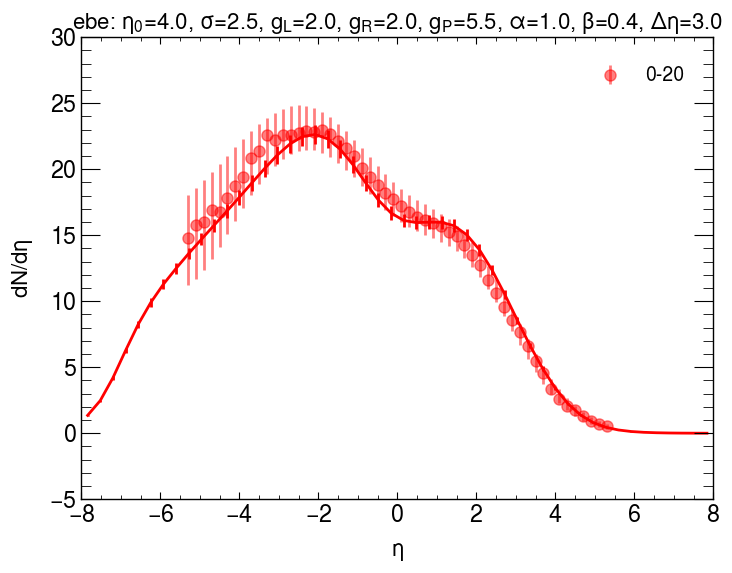

In [42]:
plot_dNdEta(
    m=0, n=20, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p4_y_loss_3p0",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='red', coef=1, fontsize=16)
plt.errorbar(data_exp[0][:, 0], data_exp[0][:, 2], yerr=[data_exp[0][:, 4], data_exp[0][:, 3]], 
                     fmt='o', ecolor='red', color='red', alpha=0.5, label='0-20')
plt.legend()

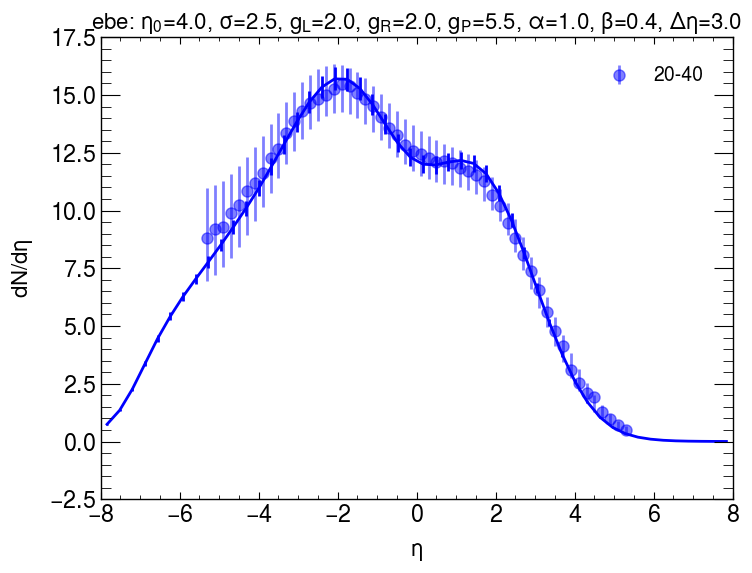

In [43]:
plot_dNdEta(
    m=20, n=40, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p4_y_loss_3p0",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='blue', coef=1, fontsize=16)
plt.errorbar(data_exp[1][:, 0], data_exp[1][:, 2], yerr=[data_exp[1][:, 4], data_exp[1][:, 3]], 
                     fmt='o', ecolor='blue', color='blue', alpha=0.5, label='20-40')
plt.legend()

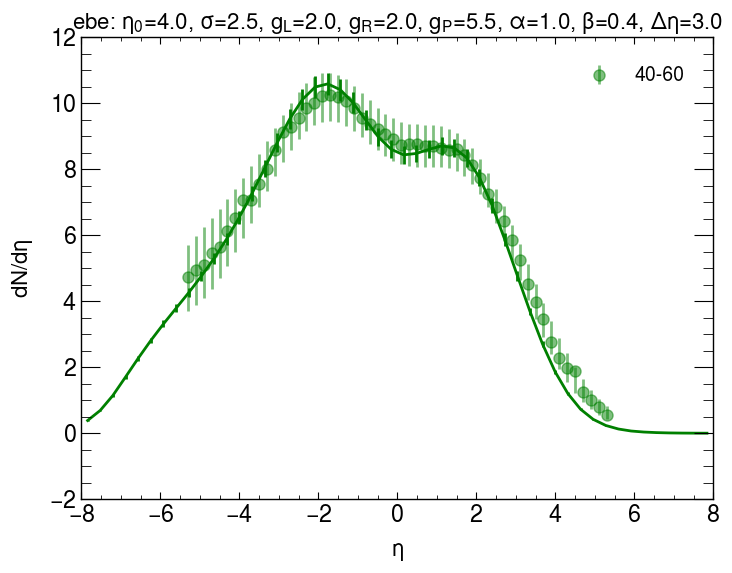

In [44]:
plot_dNdEta(
    m=40, n=60, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p4_y_loss_3p0",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='green', coef=1, fontsize=16)
plt.errorbar(data_exp[2][:, 0], data_exp[2][:, 2], yerr=[data_exp[2][:, 4], data_exp[2][:, 3]], 
                     fmt='o', ecolor='green', color='green', alpha=0.5, label='40-60')
plt.legend()

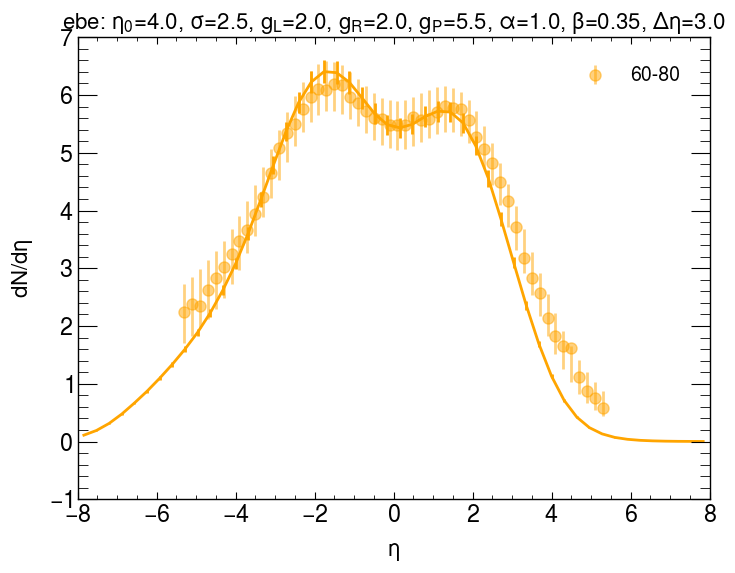

In [38]:
plot_dNdEta(
    m=60, n=80, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35_y_loss_3p0",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='orange', coef=1, fontsize=16)
plt.errorbar(data_exp[3][:, 0], data_exp[3][:, 2], yerr=[data_exp[3][:, 4], data_exp[3][:, 3]], 
                     fmt='o', ecolor='orange', color='orange', alpha=0.5, label='60-80')
plt.legend()

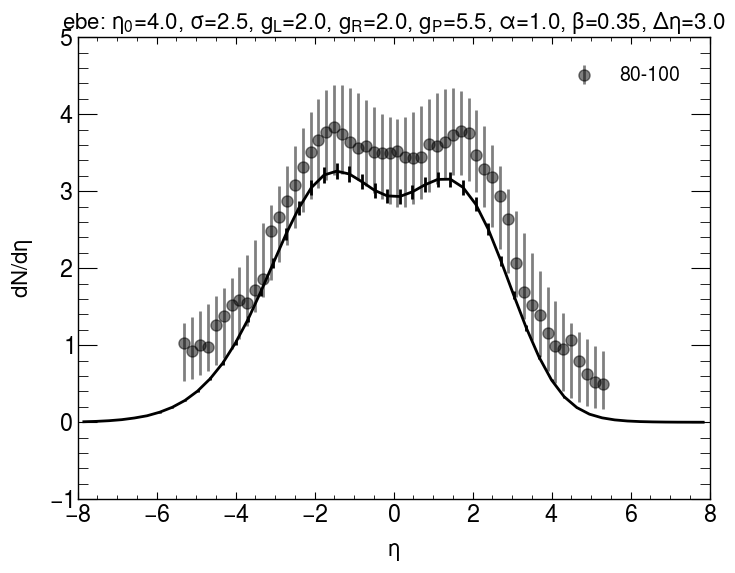

In [39]:
plot_dNdEta(
    m=80, n=100, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35_y_loss_3p0",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='black', coef=1, fontsize=16)
plt.errorbar(data_exp[4][:, 0], data_exp[4][:, 2], yerr=[data_exp[4][:, 4], data_exp[4][:, 3]], 
                     fmt='o', ecolor='black', color='black', alpha=0.5, label='80-100')
plt.legend()

In [40]:
def plot_hydro_all(
    eta_flat='1p3',eta_gw='1p3',
    para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
    mode='SMOOTH', nsampling=2000, event_range=[0,300],plot_errbar='true',
    HWF_or_DWF='HWF',coef=1,fontsize=16):
    
    # 颜色列表，用于每个中心度的线条和散点保持一致
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
    markers = ['o', '^', 'v', '*','s', 'D']

    # 绘图
    for idx, m in enumerate([0, 20, 40, 60,80]):
        # 绘制不同中心度范围的模拟数据，并确保颜色一致
        plot_dNdEta(m=m, n=m+20, para=para, eta_flat=eta_flat,eta_gw=eta_gw,HWF_or_DWF=HWF_or_DWF, 
                    event_range=event_range,nsampling=nsampling,plot_errbar=plot_errbar,
                    mode_MC_SMOOTH=mode, coef=coef,fontsize=fontsize, color=colors[idx])
        # 绘制实验结果，确保颜色与模拟数据一致
        plt.errorbar(data_exp[idx][:, 0], data_exp[idx][:, 2], yerr=[data_exp[idx][:, 4], data_exp[idx][:, 3]], 
                     fmt=markers[idx], ecolor=colors[idx], color=colors[idx], alpha=0.5, label=labels[idx])

    
    plt.legend(fontsize=fontsize)
    plt.gcf().set_size_inches(8, 6)  # 调整当前图形的大小为宽10英寸，高6英寸

    plt.show()  # 在最后显示所有图像

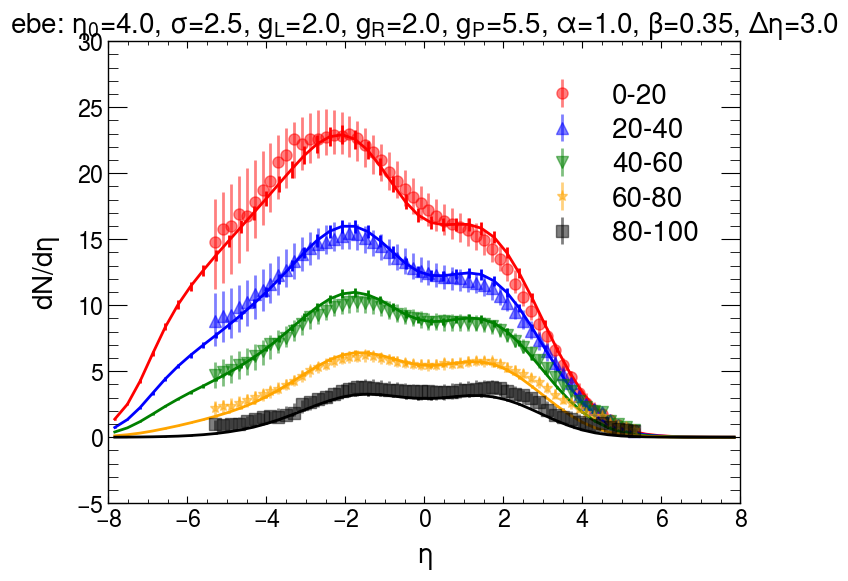

In [41]:
plot_hydro_all(
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35_y_loss_3p0",
    mode='MC',HWF_or_DWF='DWF',event_range=[0,1000],nsampling=2000,plot_errbar=True,
    eta_flat='1p3',eta_gw='1p3',coef=1,fontsize=20)